In [263]:
# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Reshape, Flatten, LSTM, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta

### Connect to mongo database

In [3]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.data

In [98]:
# Unwind the window start
pipeline = [
    {"$unwind": "$window"},
    {'$addFields': {'window': '$window.start'}}
]

# Transform the data into a dataframe
df = (pd.DataFrame(list(data.aggregate(pipeline)))
      .drop('_id', 1)
      .set_index('window')
      .sort_index())

# Ignore the first and last windows
df = df.iloc[2:-1]

# Show the first five rows
df.head()

,n_tweets,price,sentiment
window,,,
2019-11-03 15:00:00,558,9190.851,0.132156
2019-11-03 15:10:00,471,9205.565,0.142665
2019-11-03 15:20:00,468,9208.484,0.155131
2019-11-03 15:30:00,431,9209.280,0.167685
2019-11-03 15:40:00,414,9191.988,0.177687


### Function to create timeline plot

In [99]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")

    df[first_feature].plot()
    plt.legend(loc='upper left')
    ax2 = plt.twinx()
    df[second_feature].plot(color='orange', ax=ax2)
    ax2.legend(loc='upper right')

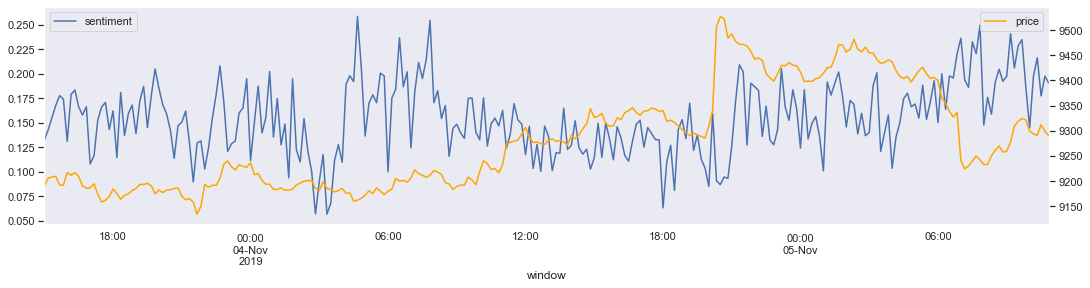

In [100]:
plot_timeline('sentiment', 'price')

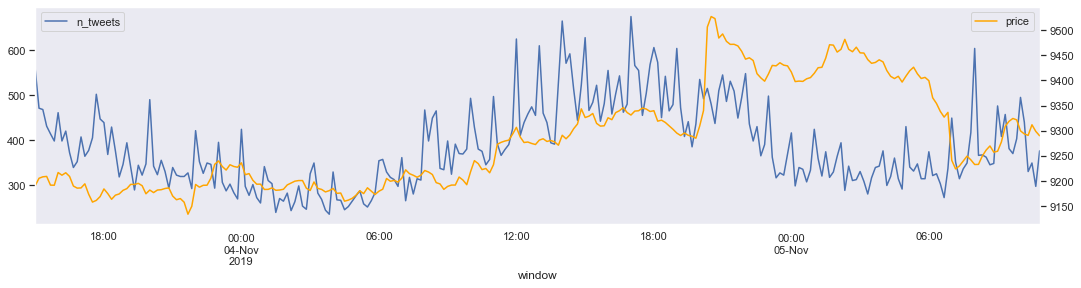

In [101]:
plot_timeline('n_tweets', 'price')

### Normalize

In [107]:
df_norm = (df-df.mean())/df.std()
df_norm.head()

,n_tweets,price,sentiment
window,,,
2019-11-03 15:00:00,1.879796,-0.914515,-0.609504
2019-11-03 15:10:00,0.933906,-0.766708,-0.323262
2019-11-03 15:20:00,0.901289,-0.737386,0.016276
2019-11-03 15:30:00,0.499014,-0.729390,0.358239
2019-11-03 15:40:00,0.314185,-0.903094,0.630655


### Function to get the historic values

In [227]:
def historic(row, feature):
    # The datetime of the current row
    end_time = row.name - timedelta(seconds=1)
    
    # The datetime of the start of the window
    start_time = row.name - timedelta(hours=5)
    
    # Return the previous values
    return df_norm.loc[start_time:end_time, feature].values

In [228]:
features = ['sentiment', 'price', 'n_tweets']

for feature in features:
    df_norm['hist_{}'.format(feature)] = df_norm.apply(lambda row: historic(row, feature=feature), 1)

df_norm.head()

,n_tweets,price,sentiment,hist_sentiment,hist_price,hist_n_tweets
window,,,,,,
2019-11-03 15:00:00,1.879796,-0.914515,-0.609504,[],[],[]
2019-11-03 15:10:00,0.933906,-0.766708,-0.323262,[-0.6095035189117658],[-0.9145154486870073],[1.8797959790935805]
2019-11-03 15:20:00,0.901289,-0.737386,0.016276,"[-0.6095035189117658, -0.32326171125238456]","[-0.9145154486870073, -0.7667080845903967]","[1.8797959790935805, 0.9339058696002874]"
2019-11-03 15:30:00,0.499014,-0.729390,0.358239,"[-0.6095035189117658, -0.32326171125238456, 0....","[-0.9145154486870073, -0.7667080845903967, -0....","[1.8797959790935805, 0.9339058696002874, 0.901..."
2019-11-03 15:40:00,0.314185,-0.903094,0.630655,"[-0.6095035189117658, -0.32326171125238456, 0....","[-0.9145154486870073, -0.7667080845903967, -0....","[1.8797959790935805, 0.9339058696002874, 0.901..."


In [230]:
def timeseries_df(feature, label):
    # Expand into it's own dataframe
    values = df_norm[feature].apply(pd.Series)

    # Rename the variables
    values = values.rename(columns = lambda x : label + '_' + str(x))

    # Return the dataframe
    return values.dropna()

prices = timeseries_df(feature='hist_price', label='price')
prices.head()

,price_0,price_1,price_2,price_3,price_4,price_5,price_6,price_7,price_8,price_9,...,price_20,price_21,price_22,price_23,price_24,price_25,price_26,price_27,price_28,price_29
window,,,,,,,,,,,,,,,,,,,,,
2019-11-03 20:00:00,-0.914515,-0.766708,-0.737386,-0.729390,-0.903094,-0.905475,-0.652392,-0.705281,-0.656611,-0.729731,...,-1.185710,-1.103961,-1.078928,-1.007254,-0.972956,-0.887554,-0.891029,-0.867684,-0.914716,-1.076045
2019-11-03 20:10:00,-0.766708,-0.737386,-0.729390,-0.903094,-0.905475,-0.652392,-0.705281,-0.656611,-0.729731,-0.921366,...,-1.103961,-1.078928,-1.007254,-0.972956,-0.887554,-0.891029,-0.867684,-0.914716,-1.076045,-1.001348
2019-11-03 20:20:00,-0.737386,-0.729390,-0.903094,-0.905475,-0.652392,-0.705281,-0.656611,-0.729731,-0.921366,-0.963145,...,-1.078928,-1.007254,-0.972956,-0.887554,-0.891029,-0.867684,-0.914716,-1.076045,-1.001348,-1.052298
2019-11-03 20:30:00,-0.729390,-0.903094,-0.905475,-0.652392,-0.705281,-0.656611,-0.729731,-0.921366,-0.963145,-0.959207,...,-1.007254,-0.972956,-0.887554,-0.891029,-0.867684,-0.914716,-1.076045,-1.001348,-1.052298,-1.001147
2019-11-03 20:40:00,-0.903094,-0.905475,-0.652392,-0.705281,-0.656611,-0.729731,-0.921366,-0.963145,-0.959207,-0.877418,...,-0.972956,-0.887554,-0.891029,-0.867684,-0.914716,-1.076045,-1.001348,-1.052298,-1.001147,-0.994627


### Train test split

In [245]:
split_point = int(.67 * len(prices))

X_train, X_test = prices.iloc[:split_point], prices.iloc[split_point:]
y_train, y_test = df['price'][:split_point].values, df['price'][split_point:].values

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((156, 30), (78, 30), (156,), (108,))

### Reshape the data to fit into the LSTM

In [246]:
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1])
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1])

X_train.shape, X_test.shape

((156, 30), (78, 30))

### Build the keras model

In [264]:
def generate_model(input_shape):
    model = Sequential()
    model.add(Dense(16, input_shape=(input_shape,), activation='relu'))
#     model.add(LSTM(16, input_shape=(input_shape, 1)))
    model.add(Dense(1, activation='relu'))
    
    adam = optimizers.Adam(learning_rate=0.01)
    
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

In [265]:
model = generate_model(input_shape=X_train.shape[1])
model.fit(x=X_train, y=y_train, batch_size=200, epochs=30000);

Train on 156 samples
Epoch 1/30000
156/156 [==============================] - 0s 449us/sample - loss: 84966584.0000
Epoch 2/30000
156/156 [==============================] - 0s 32us/sample - loss: 84955576.0000
Epoch 3/30000
156/156 [==============================] - 0s 64us/sample - loss: 84943416.0000
Epoch 4/30000
156/156 [==============================] - 0s 32us/sample - loss: 84931568.0000
Epoch 5/30000
156/156 [==============================] - 0s 26us/sample - loss: 84920832.0000
Epoch 6/30000
156/156 [==============================] - 0s 26us/sample - loss: 84910344.0000
Epoch 7/30000
156/156 [==============================] - 0s 26us/sample - loss: 84899496.0000
Epoch 8/30000
156/156 [==============================] - 0s 26us/sample - loss: 84888128.0000
Epoch 9/30000
156/156 [==============================] - 0s 26us/sample - loss: 84876160.0000
Epoch 10/30000
156/156 [==============================] - 0s 32us/sample - loss: 84863640.0000
Epoch 11/30000
156/156 [=============

Epoch 88/30000
156/156 [==============================] - 0s 19us/sample - loss: 81293768.0000
Epoch 89/30000
156/156 [==============================] - 0s 26us/sample - loss: 81207176.0000
Epoch 90/30000
156/156 [==============================] - 0s 26us/sample - loss: 81119448.0000
Epoch 91/30000
156/156 [==============================] - 0s 26us/sample - loss: 81030576.0000
Epoch 92/30000
156/156 [==============================] - 0s 19us/sample - loss: 80940528.0000
Epoch 93/30000
156/156 [==============================] - 0s 26us/sample - loss: 80849352.0000
Epoch 94/30000
156/156 [==============================] - 0s 26us/sample - loss: 80757000.0000
Epoch 95/30000
156/156 [==============================] - 0s 26us/sample - loss: 80663488.0000
Epoch 96/30000
156/156 [==============================] - 0s 26us/sample - loss: 80568816.0000
Epoch 97/30000
156/156 [==============================] - 0s 19us/sample - loss: 80472968.0000
Epoch 98/30000
156/156 [==========================

Epoch 174/30000
156/156 [==============================] - 0s 26us/sample - loss: 69827312.0000
Epoch 175/30000
156/156 [==============================] - 0s 26us/sample - loss: 69652536.0000
Epoch 176/30000
156/156 [==============================] - 0s 26us/sample - loss: 69477032.0000
Epoch 177/30000
156/156 [==============================] - 0s 32us/sample - loss: 69300784.0000
Epoch 178/30000
156/156 [==============================] - 0s 32us/sample - loss: 69123792.0000
Epoch 179/30000
156/156 [==============================] - 0s 19us/sample - loss: 68946088.0000
Epoch 180/30000
156/156 [==============================] - 0s 26us/sample - loss: 68767672.0000
Epoch 181/30000
156/156 [==============================] - 0s 26us/sample - loss: 68588544.0000
Epoch 182/30000
156/156 [==============================] - 0s 26us/sample - loss: 68408728.0000
Epoch 183/30000
156/156 [==============================] - 0s 26us/sample - loss: 68228208.0000
Epoch 184/30000
156/156 [===============

Epoch 260/30000
156/156 [==============================] - 0s 26us/sample - loss: 52926480.0000
Epoch 261/30000
156/156 [==============================] - 0s 19us/sample - loss: 52718448.0000
Epoch 262/30000
156/156 [==============================] - 0s 26us/sample - loss: 52510404.0000
Epoch 263/30000
156/156 [==============================] - 0s 19us/sample - loss: 52302348.0000
Epoch 264/30000
156/156 [==============================] - 0s 26us/sample - loss: 52094308.0000
Epoch 265/30000
156/156 [==============================] - 0s 26us/sample - loss: 51886280.0000
Epoch 266/30000
156/156 [==============================] - 0s 26us/sample - loss: 51678276.0000
Epoch 267/30000
156/156 [==============================] - 0s 19us/sample - loss: 51470300.0000
Epoch 268/30000
156/156 [==============================] - 0s 19us/sample - loss: 51262364.0000
Epoch 269/30000
156/156 [==============================] - 0s 19us/sample - loss: 51054472.0000
Epoch 270/30000
156/156 [===============

Epoch 346/30000
156/156 [==============================] - 0s 26us/sample - loss: 35361460.0000
Epoch 347/30000
156/156 [==============================] - 0s 26us/sample - loss: 35162860.0000
Epoch 348/30000
156/156 [==============================] - 0s 19us/sample - loss: 34964740.0000
Epoch 349/30000
156/156 [==============================] - 0s 19us/sample - loss: 34767120.0000
Epoch 350/30000
156/156 [==============================] - 0s 26us/sample - loss: 34570024.0000
Epoch 351/30000
156/156 [==============================] - 0s 26us/sample - loss: 34373460.0000
Epoch 352/30000
156/156 [==============================] - 0s 26us/sample - loss: 34177452.0000
Epoch 353/30000
156/156 [==============================] - 0s 26us/sample - loss: 33982016.0000
Epoch 354/30000
156/156 [==============================] - 0s 26us/sample - loss: 33787168.0000
Epoch 355/30000
156/156 [==============================] - 0s 32us/sample - loss: 33592924.0000
Epoch 356/30000
156/156 [===============

Epoch 432/30000
156/156 [==============================] - 0s 32us/sample - loss: 21220896.0000
Epoch 433/30000
156/156 [==============================] - 0s 19us/sample - loss: 21098618.0000
Epoch 434/30000
156/156 [==============================] - 0s 19us/sample - loss: 20977342.0000
Epoch 435/30000
156/156 [==============================] - 0s 19us/sample - loss: 20857070.0000
Epoch 436/30000
156/156 [==============================] - 0s 32us/sample - loss: 20737796.0000
Epoch 437/30000
156/156 [==============================] - 0s 38us/sample - loss: 20619516.0000
Epoch 438/30000
156/156 [==============================] - 0s 19us/sample - loss: 20502232.0000
Epoch 439/30000
156/156 [==============================] - 0s 32us/sample - loss: 20385936.0000
Epoch 440/30000
156/156 [==============================] - 0s 19us/sample - loss: 20270630.0000
Epoch 441/30000
156/156 [==============================] - 0s 26us/sample - loss: 20156308.0000
Epoch 442/30000
156/156 [===============

Epoch 518/30000
156/156 [==============================] - 0s 32us/sample - loss: 13946946.0000
Epoch 519/30000
156/156 [==============================] - 0s 26us/sample - loss: 13894302.0000
Epoch 520/30000
156/156 [==============================] - 0s 26us/sample - loss: 13842215.0000
Epoch 521/30000
156/156 [==============================] - 0s 26us/sample - loss: 13790687.0000
Epoch 522/30000
156/156 [==============================] - 0s 32us/sample - loss: 13739709.0000
Epoch 523/30000
156/156 [==============================] - 0s 19us/sample - loss: 13689273.0000
Epoch 524/30000
156/156 [==============================] - 0s 19us/sample - loss: 13639375.0000
Epoch 525/30000
156/156 [==============================] - 0s 26us/sample - loss: 13590011.0000
Epoch 526/30000
156/156 [==============================] - 0s 26us/sample - loss: 13541173.0000
Epoch 527/30000
156/156 [==============================] - 0s 26us/sample - loss: 13492854.0000
Epoch 528/30000
156/156 [===============

Epoch 604/30000
156/156 [==============================] - 0s 19us/sample - loss: 10939261.0000
Epoch 605/30000
156/156 [==============================] - 0s 19us/sample - loss: 10916901.0000
Epoch 606/30000
156/156 [==============================] - 0s 26us/sample - loss: 10894730.0000
Epoch 607/30000
156/156 [==============================] - 0s 19us/sample - loss: 10872745.0000
Epoch 608/30000
156/156 [==============================] - 0s 26us/sample - loss: 10850942.0000
Epoch 609/30000
156/156 [==============================] - 0s 19us/sample - loss: 10829324.0000
Epoch 610/30000
156/156 [==============================] - 0s 19us/sample - loss: 10807885.0000
Epoch 611/30000
156/156 [==============================] - 0s 19us/sample - loss: 10786625.0000
Epoch 612/30000
156/156 [==============================] - 0s 19us/sample - loss: 10765539.0000
Epoch 613/30000
156/156 [==============================] - 0s 19us/sample - loss: 10744629.0000
Epoch 614/30000
156/156 [===============

Epoch 690/30000
156/156 [==============================] - 0s 19us/sample - loss: 9515397.0000
Epoch 691/30000
156/156 [==============================] - 0s 19us/sample - loss: 9503076.0000
Epoch 692/30000
156/156 [==============================] - 0s 19us/sample - loss: 9490823.0000
Epoch 693/30000
156/156 [==============================] - 0s 19us/sample - loss: 9478645.0000
Epoch 694/30000
156/156 [==============================] - 0s 26us/sample - loss: 9466534.0000
Epoch 695/30000
156/156 [==============================] - 0s 32us/sample - loss: 9454492.0000
Epoch 696/30000
156/156 [==============================] - 0s 26us/sample - loss: 9442521.0000
Epoch 697/30000
156/156 [==============================] - 0s 19us/sample - loss: 9430615.0000
Epoch 698/30000
156/156 [==============================] - 0s 26us/sample - loss: 9418778.0000
Epoch 699/30000
156/156 [==============================] - 0s 19us/sample - loss: 9407008.0000
Epoch 700/30000
156/156 [=========================

Epoch 777/30000
156/156 [==============================] - 0s 19us/sample - loss: 8652580.0000
Epoch 778/30000
156/156 [==============================] - 0s 19us/sample - loss: 8644545.0000
Epoch 779/30000
156/156 [==============================] - 0s 26us/sample - loss: 8636542.0000
Epoch 780/30000
156/156 [==============================] - 0s 19us/sample - loss: 8628573.0000
Epoch 781/30000
156/156 [==============================] - 0s 19us/sample - loss: 8620634.0000
Epoch 782/30000
156/156 [==============================] - 0s 26us/sample - loss: 8612728.0000
Epoch 783/30000
156/156 [==============================] - 0s 19us/sample - loss: 8604854.0000
Epoch 784/30000
156/156 [==============================] - 0s 26us/sample - loss: 8597012.0000
Epoch 785/30000
156/156 [==============================] - 0s 32us/sample - loss: 8589200.0000
Epoch 786/30000
156/156 [==============================] - 0s 26us/sample - loss: 8581419.0000
Epoch 787/30000
156/156 [=========================

Epoch 864/30000
156/156 [==============================] - 0s 19us/sample - loss: 8030089.0000
Epoch 865/30000
156/156 [==============================] - 0s 19us/sample - loss: 8023459.5000
Epoch 866/30000
156/156 [==============================] - 0s 26us/sample - loss: 8016842.0000
Epoch 867/30000
156/156 [==============================] - 0s 26us/sample - loss: 8010236.5000
Epoch 868/30000
156/156 [==============================] - 0s 19us/sample - loss: 8003644.5000
Epoch 869/30000
156/156 [==============================] - 0s 26us/sample - loss: 7997067.5000
Epoch 870/30000
156/156 [==============================] - 0s 26us/sample - loss: 7990501.5000
Epoch 871/30000
156/156 [==============================] - 0s 19us/sample - loss: 7983951.0000
Epoch 872/30000
156/156 [==============================] - 0s 19us/sample - loss: 7977413.0000
Epoch 873/30000
156/156 [==============================] - 0s 26us/sample - loss: 7970890.0000
Epoch 874/30000
156/156 [=========================

Epoch 951/30000
156/156 [==============================] - 0s 19us/sample - loss: 7497762.5000
Epoch 952/30000
156/156 [==============================] - 0s 26us/sample - loss: 7492043.5000
Epoch 953/30000
156/156 [==============================] - 0s 19us/sample - loss: 7486330.5000
Epoch 954/30000
156/156 [==============================] - 0s 19us/sample - loss: 7480623.5000
Epoch 955/30000
156/156 [==============================] - 0s 26us/sample - loss: 7474924.5000
Epoch 956/30000
156/156 [==============================] - 0s 19us/sample - loss: 7469234.0000
Epoch 957/30000
156/156 [==============================] - 0s 26us/sample - loss: 7463548.5000
Epoch 958/30000
156/156 [==============================] - 0s 19us/sample - loss: 7457871.0000
Epoch 959/30000
156/156 [==============================] - 0s 19us/sample - loss: 7452199.5000
Epoch 960/30000
156/156 [==============================] - 0s 19us/sample - loss: 7446534.5000
Epoch 961/30000
156/156 [=========================

Epoch 1037/30000
156/156 [==============================] - 0s 19us/sample - loss: 6994523.0000
Epoch 1038/30000
156/156 [==============================] - 0s 19us/sample - loss: 6988513.5000
Epoch 1039/30000
156/156 [==============================] - 0s 26us/sample - loss: 6982505.0000
Epoch 1040/30000
156/156 [==============================] - 0s 26us/sample - loss: 6976502.0000
Epoch 1041/30000
156/156 [==============================] - 0s 26us/sample - loss: 6970502.5000
Epoch 1042/30000
156/156 [==============================] - 0s 19us/sample - loss: 6964506.5000
Epoch 1043/30000
156/156 [==============================] - 0s 26us/sample - loss: 6958515.0000
Epoch 1044/30000
156/156 [==============================] - 0s 26us/sample - loss: 6952528.5000
Epoch 1045/30000
156/156 [==============================] - 0s 19us/sample - loss: 6946545.0000
Epoch 1046/30000
156/156 [==============================] - 0s 19us/sample - loss: 6940568.0000
Epoch 1047/30000
156/156 [==============

Epoch 1123/30000
156/156 [==============================] - 0s 19us/sample - loss: 6477391.0000
Epoch 1124/30000
156/156 [==============================] - 0s 19us/sample - loss: 6471198.5000
Epoch 1125/30000
156/156 [==============================] - 0s 26us/sample - loss: 6465002.0000
Epoch 1126/30000
156/156 [==============================] - 0s 19us/sample - loss: 6458804.0000
Epoch 1127/30000
156/156 [==============================] - 0s 19us/sample - loss: 6452604.5000
Epoch 1128/30000
156/156 [==============================] - 0s 26us/sample - loss: 6446404.5000
Epoch 1129/30000
156/156 [==============================] - 0s 26us/sample - loss: 6440204.5000
Epoch 1130/30000
156/156 [==============================] - 0s 32us/sample - loss: 6434005.5000
Epoch 1131/30000
156/156 [==============================] - 0s 19us/sample - loss: 6427807.0000
Epoch 1132/30000
156/156 [==============================] - 0s 32us/sample - loss: 6421610.5000
Epoch 1133/30000
156/156 [==============

Epoch 1209/30000
156/156 [==============================] - 0s 19us/sample - loss: 5934081.0000
Epoch 1210/30000
156/156 [==============================] - 0s 26us/sample - loss: 5927733.0000
Epoch 1211/30000
156/156 [==============================] - 0s 26us/sample - loss: 5921365.0000
Epoch 1212/30000
156/156 [==============================] - 0s 26us/sample - loss: 5914959.5000
Epoch 1213/30000
156/156 [==============================] - 0s 26us/sample - loss: 5908485.5000
Epoch 1214/30000
156/156 [==============================] - 0s 26us/sample - loss: 5901919.5000
Epoch 1215/30000
156/156 [==============================] - 0s 32us/sample - loss: 5895341.0000
Epoch 1216/30000
156/156 [==============================] - 0s 19us/sample - loss: 5888751.0000
Epoch 1217/30000
156/156 [==============================] - 0s 26us/sample - loss: 5882151.5000
Epoch 1218/30000
156/156 [==============================] - 0s 26us/sample - loss: 5875545.0000
Epoch 1219/30000
156/156 [==============

Epoch 1295/30000
156/156 [==============================] - 0s 26us/sample - loss: 5341120.5000
Epoch 1296/30000
156/156 [==============================] - 0s 19us/sample - loss: 5333914.0000
Epoch 1297/30000
156/156 [==============================] - 0s 26us/sample - loss: 5326632.0000
Epoch 1298/30000
156/156 [==============================] - 0s 26us/sample - loss: 5319326.0000
Epoch 1299/30000
156/156 [==============================] - 0s 19us/sample - loss: 5311952.0000
Epoch 1300/30000
156/156 [==============================] - 0s 19us/sample - loss: 5304569.0000
Epoch 1301/30000
156/156 [==============================] - 0s 19us/sample - loss: 5297180.0000
Epoch 1302/30000
156/156 [==============================] - 0s 26us/sample - loss: 5289787.0000
Epoch 1303/30000
156/156 [==============================] - 0s 19us/sample - loss: 5282394.0000
Epoch 1304/30000
156/156 [==============================] - 0s 19us/sample - loss: 5274999.0000
Epoch 1305/30000
156/156 [==============

Epoch 1381/30000
156/156 [==============================] - 0s 26us/sample - loss: 4692189.0000
Epoch 1382/30000
156/156 [==============================] - 0s 26us/sample - loss: 4684407.0000
Epoch 1383/30000
156/156 [==============================] - 0s 19us/sample - loss: 4676632.5000
Epoch 1384/30000
156/156 [==============================] - 0s 26us/sample - loss: 4668867.0000
Epoch 1385/30000
156/156 [==============================] - 0s 19us/sample - loss: 4661110.0000
Epoch 1386/30000
156/156 [==============================] - 0s 26us/sample - loss: 4653363.0000
Epoch 1387/30000
156/156 [==============================] - 0s 19us/sample - loss: 4645628.0000
Epoch 1388/30000
156/156 [==============================] - 0s 19us/sample - loss: 4637902.5000
Epoch 1389/30000
156/156 [==============================] - 0s 19us/sample - loss: 4630118.0000
Epoch 1390/30000
156/156 [==============================] - 0s 19us/sample - loss: 4622337.0000
Epoch 1391/30000
156/156 [==============

Epoch 1467/30000
156/156 [==============================] - 0s 26us/sample - loss: 4023764.5000
Epoch 1468/30000
156/156 [==============================] - 0s 19us/sample - loss: 4016060.7500
Epoch 1469/30000
156/156 [==============================] - 0s 32us/sample - loss: 4008369.2500
Epoch 1470/30000
156/156 [==============================] - 0s 26us/sample - loss: 4000692.5000
Epoch 1471/30000
156/156 [==============================] - 0s 19us/sample - loss: 3993029.0000
Epoch 1472/30000
156/156 [==============================] - 0s 19us/sample - loss: 3985381.0000
Epoch 1473/30000
156/156 [==============================] - 0s 26us/sample - loss: 3977726.7500
Epoch 1474/30000
156/156 [==============================] - 0s 26us/sample - loss: 3970045.5000
Epoch 1475/30000
156/156 [==============================] - 0s 19us/sample - loss: 3962375.7500
Epoch 1476/30000
156/156 [==============================] - 0s 19us/sample - loss: 3954718.0000
Epoch 1477/30000
156/156 [==============

Epoch 1553/30000
156/156 [==============================] - 0s 26us/sample - loss: 3400432.5000
Epoch 1554/30000
156/156 [==============================] - 0s 26us/sample - loss: 3393659.7500
Epoch 1555/30000
156/156 [==============================] - 0s 19us/sample - loss: 3386903.0000
Epoch 1556/30000
156/156 [==============================] - 0s 19us/sample - loss: 3380162.2500
Epoch 1557/30000
156/156 [==============================] - 0s 19us/sample - loss: 3373437.2500
Epoch 1558/30000
156/156 [==============================] - 0s 19us/sample - loss: 3366730.7500
Epoch 1559/30000
156/156 [==============================] - 0s 19us/sample - loss: 3360042.5000
Epoch 1560/30000
156/156 [==============================] - 0s 19us/sample - loss: 3353371.7500
Epoch 1561/30000
156/156 [==============================] - 0s 26us/sample - loss: 3346719.2500
Epoch 1562/30000
156/156 [==============================] - 0s 19us/sample - loss: 3340085.7500
Epoch 1563/30000
156/156 [==============

Epoch 1639/30000
156/156 [==============================] - 0s 19us/sample - loss: 2885141.0000
Epoch 1640/30000
156/156 [==============================] - 0s 32us/sample - loss: 2879950.0000
Epoch 1641/30000
156/156 [==============================] - 0s 26us/sample - loss: 2874778.7500
Epoch 1642/30000
156/156 [==============================] - 0s 19us/sample - loss: 2869626.7500
Epoch 1643/30000
156/156 [==============================] - 0s 19us/sample - loss: 2864495.0000
Epoch 1644/30000
156/156 [==============================] - 0s 26us/sample - loss: 2859381.2500
Epoch 1645/30000
156/156 [==============================] - 0s 19us/sample - loss: 2854288.5000
Epoch 1646/30000
156/156 [==============================] - 0s 19us/sample - loss: 2849215.0000
Epoch 1647/30000
156/156 [==============================] - 0s 19us/sample - loss: 2844159.5000
Epoch 1648/30000
156/156 [==============================] - 0s 26us/sample - loss: 2839124.5000
Epoch 1649/30000
156/156 [==============

Epoch 1725/30000
156/156 [==============================] - 0s 26us/sample - loss: 2500166.5000
Epoch 1726/30000
156/156 [==============================] - 0s 32us/sample - loss: 2496411.5000
Epoch 1727/30000
156/156 [==============================] - 0s 26us/sample - loss: 2492674.0000
Epoch 1728/30000
156/156 [==============================] - 0s 26us/sample - loss: 2488951.5000
Epoch 1729/30000
156/156 [==============================] - 0s 26us/sample - loss: 2485236.7500
Epoch 1730/30000
156/156 [==============================] - 0s 19us/sample - loss: 2481511.2500
Epoch 1731/30000
156/156 [==============================] - 0s 19us/sample - loss: 2477797.2500
Epoch 1732/30000
156/156 [==============================] - 0s 19us/sample - loss: 2474097.2500
Epoch 1733/30000
156/156 [==============================] - 0s 19us/sample - loss: 2470409.0000
Epoch 1734/30000
156/156 [==============================] - 0s 19us/sample - loss: 2466735.7500
Epoch 1735/30000
156/156 [==============

Epoch 1811/30000
156/156 [==============================] - 0s 19us/sample - loss: 2222376.0000
Epoch 1812/30000
156/156 [==============================] - 0s 26us/sample - loss: 2219632.7500
Epoch 1813/30000
156/156 [==============================] - 0s 26us/sample - loss: 2216903.0000
Epoch 1814/30000
156/156 [==============================] - 0s 19us/sample - loss: 2214184.7500
Epoch 1815/30000
156/156 [==============================] - 0s 19us/sample - loss: 2211479.7500
Epoch 1816/30000
156/156 [==============================] - 0s 26us/sample - loss: 2208786.7500
Epoch 1817/30000
156/156 [==============================] - 0s 32us/sample - loss: 2206106.7500
Epoch 1818/30000
156/156 [==============================] - 0s 19us/sample - loss: 2203438.5000
Epoch 1819/30000
156/156 [==============================] - 0s 26us/sample - loss: 2200783.5000
Epoch 1820/30000
156/156 [==============================] - 0s 19us/sample - loss: 2198141.2500
Epoch 1821/30000
156/156 [==============

Epoch 1897/30000
156/156 [==============================] - 0s 26us/sample - loss: 2026935.6250
Epoch 1898/30000
156/156 [==============================] - 0s 26us/sample - loss: 2025080.0000
Epoch 1899/30000
156/156 [==============================] - 0s 19us/sample - loss: 2023231.6250
Epoch 1900/30000
156/156 [==============================] - 0s 26us/sample - loss: 2021392.3750
Epoch 1901/30000
156/156 [==============================] - 0s 26us/sample - loss: 2019561.3750
Epoch 1902/30000
156/156 [==============================] - 0s 26us/sample - loss: 2017738.0000
Epoch 1903/30000
156/156 [==============================] - 0s 26us/sample - loss: 2015923.1250
Epoch 1904/30000
156/156 [==============================] - 0s 19us/sample - loss: 2014117.5000
Epoch 1905/30000
156/156 [==============================] - 0s 19us/sample - loss: 2012319.7500
Epoch 1906/30000
156/156 [==============================] - 0s 26us/sample - loss: 2010530.0000
Epoch 1907/30000
156/156 [==============

Epoch 1983/30000
156/156 [==============================] - 0s 26us/sample - loss: 1895509.1250
Epoch 1984/30000
156/156 [==============================] - 0s 19us/sample - loss: 1894261.7500
Epoch 1985/30000
156/156 [==============================] - 0s 19us/sample - loss: 1893020.1250
Epoch 1986/30000
156/156 [==============================] - 0s 19us/sample - loss: 1891783.3750
Epoch 1987/30000
156/156 [==============================] - 0s 19us/sample - loss: 1890553.3750
Epoch 1988/30000
156/156 [==============================] - 0s 19us/sample - loss: 1889327.7500
Epoch 1989/30000
156/156 [==============================] - 0s 26us/sample - loss: 1888107.7500
Epoch 1990/30000
156/156 [==============================] - 0s 19us/sample - loss: 1886893.1250
Epoch 1991/30000
156/156 [==============================] - 0s 19us/sample - loss: 1885683.7500
Epoch 1992/30000
156/156 [==============================] - 0s 26us/sample - loss: 1884480.3750
Epoch 1993/30000
156/156 [==============

Epoch 2069/30000
156/156 [==============================] - 0s 32us/sample - loss: 1804338.5000
Epoch 2070/30000
156/156 [==============================] - 0s 26us/sample - loss: 1803445.1250
Epoch 2071/30000
156/156 [==============================] - 0s 19us/sample - loss: 1802555.1250
Epoch 2072/30000
156/156 [==============================] - 0s 26us/sample - loss: 1801667.7500
Epoch 2073/30000
156/156 [==============================] - 0s 26us/sample - loss: 1800785.3750
Epoch 2074/30000
156/156 [==============================] - 0s 26us/sample - loss: 1799905.2500
Epoch 2075/30000
156/156 [==============================] - 0s 26us/sample - loss: 1799029.3750
Epoch 2076/30000
156/156 [==============================] - 0s 26us/sample - loss: 1798157.1250
Epoch 2077/30000
156/156 [==============================] - 0s 19us/sample - loss: 1797287.3750
Epoch 2078/30000
156/156 [==============================] - 0s 26us/sample - loss: 1796422.1250
Epoch 2079/30000
156/156 [==============

Epoch 2155/30000
156/156 [==============================] - 0s 26us/sample - loss: 1737292.8750
Epoch 2156/30000
156/156 [==============================] - 0s 26us/sample - loss: 1736625.2500
Epoch 2157/30000
156/156 [==============================] - 0s 26us/sample - loss: 1735959.1250
Epoch 2158/30000
156/156 [==============================] - 0s 32us/sample - loss: 1735294.6250
Epoch 2159/30000
156/156 [==============================] - 0s 26us/sample - loss: 1734633.0000
Epoch 2160/30000
156/156 [==============================] - 0s 26us/sample - loss: 1733973.3750
Epoch 2161/30000
156/156 [==============================] - 0s 26us/sample - loss: 1733315.5000
Epoch 2162/30000
156/156 [==============================] - 0s 19us/sample - loss: 1732660.1250
Epoch 2163/30000
156/156 [==============================] - 0s 26us/sample - loss: 1732007.3750
Epoch 2164/30000
156/156 [==============================] - 0s 26us/sample - loss: 1731355.7500
Epoch 2165/30000
156/156 [==============

Epoch 2241/30000
156/156 [==============================] - 0s 26us/sample - loss: 1686353.0000
Epoch 2242/30000
156/156 [==============================] - 0s 19us/sample - loss: 1685811.5000
Epoch 2243/30000
156/156 [==============================] - 0s 19us/sample - loss: 1685271.3750
Epoch 2244/30000
156/156 [==============================] - 0s 19us/sample - loss: 1684732.0000
Epoch 2245/30000
156/156 [==============================] - 0s 32us/sample - loss: 1684193.3750
Epoch 2246/30000
156/156 [==============================] - 0s 19us/sample - loss: 1683654.8750
Epoch 2247/30000
156/156 [==============================] - 0s 26us/sample - loss: 1683118.1250
Epoch 2248/30000
156/156 [==============================] - 0s 19us/sample - loss: 1682582.7500
Epoch 2249/30000
156/156 [==============================] - 0s 26us/sample - loss: 1682047.8750
Epoch 2250/30000
156/156 [==============================] - 0s 26us/sample - loss: 1681513.3750
Epoch 2251/30000
156/156 [==============

Epoch 2327/30000
156/156 [==============================] - 0s 26us/sample - loss: 1642850.6250
Epoch 2328/30000
156/156 [==============================] - 0s 26us/sample - loss: 1642375.3750
Epoch 2329/30000
156/156 [==============================] - 0s 19us/sample - loss: 1641901.7500
Epoch 2330/30000
156/156 [==============================] - 0s 32us/sample - loss: 1641429.1250
Epoch 2331/30000
156/156 [==============================] - 0s 19us/sample - loss: 1640955.2500
Epoch 2332/30000
156/156 [==============================] - 0s 26us/sample - loss: 1640479.5000
Epoch 2333/30000
156/156 [==============================] - 0s 26us/sample - loss: 1640004.8750
Epoch 2334/30000
156/156 [==============================] - 0s 19us/sample - loss: 1639529.8750
Epoch 2335/30000
156/156 [==============================] - 0s 26us/sample - loss: 1639055.6250
Epoch 2336/30000
156/156 [==============================] - 0s 26us/sample - loss: 1638582.0000
Epoch 2337/30000
156/156 [==============

Epoch 2413/30000
156/156 [==============================] - 0s 26us/sample - loss: 1603004.0000
Epoch 2414/30000
156/156 [==============================] - 0s 26us/sample - loss: 1602558.6250
Epoch 2415/30000
156/156 [==============================] - 0s 26us/sample - loss: 1602113.3750
Epoch 2416/30000
156/156 [==============================] - 0s 26us/sample - loss: 1601668.7500
Epoch 2417/30000
156/156 [==============================] - 0s 38us/sample - loss: 1601225.2500
Epoch 2418/30000
156/156 [==============================] - 0s 26us/sample - loss: 1600781.7500
Epoch 2419/30000
156/156 [==============================] - 0s 26us/sample - loss: 1600338.0000
Epoch 2420/30000
156/156 [==============================] - 0s 19us/sample - loss: 1599895.3750
Epoch 2421/30000
156/156 [==============================] - 0s 26us/sample - loss: 1599453.0000
Epoch 2422/30000
156/156 [==============================] - 0s 26us/sample - loss: 1599011.1250
Epoch 2423/30000
156/156 [==============

Epoch 2499/30000
156/156 [==============================] - 0s 19us/sample - loss: 1566081.3750
Epoch 2500/30000
156/156 [==============================] - 0s 19us/sample - loss: 1565666.1250
Epoch 2501/30000
156/156 [==============================] - 0s 19us/sample - loss: 1565250.6250
Epoch 2502/30000
156/156 [==============================] - 0s 19us/sample - loss: 1564835.8750
Epoch 2503/30000
156/156 [==============================] - 0s 26us/sample - loss: 1564422.0000
Epoch 2504/30000
156/156 [==============================] - 0s 26us/sample - loss: 1564007.7500
Epoch 2505/30000
156/156 [==============================] - 0s 19us/sample - loss: 1563593.1250
Epoch 2506/30000
156/156 [==============================] - 0s 19us/sample - loss: 1563179.7500
Epoch 2507/30000
156/156 [==============================] - 0s 19us/sample - loss: 1562766.2500
Epoch 2508/30000
156/156 [==============================] - 0s 26us/sample - loss: 1562353.0000
Epoch 2509/30000
156/156 [==============

Epoch 2585/30000
156/156 [==============================] - 0s 26us/sample - loss: 1531098.8750
Epoch 2586/30000
156/156 [==============================] - 0s 19us/sample - loss: 1530691.3750
Epoch 2587/30000
156/156 [==============================] - 0s 19us/sample - loss: 1530284.5000
Epoch 2588/30000
156/156 [==============================] - 0s 26us/sample - loss: 1529877.6250
Epoch 2589/30000
156/156 [==============================] - 0s 26us/sample - loss: 1529470.7500
Epoch 2590/30000
156/156 [==============================] - 0s 19us/sample - loss: 1529064.0000
Epoch 2591/30000
156/156 [==============================] - 0s 26us/sample - loss: 1528658.0000
Epoch 2592/30000
156/156 [==============================] - 0s 19us/sample - loss: 1528251.7500
Epoch 2593/30000
156/156 [==============================] - 0s 26us/sample - loss: 1527844.8750
Epoch 2594/30000
156/156 [==============================] - 0s 26us/sample - loss: 1527438.6250
Epoch 2595/30000
156/156 [==============

Epoch 2671/30000
156/156 [==============================] - 0s 32us/sample - loss: 1496204.5000
Epoch 2672/30000
156/156 [==============================] - 0s 26us/sample - loss: 1495794.8750
Epoch 2673/30000
156/156 [==============================] - 0s 19us/sample - loss: 1495384.8750
Epoch 2674/30000
156/156 [==============================] - 0s 32us/sample - loss: 1494975.0000
Epoch 2675/30000
156/156 [==============================] - 0s 19us/sample - loss: 1494564.8750
Epoch 2676/30000
156/156 [==============================] - 0s 32us/sample - loss: 1494155.3750
Epoch 2677/30000
156/156 [==============================] - 0s 26us/sample - loss: 1493745.5000
Epoch 2678/30000
156/156 [==============================] - 0s 26us/sample - loss: 1493335.6250
Epoch 2679/30000
156/156 [==============================] - 0s 19us/sample - loss: 1492926.0000
Epoch 2680/30000
156/156 [==============================] - 0s 32us/sample - loss: 1492515.8750
Epoch 2681/30000
156/156 [==============

Epoch 2757/30000
156/156 [==============================] - 0s 26us/sample - loss: 1459770.8750
Epoch 2758/30000
156/156 [==============================] - 0s 26us/sample - loss: 1459346.1250
Epoch 2759/30000
156/156 [==============================] - 0s 32us/sample - loss: 1458921.3750
Epoch 2760/30000
156/156 [==============================] - 0s 19us/sample - loss: 1458496.6250
Epoch 2761/30000
156/156 [==============================] - 0s 32us/sample - loss: 1458071.0000
Epoch 2762/30000
156/156 [==============================] - 0s 32us/sample - loss: 1457645.1250
Epoch 2763/30000
156/156 [==============================] - 0s 26us/sample - loss: 1457218.0000
Epoch 2764/30000
156/156 [==============================] - 0s 26us/sample - loss: 1456791.2500
Epoch 2765/30000
156/156 [==============================] - 0s 26us/sample - loss: 1456364.2500
Epoch 2766/30000
156/156 [==============================] - 0s 26us/sample - loss: 1455937.0000
Epoch 2767/30000
156/156 [==============

Epoch 2843/30000
156/156 [==============================] - 0s 26us/sample - loss: 1423422.2500
Epoch 2844/30000
156/156 [==============================] - 0s 19us/sample - loss: 1423005.2500
Epoch 2845/30000
156/156 [==============================] - 0s 26us/sample - loss: 1422588.3750
Epoch 2846/30000
156/156 [==============================] - 0s 26us/sample - loss: 1422172.1250
Epoch 2847/30000
156/156 [==============================] - 0s 26us/sample - loss: 1421755.6250
Epoch 2848/30000
156/156 [==============================] - 0s 19us/sample - loss: 1421339.8750
Epoch 2849/30000
156/156 [==============================] - 0s 26us/sample - loss: 1420923.7500
Epoch 2850/30000
156/156 [==============================] - 0s 26us/sample - loss: 1420507.5000
Epoch 2851/30000
156/156 [==============================] - 0s 19us/sample - loss: 1420091.7500
Epoch 2852/30000
156/156 [==============================] - 0s 26us/sample - loss: 1419673.7500
Epoch 2853/30000
156/156 [==============

Epoch 2929/30000
156/156 [==============================] - 0s 26us/sample - loss: 1387244.7500
Epoch 2930/30000
156/156 [==============================] - 0s 19us/sample - loss: 1386828.5000
Epoch 2931/30000
156/156 [==============================] - 0s 19us/sample - loss: 1386411.7500
Epoch 2932/30000
156/156 [==============================] - 0s 26us/sample - loss: 1385995.1250
Epoch 2933/30000
156/156 [==============================] - 0s 19us/sample - loss: 1385579.1250
Epoch 2934/30000
156/156 [==============================] - 0s 26us/sample - loss: 1385162.6250
Epoch 2935/30000
156/156 [==============================] - 0s 26us/sample - loss: 1384747.2500
Epoch 2936/30000
156/156 [==============================] - 0s 19us/sample - loss: 1384331.1250
Epoch 2937/30000
156/156 [==============================] - 0s 26us/sample - loss: 1383915.2500
Epoch 2938/30000
156/156 [==============================] - 0s 26us/sample - loss: 1383499.5000
Epoch 2939/30000
156/156 [==============

Epoch 3015/30000
156/156 [==============================] - 0s 26us/sample - loss: 1350427.1250
Epoch 3016/30000
156/156 [==============================] - 0s 19us/sample - loss: 1349970.6250
Epoch 3017/30000
156/156 [==============================] - 0s 26us/sample - loss: 1349514.7500
Epoch 3018/30000
156/156 [==============================] - 0s 19us/sample - loss: 1349058.6250
Epoch 3019/30000
156/156 [==============================] - 0s 19us/sample - loss: 1348602.8750
Epoch 3020/30000
156/156 [==============================] - 0s 19us/sample - loss: 1348146.2500
Epoch 3021/30000
156/156 [==============================] - 0s 19us/sample - loss: 1347690.0000
Epoch 3022/30000
156/156 [==============================] - 0s 19us/sample - loss: 1347233.3750
Epoch 3023/30000
156/156 [==============================] - 0s 26us/sample - loss: 1346778.0000
Epoch 3024/30000
156/156 [==============================] - 0s 26us/sample - loss: 1346321.1250
Epoch 3025/30000
156/156 [==============

Epoch 3101/30000
156/156 [==============================] - 0s 19us/sample - loss: 1310882.6250
Epoch 3102/30000
156/156 [==============================] - 0s 51us/sample - loss: 1310428.2500
Epoch 3103/30000
156/156 [==============================] - 0s 26us/sample - loss: 1309975.3750
Epoch 3104/30000
156/156 [==============================] - 0s 19us/sample - loss: 1309521.6250
Epoch 3105/30000
156/156 [==============================] - 0s 26us/sample - loss: 1309068.3750
Epoch 3106/30000
156/156 [==============================] - 0s 26us/sample - loss: 1308616.0000
Epoch 3107/30000
156/156 [==============================] - 0s 19us/sample - loss: 1308162.8750
Epoch 3108/30000
156/156 [==============================] - 0s 19us/sample - loss: 1307710.2500
Epoch 3109/30000
156/156 [==============================] - 0s 19us/sample - loss: 1307257.6250
Epoch 3110/30000
156/156 [==============================] - 0s 26us/sample - loss: 1306806.0000
Epoch 3111/30000
156/156 [==============

Epoch 3187/30000
156/156 [==============================] - 0s 19us/sample - loss: 1268682.7500
Epoch 3188/30000
156/156 [==============================] - 0s 19us/sample - loss: 1268119.3750
Epoch 3189/30000
156/156 [==============================] - 0s 19us/sample - loss: 1267554.0000
Epoch 3190/30000
156/156 [==============================] - 0s 26us/sample - loss: 1266987.3750
Epoch 3191/30000
156/156 [==============================] - 0s 19us/sample - loss: 1266418.1250
Epoch 3192/30000
156/156 [==============================] - 0s 26us/sample - loss: 1265847.7500
Epoch 3193/30000
156/156 [==============================] - 0s 19us/sample - loss: 1265276.5000
Epoch 3194/30000
156/156 [==============================] - 0s 26us/sample - loss: 1264703.5000
Epoch 3195/30000
156/156 [==============================] - 0s 19us/sample - loss: 1264130.0000
Epoch 3196/30000
156/156 [==============================] - 0s 19us/sample - loss: 1263555.2500
Epoch 3197/30000
156/156 [==============

Epoch 3273/30000
156/156 [==============================] - 0s 19us/sample - loss: 1219993.3750
Epoch 3274/30000
156/156 [==============================] - 0s 26us/sample - loss: 1219443.8750
Epoch 3275/30000
156/156 [==============================] - 0s 19us/sample - loss: 1218904.1250
Epoch 3276/30000
156/156 [==============================] - 0s 19us/sample - loss: 1218367.1250
Epoch 3277/30000
156/156 [==============================] - 0s 26us/sample - loss: 1217831.7500
Epoch 3278/30000
156/156 [==============================] - 0s 19us/sample - loss: 1217299.1250
Epoch 3279/30000
156/156 [==============================] - 0s 26us/sample - loss: 1216768.2500
Epoch 3280/30000
156/156 [==============================] - 0s 19us/sample - loss: 1216239.8750
Epoch 3281/30000
156/156 [==============================] - 0s 26us/sample - loss: 1215712.7500
Epoch 3282/30000
156/156 [==============================] - 0s 26us/sample - loss: 1215186.8750
Epoch 3283/30000
156/156 [==============

Epoch 3359/30000
156/156 [==============================] - 0s 19us/sample - loss: 1176678.3750
Epoch 3360/30000
156/156 [==============================] - 0s 19us/sample - loss: 1176194.0000
Epoch 3361/30000
156/156 [==============================] - 0s 19us/sample - loss: 1175708.7500
Epoch 3362/30000
156/156 [==============================] - 0s 26us/sample - loss: 1175224.3750
Epoch 3363/30000
156/156 [==============================] - 0s 26us/sample - loss: 1174739.7500
Epoch 3364/30000
156/156 [==============================] - 0s 19us/sample - loss: 1174255.6250
Epoch 3365/30000
156/156 [==============================] - 0s 19us/sample - loss: 1173771.7500
Epoch 3366/30000
156/156 [==============================] - 0s 32us/sample - loss: 1173288.2500
Epoch 3367/30000
156/156 [==============================] - 0s 26us/sample - loss: 1172814.3750
Epoch 3368/30000
156/156 [==============================] - 0s 19us/sample - loss: 1172344.8750
Epoch 3369/30000
156/156 [==============

Epoch 3445/30000
156/156 [==============================] - 0s 26us/sample - loss: 1137228.8750
Epoch 3446/30000
156/156 [==============================] - 0s 19us/sample - loss: 1136787.1250
Epoch 3447/30000
156/156 [==============================] - 0s 19us/sample - loss: 1136345.3750
Epoch 3448/30000
156/156 [==============================] - 0s 19us/sample - loss: 1135904.5000
Epoch 3449/30000
156/156 [==============================] - 0s 26us/sample - loss: 1135462.6250
Epoch 3450/30000
156/156 [==============================] - 0s 19us/sample - loss: 1135020.8750
Epoch 3451/30000
156/156 [==============================] - 0s 19us/sample - loss: 1134580.1250
Epoch 3452/30000
156/156 [==============================] - 0s 26us/sample - loss: 1134138.6250
Epoch 3453/30000
156/156 [==============================] - 0s 26us/sample - loss: 1133697.7500
Epoch 3454/30000
156/156 [==============================] - 0s 26us/sample - loss: 1133257.0000
Epoch 3455/30000
156/156 [==============

Epoch 3531/30000
156/156 [==============================] - 0s 26us/sample - loss: 1100469.0000
Epoch 3532/30000
156/156 [==============================] - 0s 19us/sample - loss: 1100047.3750
Epoch 3533/30000
156/156 [==============================] - 0s 19us/sample - loss: 1099625.6250
Epoch 3534/30000
156/156 [==============================] - 0s 26us/sample - loss: 1099203.5000
Epoch 3535/30000
156/156 [==============================] - 0s 19us/sample - loss: 1098781.0000
Epoch 3536/30000
156/156 [==============================] - 0s 26us/sample - loss: 1098359.2500
Epoch 3537/30000
156/156 [==============================] - 0s 19us/sample - loss: 1097936.8750
Epoch 3538/30000
156/156 [==============================] - 0s 26us/sample - loss: 1097514.1250
Epoch 3539/30000
156/156 [==============================] - 0s 19us/sample - loss: 1097092.5000
Epoch 3540/30000
156/156 [==============================] - 0s 19us/sample - loss: 1096669.8750
Epoch 3541/30000
156/156 [==============

Epoch 3617/30000
156/156 [==============================] - 0s 19us/sample - loss: 1063882.6250
Epoch 3618/30000
156/156 [==============================] - 0s 26us/sample - loss: 1063468.7500
Epoch 3619/30000
156/156 [==============================] - 0s 19us/sample - loss: 1063055.0000
Epoch 3620/30000
156/156 [==============================] - 0s 19us/sample - loss: 1062641.8750
Epoch 3621/30000
156/156 [==============================] - 0s 26us/sample - loss: 1062228.2500
Epoch 3622/30000
156/156 [==============================] - 0s 26us/sample - loss: 1061814.8750
Epoch 3623/30000
156/156 [==============================] - 0s 19us/sample - loss: 1061401.6250
Epoch 3624/30000
156/156 [==============================] - 0s 19us/sample - loss: 1060988.6250
Epoch 3625/30000
156/156 [==============================] - 0s 19us/sample - loss: 1060575.8750
Epoch 3626/30000
156/156 [==============================] - 0s 19us/sample - loss: 1060162.7500
Epoch 3627/30000
156/156 [==============

156/156 [==============================] - 0s 19us/sample - loss: 1028763.3125
Epoch 3703/30000
156/156 [==============================] - 0s 19us/sample - loss: 1028327.0000
Epoch 3704/30000
156/156 [==============================] - 0s 19us/sample - loss: 1027890.4375
Epoch 3705/30000
156/156 [==============================] - 0s 19us/sample - loss: 1027454.0625
Epoch 3706/30000
156/156 [==============================] - 0s 19us/sample - loss: 1027016.9375
Epoch 3707/30000
156/156 [==============================] - 0s 26us/sample - loss: 1026579.8750
Epoch 3708/30000
156/156 [==============================] - 0s 19us/sample - loss: 1026143.3125
Epoch 3709/30000
156/156 [==============================] - 0s 32us/sample - loss: 1025706.4375
Epoch 3710/30000
156/156 [==============================] - 0s 26us/sample - loss: 1025270.0625
Epoch 3711/30000
156/156 [==============================] - 0s 19us/sample - loss: 1024833.2500
Epoch 3712/30000
156/156 [==============================]

Epoch 3788/30000
156/156 [==============================] - 0s 26us/sample - loss: 990546.6875
Epoch 3789/30000
156/156 [==============================] - 0s 19us/sample - loss: 990103.3125
Epoch 3790/30000
156/156 [==============================] - 0s 19us/sample - loss: 989659.0625
Epoch 3791/30000
156/156 [==============================] - 0s 26us/sample - loss: 989215.5625
Epoch 3792/30000
156/156 [==============================] - 0s 19us/sample - loss: 988772.1250
Epoch 3793/30000
156/156 [==============================] - 0s 19us/sample - loss: 988327.3750
Epoch 3794/30000
156/156 [==============================] - 0s 19us/sample - loss: 987882.5625
Epoch 3795/30000
156/156 [==============================] - 0s 19us/sample - loss: 987439.3750
Epoch 3796/30000
156/156 [==============================] - 0s 19us/sample - loss: 986996.1250
Epoch 3797/30000
156/156 [==============================] - 0s 19us/sample - loss: 986552.4375
Epoch 3798/30000
156/156 [========================

Epoch 3875/30000
156/156 [==============================] - 0s 26us/sample - loss: 954163.0000
Epoch 3876/30000
156/156 [==============================] - 0s 19us/sample - loss: 953772.0000
Epoch 3877/30000
156/156 [==============================] - 0s 19us/sample - loss: 953380.0000
Epoch 3878/30000
156/156 [==============================] - 0s 26us/sample - loss: 952989.3125
Epoch 3879/30000
156/156 [==============================] - 0s 19us/sample - loss: 952598.8750
Epoch 3880/30000
156/156 [==============================] - 0s 26us/sample - loss: 952209.0000
Epoch 3881/30000
156/156 [==============================] - 0s 26us/sample - loss: 951818.0625
Epoch 3882/30000
156/156 [==============================] - 0s 19us/sample - loss: 951427.5000
Epoch 3883/30000
156/156 [==============================] - 0s 26us/sample - loss: 951039.0000
Epoch 3884/30000
156/156 [==============================] - 0s 19us/sample - loss: 950650.1250
Epoch 3885/30000
156/156 [========================

Epoch 3962/30000
156/156 [==============================] - 0s 26us/sample - loss: 920145.4375
Epoch 3963/30000
156/156 [==============================] - 0s 19us/sample - loss: 919744.6875
Epoch 3964/30000
156/156 [==============================] - 0s 19us/sample - loss: 919344.4375
Epoch 3965/30000
156/156 [==============================] - 0s 26us/sample - loss: 918944.1250
Epoch 3966/30000
156/156 [==============================] - 0s 26us/sample - loss: 918543.5625
Epoch 3967/30000
156/156 [==============================] - 0s 26us/sample - loss: 918144.1875
Epoch 3968/30000
156/156 [==============================] - 0s 19us/sample - loss: 917743.8125
Epoch 3969/30000
156/156 [==============================] - 0s 19us/sample - loss: 917344.5000
Epoch 3970/30000
156/156 [==============================] - 0s 26us/sample - loss: 916945.1250
Epoch 3971/30000
156/156 [==============================] - 0s 19us/sample - loss: 916545.0000
Epoch 3972/30000
156/156 [========================

Epoch 4049/30000
156/156 [==============================] - 0s 26us/sample - loss: 884966.7500
Epoch 4050/30000
156/156 [==============================] - 0s 26us/sample - loss: 884555.5000
Epoch 4051/30000
156/156 [==============================] - 0s 19us/sample - loss: 884149.0000
Epoch 4052/30000
156/156 [==============================] - 0s 26us/sample - loss: 883747.5000
Epoch 4053/30000
156/156 [==============================] - 0s 26us/sample - loss: 883346.6875
Epoch 4054/30000
156/156 [==============================] - 0s 26us/sample - loss: 882945.4375
Epoch 4055/30000
156/156 [==============================] - 0s 32us/sample - loss: 882544.4375
Epoch 4056/30000
156/156 [==============================] - 0s 19us/sample - loss: 882142.5625
Epoch 4057/30000
156/156 [==============================] - 0s 19us/sample - loss: 881747.8125
Epoch 4058/30000
156/156 [==============================] - 0s 26us/sample - loss: 881354.7500
Epoch 4059/30000
156/156 [========================

Epoch 4136/30000
156/156 [==============================] - 0s 26us/sample - loss: 851053.5625
Epoch 4137/30000
156/156 [==============================] - 0s 19us/sample - loss: 850671.1875
Epoch 4138/30000
156/156 [==============================] - 0s 19us/sample - loss: 850289.3125
Epoch 4139/30000
156/156 [==============================] - 0s 26us/sample - loss: 849907.0000
Epoch 4140/30000
156/156 [==============================] - 0s 26us/sample - loss: 849525.2500
Epoch 4141/30000
156/156 [==============================] - 0s 19us/sample - loss: 849143.0000
Epoch 4142/30000
156/156 [==============================] - 0s 32us/sample - loss: 848761.2500
Epoch 4143/30000
156/156 [==============================] - 0s 19us/sample - loss: 848379.8125
Epoch 4144/30000
156/156 [==============================] - 0s 26us/sample - loss: 847998.6250
Epoch 4145/30000
156/156 [==============================] - 0s 32us/sample - loss: 847616.5000
Epoch 4146/30000
156/156 [========================

Epoch 4223/30000
156/156 [==============================] - 0s 26us/sample - loss: 818190.7500
Epoch 4224/30000
156/156 [==============================] - 0s 26us/sample - loss: 817819.3125
Epoch 4225/30000
156/156 [==============================] - 0s 19us/sample - loss: 817448.4375
Epoch 4226/30000
156/156 [==============================] - 0s 26us/sample - loss: 817077.3125
Epoch 4227/30000
156/156 [==============================] - 0s 26us/sample - loss: 816708.0625
Epoch 4228/30000
156/156 [==============================] - 0s 26us/sample - loss: 816336.6875
Epoch 4229/30000
156/156 [==============================] - 0s 26us/sample - loss: 815966.1875
Epoch 4230/30000
156/156 [==============================] - 0s 19us/sample - loss: 815595.9375
Epoch 4231/30000
156/156 [==============================] - 0s 19us/sample - loss: 815225.8750
Epoch 4232/30000
156/156 [==============================] - 0s 19us/sample - loss: 814856.0000
Epoch 4233/30000
156/156 [========================

Epoch 4310/30000
156/156 [==============================] - 0s 19us/sample - loss: 786365.8125
Epoch 4311/30000
156/156 [==============================] - 0s 19us/sample - loss: 786004.8125
Epoch 4312/30000
156/156 [==============================] - 0s 19us/sample - loss: 785644.1875
Epoch 4313/30000
156/156 [==============================] - 0s 19us/sample - loss: 785283.3125
Epoch 4314/30000
156/156 [==============================] - 0s 26us/sample - loss: 784922.5625
Epoch 4315/30000
156/156 [==============================] - 0s 19us/sample - loss: 784562.0000
Epoch 4316/30000
156/156 [==============================] - 0s 26us/sample - loss: 784201.6250
Epoch 4317/30000
156/156 [==============================] - 0s 19us/sample - loss: 783841.6250
Epoch 4318/30000
156/156 [==============================] - 0s 26us/sample - loss: 783481.0000
Epoch 4319/30000
156/156 [==============================] - 0s 32us/sample - loss: 783120.6250
Epoch 4320/30000
156/156 [========================

Epoch 4397/30000
156/156 [==============================] - 0s 19us/sample - loss: 754743.0000
Epoch 4398/30000
156/156 [==============================] - 0s 19us/sample - loss: 754385.2500
Epoch 4399/30000
156/156 [==============================] - 0s 19us/sample - loss: 754027.0625
Epoch 4400/30000
156/156 [==============================] - 0s 19us/sample - loss: 753669.2500
Epoch 4401/30000
156/156 [==============================] - 0s 26us/sample - loss: 753311.3750
Epoch 4402/30000
156/156 [==============================] - 0s 19us/sample - loss: 752954.8750
Epoch 4403/30000
156/156 [==============================] - 0s 19us/sample - loss: 752599.6875
Epoch 4404/30000
156/156 [==============================] - 0s 19us/sample - loss: 752244.7500
Epoch 4405/30000
156/156 [==============================] - 0s 26us/sample - loss: 751889.9375
Epoch 4406/30000
156/156 [==============================] - 0s 26us/sample - loss: 751534.8125
Epoch 4407/30000
156/156 [========================

Epoch 4484/30000
156/156 [==============================] - 0s 19us/sample - loss: 724161.6250
Epoch 4485/30000
156/156 [==============================] - 0s 26us/sample - loss: 723814.1250
Epoch 4486/30000
156/156 [==============================] - 0s 32us/sample - loss: 723465.8750
Epoch 4487/30000
156/156 [==============================] - 0s 19us/sample - loss: 723118.1250
Epoch 4488/30000
156/156 [==============================] - 0s 26us/sample - loss: 722770.4375
Epoch 4489/30000
156/156 [==============================] - 0s 26us/sample - loss: 722422.5000
Epoch 4490/30000
156/156 [==============================] - 0s 26us/sample - loss: 722074.2500
Epoch 4491/30000
156/156 [==============================] - 0s 26us/sample - loss: 721726.7500
Epoch 4492/30000
156/156 [==============================] - 0s 19us/sample - loss: 721379.3125
Epoch 4493/30000
156/156 [==============================] - 0s 19us/sample - loss: 721031.8125
Epoch 4494/30000
156/156 [========================

Epoch 4571/30000
156/156 [==============================] - 0s 19us/sample - loss: 693819.8125
Epoch 4572/30000
156/156 [==============================] - 0s 26us/sample - loss: 693468.6875
Epoch 4573/30000
156/156 [==============================] - 0s 19us/sample - loss: 693116.0000
Epoch 4574/30000
156/156 [==============================] - 0s 19us/sample - loss: 692763.0000
Epoch 4575/30000
156/156 [==============================] - 0s 19us/sample - loss: 692412.3125
Epoch 4576/30000
156/156 [==============================] - 0s 26us/sample - loss: 692059.1875
Epoch 4577/30000
156/156 [==============================] - 0s 19us/sample - loss: 691706.6875
Epoch 4578/30000
156/156 [==============================] - 0s 19us/sample - loss: 691354.4375
Epoch 4579/30000
156/156 [==============================] - 0s 19us/sample - loss: 691001.9375
Epoch 4580/30000
156/156 [==============================] - 0s 26us/sample - loss: 690649.0000
Epoch 4581/30000
156/156 [========================

Epoch 4658/30000
156/156 [==============================] - 0s 32us/sample - loss: 664136.6875
Epoch 4659/30000
156/156 [==============================] - 0s 19us/sample - loss: 663802.3750
Epoch 4660/30000
156/156 [==============================] - 0s 26us/sample - loss: 663469.1875
Epoch 4661/30000
156/156 [==============================] - 0s 26us/sample - loss: 663134.7500
Epoch 4662/30000
156/156 [==============================] - 0s 26us/sample - loss: 662802.0625
Epoch 4663/30000
156/156 [==============================] - 0s 19us/sample - loss: 662468.6875
Epoch 4664/30000
156/156 [==============================] - 0s 19us/sample - loss: 662135.8750
Epoch 4665/30000
156/156 [==============================] - 0s 19us/sample - loss: 661802.7500
Epoch 4666/30000
156/156 [==============================] - 0s 26us/sample - loss: 661469.5000
Epoch 4667/30000
156/156 [==============================] - 0s 19us/sample - loss: 661136.0000
Epoch 4668/30000
156/156 [========================

Epoch 4745/30000
156/156 [==============================] - 0s 19us/sample - loss: 635198.4375
Epoch 4746/30000
156/156 [==============================] - 0s 19us/sample - loss: 634868.4375
Epoch 4747/30000
156/156 [==============================] - 0s 19us/sample - loss: 634538.7500
Epoch 4748/30000
156/156 [==============================] - 0s 26us/sample - loss: 634209.1875
Epoch 4749/30000
156/156 [==============================] - 0s 19us/sample - loss: 633879.5000
Epoch 4750/30000
156/156 [==============================] - 0s 26us/sample - loss: 633551.1875
Epoch 4751/30000
156/156 [==============================] - 0s 26us/sample - loss: 633220.9375
Epoch 4752/30000
156/156 [==============================] - 0s 19us/sample - loss: 632892.1250
Epoch 4753/30000
156/156 [==============================] - 0s 26us/sample - loss: 632563.2500
Epoch 4754/30000
156/156 [==============================] - 0s 19us/sample - loss: 632233.8750
Epoch 4755/30000
156/156 [========================

Epoch 4832/30000
156/156 [==============================] - 0s 19us/sample - loss: 606813.1250
Epoch 4833/30000
156/156 [==============================] - 0s 19us/sample - loss: 606489.8125
Epoch 4834/30000
156/156 [==============================] - 0s 26us/sample - loss: 606165.0000
Epoch 4835/30000
156/156 [==============================] - 0s 19us/sample - loss: 605841.0625
Epoch 4836/30000
156/156 [==============================] - 0s 19us/sample - loss: 605518.1250
Epoch 4837/30000
156/156 [==============================] - 0s 19us/sample - loss: 605195.3750
Epoch 4838/30000
156/156 [==============================] - 0s 19us/sample - loss: 604872.4375
Epoch 4839/30000
156/156 [==============================] - 0s 32us/sample - loss: 604550.5000
Epoch 4840/30000
156/156 [==============================] - 0s 19us/sample - loss: 604228.4375
Epoch 4841/30000
156/156 [==============================] - 0s 19us/sample - loss: 603906.3125
Epoch 4842/30000
156/156 [========================

Epoch 4919/30000
156/156 [==============================] - 0s 19us/sample - loss: 579140.1250
Epoch 4920/30000
156/156 [==============================] - 0s 19us/sample - loss: 578827.1875
Epoch 4921/30000
156/156 [==============================] - 0s 26us/sample - loss: 578514.3750
Epoch 4922/30000
156/156 [==============================] - 0s 26us/sample - loss: 578201.9375
Epoch 4923/30000
156/156 [==============================] - 0s 19us/sample - loss: 577889.3125
Epoch 4924/30000
156/156 [==============================] - 0s 19us/sample - loss: 577576.8125
Epoch 4925/30000
156/156 [==============================] - 0s 19us/sample - loss: 577264.6250
Epoch 4926/30000
156/156 [==============================] - 0s 26us/sample - loss: 576952.6875
Epoch 4927/30000
156/156 [==============================] - 0s 19us/sample - loss: 576640.1875
Epoch 4928/30000
156/156 [==============================] - 0s 19us/sample - loss: 576328.2500
Epoch 4929/30000
156/156 [========================

Epoch 5006/30000
156/156 [==============================] - 0s 19us/sample - loss: 551978.3125
Epoch 5007/30000
156/156 [==============================] - 0s 19us/sample - loss: 551665.2500
Epoch 5008/30000
156/156 [==============================] - 0s 19us/sample - loss: 551353.4375
Epoch 5009/30000
156/156 [==============================] - 0s 32us/sample - loss: 551041.8125
Epoch 5010/30000
156/156 [==============================] - 0s 26us/sample - loss: 550729.6875
Epoch 5011/30000
156/156 [==============================] - 0s 19us/sample - loss: 550418.1875
Epoch 5012/30000
156/156 [==============================] - 0s 26us/sample - loss: 550106.4375
Epoch 5013/30000
156/156 [==============================] - 0s 19us/sample - loss: 549794.3125
Epoch 5014/30000
156/156 [==============================] - 0s 19us/sample - loss: 549482.6875
Epoch 5015/30000
156/156 [==============================] - 0s 19us/sample - loss: 549170.6875
Epoch 5016/30000
156/156 [========================

Epoch 5093/30000
156/156 [==============================] - 0s 26us/sample - loss: 524852.6875
Epoch 5094/30000
156/156 [==============================] - 0s 26us/sample - loss: 524533.0000
Epoch 5095/30000
156/156 [==============================] - 0s 19us/sample - loss: 524212.7812
Epoch 5096/30000
156/156 [==============================] - 0s 26us/sample - loss: 523892.7188
Epoch 5097/30000
156/156 [==============================] - 0s 19us/sample - loss: 523572.6250
Epoch 5098/30000
156/156 [==============================] - 0s 26us/sample - loss: 523252.3125
Epoch 5099/30000
156/156 [==============================] - 0s 26us/sample - loss: 522932.0938
Epoch 5100/30000
156/156 [==============================] - 0s 26us/sample - loss: 522611.9375
Epoch 5101/30000
156/156 [==============================] - 0s 26us/sample - loss: 522291.7812
Epoch 5102/30000
156/156 [==============================] - 0s 19us/sample - loss: 521971.7812
Epoch 5103/30000
156/156 [========================

Epoch 5180/30000
156/156 [==============================] - 0s 26us/sample - loss: 496120.4688
Epoch 5181/30000
156/156 [==============================] - 0s 19us/sample - loss: 495800.5000
Epoch 5182/30000
156/156 [==============================] - 0s 19us/sample - loss: 495478.9688
Epoch 5183/30000
156/156 [==============================] - 0s 26us/sample - loss: 495157.4375
Epoch 5184/30000
156/156 [==============================] - 0s 19us/sample - loss: 494837.1875
Epoch 5185/30000
156/156 [==============================] - 0s 26us/sample - loss: 494517.1875
Epoch 5186/30000
156/156 [==============================] - 0s 26us/sample - loss: 494197.2188
Epoch 5187/30000
156/156 [==============================] - 0s 19us/sample - loss: 493877.8438
Epoch 5188/30000
156/156 [==============================] - 0s 26us/sample - loss: 493558.8750
Epoch 5189/30000
156/156 [==============================] - 0s 19us/sample - loss: 493239.9062
Epoch 5190/30000
156/156 [========================

Epoch 5267/30000
156/156 [==============================] - 0s 26us/sample - loss: 469016.7188
Epoch 5268/30000
156/156 [==============================] - 0s 26us/sample - loss: 468715.5000
Epoch 5269/30000
156/156 [==============================] - 0s 19us/sample - loss: 468414.7812
Epoch 5270/30000
156/156 [==============================] - 0s 19us/sample - loss: 468113.6562
Epoch 5271/30000
156/156 [==============================] - 0s 26us/sample - loss: 467812.4688
Epoch 5272/30000
156/156 [==============================] - 0s 19us/sample - loss: 467510.9375
Epoch 5273/30000
156/156 [==============================] - 0s 19us/sample - loss: 467210.0625
Epoch 5274/30000
156/156 [==============================] - 0s 19us/sample - loss: 466909.5000
Epoch 5275/30000
156/156 [==============================] - 0s 26us/sample - loss: 466608.6562
Epoch 5276/30000
156/156 [==============================] - 0s 19us/sample - loss: 466307.9062
Epoch 5277/30000
156/156 [========================

Epoch 5354/30000
156/156 [==============================] - 0s 26us/sample - loss: 443051.3438
Epoch 5355/30000
156/156 [==============================] - 0s 19us/sample - loss: 442756.2188
Epoch 5356/30000
156/156 [==============================] - 0s 19us/sample - loss: 442461.1875
Epoch 5357/30000
156/156 [==============================] - 0s 26us/sample - loss: 442166.2188
Epoch 5358/30000
156/156 [==============================] - 0s 19us/sample - loss: 441871.6562
Epoch 5359/30000
156/156 [==============================] - 0s 19us/sample - loss: 441577.8438
Epoch 5360/30000
156/156 [==============================] - 0s 26us/sample - loss: 441283.5938
Epoch 5361/30000
156/156 [==============================] - 0s 19us/sample - loss: 440989.8438
Epoch 5362/30000
156/156 [==============================] - 0s 19us/sample - loss: 440696.3125
Epoch 5363/30000
156/156 [==============================] - 0s 26us/sample - loss: 440403.9062
Epoch 5364/30000
156/156 [========================

Epoch 5441/30000
156/156 [==============================] - 0s 26us/sample - loss: 418074.8125
Epoch 5442/30000
156/156 [==============================] - 0s 26us/sample - loss: 417792.1875
Epoch 5443/30000
156/156 [==============================] - 0s 19us/sample - loss: 417510.9375
Epoch 5444/30000
156/156 [==============================] - 0s 26us/sample - loss: 417229.9062
Epoch 5445/30000
156/156 [==============================] - 0s 19us/sample - loss: 416947.1875
Epoch 5446/30000
156/156 [==============================] - 0s 19us/sample - loss: 416664.9375
Epoch 5447/30000
156/156 [==============================] - 0s 26us/sample - loss: 416384.2500
Epoch 5448/30000
156/156 [==============================] - 0s 19us/sample - loss: 416103.1250
Epoch 5449/30000
156/156 [==============================] - 0s 26us/sample - loss: 415821.6875
Epoch 5450/30000
156/156 [==============================] - 0s 19us/sample - loss: 415540.2188
Epoch 5451/30000
156/156 [========================

Epoch 5528/30000
156/156 [==============================] - 0s 19us/sample - loss: 394183.7812
Epoch 5529/30000
156/156 [==============================] - 0s 19us/sample - loss: 393917.3438
Epoch 5530/30000
156/156 [==============================] - 0s 26us/sample - loss: 393651.9062
Epoch 5531/30000
156/156 [==============================] - 0s 26us/sample - loss: 393386.1250
Epoch 5532/30000
156/156 [==============================] - 0s 19us/sample - loss: 393121.0625
Epoch 5533/30000
156/156 [==============================] - 0s 26us/sample - loss: 392856.4688
Epoch 5534/30000
156/156 [==============================] - 0s 26us/sample - loss: 392591.4688
Epoch 5535/30000
156/156 [==============================] - 0s 19us/sample - loss: 392325.1562
Epoch 5536/30000
156/156 [==============================] - 0s 26us/sample - loss: 392059.6875
Epoch 5537/30000
156/156 [==============================] - 0s 19us/sample - loss: 391796.0625
Epoch 5538/30000
156/156 [========================

Epoch 5615/30000
156/156 [==============================] - 0s 19us/sample - loss: 371758.2188
Epoch 5616/30000
156/156 [==============================] - 0s 26us/sample - loss: 371504.9375
Epoch 5617/30000
156/156 [==============================] - 0s 19us/sample - loss: 371251.6562
Epoch 5618/30000
156/156 [==============================] - 0s 26us/sample - loss: 370998.1562
Epoch 5619/30000
156/156 [==============================] - 0s 26us/sample - loss: 370745.4688
Epoch 5620/30000
156/156 [==============================] - 0s 19us/sample - loss: 370492.8750
Epoch 5621/30000
156/156 [==============================] - 0s 19us/sample - loss: 370239.7812
Epoch 5622/30000
156/156 [==============================] - 0s 26us/sample - loss: 369986.5938
Epoch 5623/30000
156/156 [==============================] - 0s 19us/sample - loss: 369733.9375
Epoch 5624/30000
156/156 [==============================] - 0s 96us/sample - loss: 369485.6250
Epoch 5625/30000
156/156 [========================

Epoch 5702/30000
156/156 [==============================] - 0s 26us/sample - loss: 350399.6875
Epoch 5703/30000
156/156 [==============================] - 0s 19us/sample - loss: 350160.8438
Epoch 5704/30000
156/156 [==============================] - 0s 19us/sample - loss: 349922.4062
Epoch 5705/30000
156/156 [==============================] - 0s 19us/sample - loss: 349684.3125
Epoch 5706/30000
156/156 [==============================] - 0s 26us/sample - loss: 349446.4688
Epoch 5707/30000
156/156 [==============================] - 0s 19us/sample - loss: 349208.4062
Epoch 5708/30000
156/156 [==============================] - 0s 26us/sample - loss: 348970.3438
Epoch 5709/30000
156/156 [==============================] - 0s 19us/sample - loss: 348733.0312
Epoch 5710/30000
156/156 [==============================] - 0s 26us/sample - loss: 348495.3125
Epoch 5711/30000
156/156 [==============================] - 0s 19us/sample - loss: 348257.7500
Epoch 5712/30000
156/156 [========================

Epoch 5789/30000
156/156 [==============================] - 0s 19us/sample - loss: 330075.2188
Epoch 5790/30000
156/156 [==============================] - 0s 26us/sample - loss: 329850.3438
Epoch 5791/30000
156/156 [==============================] - 0s 19us/sample - loss: 329626.0625
Epoch 5792/30000
156/156 [==============================] - 0s 19us/sample - loss: 329400.8438
Epoch 5793/30000
156/156 [==============================] - 0s 26us/sample - loss: 329178.0000
Epoch 5794/30000
156/156 [==============================] - 0s 19us/sample - loss: 328951.7812
Epoch 5795/30000
156/156 [==============================] - 0s 26us/sample - loss: 328729.8750
Epoch 5796/30000
156/156 [==============================] - 0s 19us/sample - loss: 328507.0625
Epoch 5797/30000
156/156 [==============================] - 0s 26us/sample - loss: 328282.5312
Epoch 5798/30000
156/156 [==============================] - 0s 26us/sample - loss: 328056.0625
Epoch 5799/30000
156/156 [========================

Epoch 5876/30000
156/156 [==============================] - 0s 19us/sample - loss: 310716.9375
Epoch 5877/30000
156/156 [==============================] - 0s 26us/sample - loss: 310490.9375
Epoch 5878/30000
156/156 [==============================] - 0s 19us/sample - loss: 310266.5312
Epoch 5879/30000
156/156 [==============================] - 0s 19us/sample - loss: 310045.8125
Epoch 5880/30000
156/156 [==============================] - 0s 26us/sample - loss: 309821.2812
Epoch 5881/30000
156/156 [==============================] - 0s 19us/sample - loss: 309598.5000
Epoch 5882/30000
156/156 [==============================] - 0s 26us/sample - loss: 309376.5625
Epoch 5883/30000
156/156 [==============================] - 0s 26us/sample - loss: 309152.4062
Epoch 5884/30000
156/156 [==============================] - 0s 19us/sample - loss: 308932.5000
Epoch 5885/30000
156/156 [==============================] - 0s 26us/sample - loss: 308710.5625
Epoch 5886/30000
156/156 [========================

Epoch 5963/30000
156/156 [==============================] - 0s 19us/sample - loss: 291986.9062
Epoch 5964/30000
156/156 [==============================] - 0s 26us/sample - loss: 291780.8125
Epoch 5965/30000
156/156 [==============================] - 0s 19us/sample - loss: 291573.7812
Epoch 5966/30000
156/156 [==============================] - 0s 26us/sample - loss: 291367.7500
Epoch 5967/30000
156/156 [==============================] - 0s 26us/sample - loss: 291162.2188
Epoch 5968/30000
156/156 [==============================] - 0s 26us/sample - loss: 290956.6562
Epoch 5969/30000
156/156 [==============================] - 0s 26us/sample - loss: 290750.6250
Epoch 5970/30000
156/156 [==============================] - 0s 26us/sample - loss: 290546.0938
Epoch 5971/30000
156/156 [==============================] - 0s 26us/sample - loss: 290341.5625
Epoch 5972/30000
156/156 [==============================] - 0s 19us/sample - loss: 290133.9062
Epoch 5973/30000
156/156 [========================

Epoch 6050/30000
156/156 [==============================] - 0s 19us/sample - loss: 274941.5000
Epoch 6051/30000
156/156 [==============================] - 0s 26us/sample - loss: 274757.2188
Epoch 6052/30000
156/156 [==============================] - 0s 26us/sample - loss: 274570.4688
Epoch 6053/30000
156/156 [==============================] - 0s 19us/sample - loss: 274380.0000
Epoch 6054/30000
156/156 [==============================] - 0s 19us/sample - loss: 274194.5625
Epoch 6055/30000
156/156 [==============================] - 0s 26us/sample - loss: 274011.0625
Epoch 6056/30000
156/156 [==============================] - 0s 26us/sample - loss: 273824.5625
Epoch 6057/30000
156/156 [==============================] - 0s 26us/sample - loss: 273635.4062
Epoch 6058/30000
156/156 [==============================] - 0s 19us/sample - loss: 273444.9688
Epoch 6059/30000
156/156 [==============================] - 0s 26us/sample - loss: 273268.2812
Epoch 6060/30000
156/156 [========================

Epoch 6137/30000
156/156 [==============================] - 0s 19us/sample - loss: 258562.0469
Epoch 6138/30000
156/156 [==============================] - 0s 26us/sample - loss: 258365.6094
Epoch 6139/30000
156/156 [==============================] - 0s 26us/sample - loss: 258169.3594
Epoch 6140/30000
156/156 [==============================] - 0s 19us/sample - loss: 257973.0000
Epoch 6141/30000
156/156 [==============================] - 0s 26us/sample - loss: 257777.8750
Epoch 6142/30000
156/156 [==============================] - 0s 26us/sample - loss: 257581.6719
Epoch 6143/30000
156/156 [==============================] - 0s 26us/sample - loss: 257386.0469
Epoch 6144/30000
156/156 [==============================] - 0s 26us/sample - loss: 257191.3281
Epoch 6145/30000
156/156 [==============================] - 0s 26us/sample - loss: 256995.6719
Epoch 6146/30000
156/156 [==============================] - 0s 19us/sample - loss: 256800.8750
Epoch 6147/30000
156/156 [========================

Epoch 6224/30000
156/156 [==============================] - 0s 19us/sample - loss: 242234.0000
Epoch 6225/30000
156/156 [==============================] - 0s 26us/sample - loss: 242054.2031
Epoch 6226/30000
156/156 [==============================] - 0s 26us/sample - loss: 241878.9219
Epoch 6227/30000
156/156 [==============================] - 0s 26us/sample - loss: 241697.9219
Epoch 6228/30000
156/156 [==============================] - 0s 26us/sample - loss: 241520.0000
Epoch 6229/30000
156/156 [==============================] - 0s 19us/sample - loss: 241344.2500
Epoch 6230/30000
156/156 [==============================] - 0s 26us/sample - loss: 241166.4844
Epoch 6231/30000
156/156 [==============================] - 0s 19us/sample - loss: 240989.2500
Epoch 6232/30000
156/156 [==============================] - 0s 26us/sample - loss: 240811.3594
Epoch 6233/30000
156/156 [==============================] - 0s 19us/sample - loss: 240632.8438
Epoch 6234/30000
156/156 [========================

Epoch 6311/30000
156/156 [==============================] - 0s 19us/sample - loss: 225084.3125
Epoch 6312/30000
156/156 [==============================] - 0s 26us/sample - loss: 224803.3906
Epoch 6313/30000
156/156 [==============================] - 0s 26us/sample - loss: 224520.9219
Epoch 6314/30000
156/156 [==============================] - 0s 19us/sample - loss: 224226.7969
Epoch 6315/30000
156/156 [==============================] - 0s 19us/sample - loss: 223923.7500
Epoch 6316/30000
156/156 [==============================] - 0s 32us/sample - loss: 223617.5938
Epoch 6317/30000
156/156 [==============================] - 0s 26us/sample - loss: 223295.7656
Epoch 6318/30000
156/156 [==============================] - 0s 26us/sample - loss: 222969.2500
Epoch 6319/30000
156/156 [==============================] - 0s 26us/sample - loss: 222641.8750
Epoch 6320/30000
156/156 [==============================] - 0s 19us/sample - loss: 222307.4688
Epoch 6321/30000
156/156 [========================

Epoch 6398/30000
156/156 [==============================] - 0s 26us/sample - loss: 200386.0000
Epoch 6399/30000
156/156 [==============================] - 0s 19us/sample - loss: 200121.4062
Epoch 6400/30000
156/156 [==============================] - 0s 26us/sample - loss: 199858.9844
Epoch 6401/30000
156/156 [==============================] - 0s 26us/sample - loss: 199597.7344
Epoch 6402/30000
156/156 [==============================] - 0s 19us/sample - loss: 199339.0781
Epoch 6403/30000
156/156 [==============================] - 0s 26us/sample - loss: 199083.4688
Epoch 6404/30000
156/156 [==============================] - 0s 19us/sample - loss: 198830.6719
Epoch 6405/30000
156/156 [==============================] - 0s 19us/sample - loss: 198579.2344
Epoch 6406/30000
156/156 [==============================] - 0s 26us/sample - loss: 198334.1562
Epoch 6407/30000
156/156 [==============================] - 0s 19us/sample - loss: 198093.3438
Epoch 6408/30000
156/156 [========================

Epoch 6485/30000
156/156 [==============================] - 0s 19us/sample - loss: 180739.8281
Epoch 6486/30000
156/156 [==============================] - 0s 26us/sample - loss: 180510.0781
Epoch 6487/30000
156/156 [==============================] - 0s 19us/sample - loss: 180254.6406
Epoch 6488/30000
156/156 [==============================] - 0s 19us/sample - loss: 179992.6875
Epoch 6489/30000
156/156 [==============================] - 0s 26us/sample - loss: 179722.6875
Epoch 6490/30000
156/156 [==============================] - 0s 26us/sample - loss: 179442.0000
Epoch 6491/30000
156/156 [==============================] - 0s 19us/sample - loss: 179162.2500
Epoch 6492/30000
156/156 [==============================] - 0s 26us/sample - loss: 178883.1719
Epoch 6493/30000
156/156 [==============================] - 0s 26us/sample - loss: 178603.0312
Epoch 6494/30000
156/156 [==============================] - 0s 26us/sample - loss: 178324.8906
Epoch 6495/30000
156/156 [========================

Epoch 6572/30000
156/156 [==============================] - 0s 26us/sample - loss: 148466.2812
Epoch 6573/30000
156/156 [==============================] - 0s 19us/sample - loss: 148246.1875
Epoch 6574/30000
156/156 [==============================] - 0s 19us/sample - loss: 148026.4844
Epoch 6575/30000
156/156 [==============================] - 0s 26us/sample - loss: 147805.6719
Epoch 6576/30000
156/156 [==============================] - 0s 19us/sample - loss: 147583.7969
Epoch 6577/30000
156/156 [==============================] - 0s 26us/sample - loss: 147363.1406
Epoch 6578/30000
156/156 [==============================] - 0s 19us/sample - loss: 147149.1562
Epoch 6579/30000
156/156 [==============================] - 0s 26us/sample - loss: 146935.0781
Epoch 6580/30000
156/156 [==============================] - 0s 26us/sample - loss: 146720.2500
Epoch 6581/30000
156/156 [==============================] - 0s 26us/sample - loss: 146505.1250
Epoch 6582/30000
156/156 [========================

Epoch 6659/30000
156/156 [==============================] - 0s 26us/sample - loss: 131963.1094
Epoch 6660/30000
156/156 [==============================] - 0s 26us/sample - loss: 131792.8906
Epoch 6661/30000
156/156 [==============================] - 0s 19us/sample - loss: 131623.6562
Epoch 6662/30000
156/156 [==============================] - 0s 26us/sample - loss: 131454.7656
Epoch 6663/30000
156/156 [==============================] - 0s 26us/sample - loss: 131286.0625
Epoch 6664/30000
156/156 [==============================] - 0s 26us/sample - loss: 131117.4844
Epoch 6665/30000
156/156 [==============================] - 0s 26us/sample - loss: 130949.2969
Epoch 6666/30000
156/156 [==============================] - 0s 19us/sample - loss: 130781.7188
Epoch 6667/30000
156/156 [==============================] - 0s 19us/sample - loss: 130613.9844
Epoch 6668/30000
156/156 [==============================] - 0s 26us/sample - loss: 130446.5156
Epoch 6669/30000
156/156 [========================

Epoch 6746/30000
156/156 [==============================] - 0s 26us/sample - loss: 118207.9609
Epoch 6747/30000
156/156 [==============================] - 0s 19us/sample - loss: 118060.1797
Epoch 6748/30000
156/156 [==============================] - 0s 26us/sample - loss: 117912.8047
Epoch 6749/30000
156/156 [==============================] - 0s 26us/sample - loss: 117766.3750
Epoch 6750/30000
156/156 [==============================] - 0s 26us/sample - loss: 117621.6406
Epoch 6751/30000
156/156 [==============================] - 0s 19us/sample - loss: 117476.6016
Epoch 6752/30000
156/156 [==============================] - 0s 32us/sample - loss: 117331.7422
Epoch 6753/30000
156/156 [==============================] - 0s 19us/sample - loss: 117186.6641
Epoch 6754/30000
156/156 [==============================] - 0s 19us/sample - loss: 117042.0625
Epoch 6755/30000
156/156 [==============================] - 0s 26us/sample - loss: 116897.7969
Epoch 6756/30000
156/156 [========================

Epoch 6833/30000
156/156 [==============================] - 0s 19us/sample - loss: 106325.4688
Epoch 6834/30000
156/156 [==============================] - 0s 19us/sample - loss: 106197.1328
Epoch 6835/30000
156/156 [==============================] - 0s 26us/sample - loss: 106069.8984
Epoch 6836/30000
156/156 [==============================] - 0s 26us/sample - loss: 105942.3203
Epoch 6837/30000
156/156 [==============================] - 0s 19us/sample - loss: 105814.7266
Epoch 6838/30000
156/156 [==============================] - 0s 26us/sample - loss: 105687.8125
Epoch 6839/30000
156/156 [==============================] - 0s 26us/sample - loss: 105561.0234
Epoch 6840/30000
156/156 [==============================] - 0s 19us/sample - loss: 105433.8203
Epoch 6841/30000
156/156 [==============================] - 0s 19us/sample - loss: 105307.2031
Epoch 6842/30000
156/156 [==============================] - 0s 26us/sample - loss: 105180.8359
Epoch 6843/30000
156/156 [========================

Epoch 6920/30000
156/156 [==============================] - 0s 26us/sample - loss: 95793.2344
Epoch 6921/30000
156/156 [==============================] - 0s 19us/sample - loss: 95679.2031
Epoch 6922/30000
156/156 [==============================] - 0s 26us/sample - loss: 95564.5859
Epoch 6923/30000
156/156 [==============================] - 0s 26us/sample - loss: 95451.2969
Epoch 6924/30000
156/156 [==============================] - 0s 19us/sample - loss: 95338.1797
Epoch 6925/30000
156/156 [==============================] - 0s 19us/sample - loss: 95225.3125
Epoch 6926/30000
156/156 [==============================] - 0s 26us/sample - loss: 95112.3047
Epoch 6927/30000
156/156 [==============================] - 0s 19us/sample - loss: 94999.5547
Epoch 6928/30000
156/156 [==============================] - 0s 26us/sample - loss: 94887.0625
Epoch 6929/30000
156/156 [==============================] - 0s 26us/sample - loss: 94774.6406
Epoch 6930/30000
156/156 [==============================] - 

156/156 [==============================] - 0s 26us/sample - loss: 86429.9766
Epoch 7008/30000
156/156 [==============================] - 0s 26us/sample - loss: 86328.3516
Epoch 7009/30000
156/156 [==============================] - 0s 26us/sample - loss: 86226.6406
Epoch 7010/30000
156/156 [==============================] - 0s 26us/sample - loss: 86125.0156
Epoch 7011/30000
156/156 [==============================] - 0s 26us/sample - loss: 86023.6484
Epoch 7012/30000
156/156 [==============================] - 0s 19us/sample - loss: 85922.3359
Epoch 7013/30000
156/156 [==============================] - 0s 26us/sample - loss: 85821.0547
Epoch 7014/30000
156/156 [==============================] - 0s 26us/sample - loss: 85719.8828
Epoch 7015/30000
156/156 [==============================] - 0s 26us/sample - loss: 85618.5469
Epoch 7016/30000
156/156 [==============================] - 0s 26us/sample - loss: 85516.9219
Epoch 7017/30000
156/156 [==============================] - 0s 19us/sample - 

Epoch 7095/30000
156/156 [==============================] - 0s 19us/sample - loss: 77763.2031
Epoch 7096/30000
156/156 [==============================] - 0s 19us/sample - loss: 77671.7891
Epoch 7097/30000
156/156 [==============================] - 0s 19us/sample - loss: 77581.0391
Epoch 7098/30000
156/156 [==============================] - 0s 19us/sample - loss: 77489.9375
Epoch 7099/30000
156/156 [==============================] - 0s 32us/sample - loss: 77399.3984
Epoch 7100/30000
156/156 [==============================] - 0s 26us/sample - loss: 77308.8906
Epoch 7101/30000
156/156 [==============================] - 0s 19us/sample - loss: 77218.2812
Epoch 7102/30000
156/156 [==============================] - 0s 26us/sample - loss: 77128.0156
Epoch 7103/30000
156/156 [==============================] - 0s 19us/sample - loss: 77037.8203
Epoch 7104/30000
156/156 [==============================] - 0s 26us/sample - loss: 76947.6562
Epoch 7105/30000
156/156 [==============================] - 

Epoch 7183/30000
156/156 [==============================] - 0s 19us/sample - loss: 70220.5156
Epoch 7184/30000
156/156 [==============================] - 0s 26us/sample - loss: 70140.1172
Epoch 7185/30000
156/156 [==============================] - 0s 19us/sample - loss: 70059.7266
Epoch 7186/30000
156/156 [==============================] - 0s 26us/sample - loss: 69979.4062
Epoch 7187/30000
156/156 [==============================] - 0s 19us/sample - loss: 69899.3359
Epoch 7188/30000
156/156 [==============================] - 0s 19us/sample - loss: 69819.0938
Epoch 7189/30000
156/156 [==============================] - 0s 26us/sample - loss: 69739.3516
Epoch 7190/30000
156/156 [==============================] - 0s 26us/sample - loss: 69659.6406
Epoch 7191/30000
156/156 [==============================] - 0s 26us/sample - loss: 69579.9141
Epoch 7192/30000
156/156 [==============================] - 0s 26us/sample - loss: 69500.1953
Epoch 7193/30000
156/156 [==============================] - 

156/156 [==============================] - 0s 19us/sample - loss: 63617.1992
Epoch 7271/30000
156/156 [==============================] - 0s 19us/sample - loss: 63545.6602
Epoch 7272/30000
156/156 [==============================] - 0s 19us/sample - loss: 63474.1719
Epoch 7273/30000
156/156 [==============================] - 0s 19us/sample - loss: 63403.0820
Epoch 7274/30000
156/156 [==============================] - 0s 26us/sample - loss: 63331.9375
Epoch 7275/30000
156/156 [==============================] - 0s 19us/sample - loss: 63260.6211
Epoch 7276/30000
156/156 [==============================] - 0s 26us/sample - loss: 63189.8125
Epoch 7277/30000
156/156 [==============================] - 0s 26us/sample - loss: 63119.1172
Epoch 7278/30000
156/156 [==============================] - 0s 26us/sample - loss: 63048.5117
Epoch 7279/30000
156/156 [==============================] - 0s 32us/sample - loss: 62978.4492
Epoch 7280/30000
156/156 [==============================] - 0s 19us/sample - 

Epoch 7358/30000
156/156 [==============================] - 0s 32us/sample - loss: 57769.6875
Epoch 7359/30000
156/156 [==============================] - 0s 26us/sample - loss: 57706.8828
Epoch 7360/30000
156/156 [==============================] - 0s 19us/sample - loss: 57644.2930
Epoch 7361/30000
156/156 [==============================] - 0s 19us/sample - loss: 57581.5312
Epoch 7362/30000
156/156 [==============================] - 0s 26us/sample - loss: 57519.0586
Epoch 7363/30000
156/156 [==============================] - 0s 19us/sample - loss: 57456.6602
Epoch 7364/30000
156/156 [==============================] - 0s 19us/sample - loss: 57394.3086
Epoch 7365/30000
156/156 [==============================] - 0s 19us/sample - loss: 57331.9609
Epoch 7366/30000
156/156 [==============================] - 0s 19us/sample - loss: 57269.7188
Epoch 7367/30000
156/156 [==============================] - 0s 26us/sample - loss: 57207.4688
Epoch 7368/30000
156/156 [==============================] - 

Epoch 7446/30000
156/156 [==============================] - 0s 19us/sample - loss: 52550.5273
Epoch 7447/30000
156/156 [==============================] - 0s 19us/sample - loss: 52494.8164
Epoch 7448/30000
156/156 [==============================] - 0s 45us/sample - loss: 52439.4023
Epoch 7449/30000
156/156 [==============================] - 0s 19us/sample - loss: 52383.9688
Epoch 7450/30000
156/156 [==============================] - 0s 19us/sample - loss: 52328.6953
Epoch 7451/30000
156/156 [==============================] - 0s 19us/sample - loss: 52273.3984
Epoch 7452/30000
156/156 [==============================] - 0s 32us/sample - loss: 52218.2695
Epoch 7453/30000
156/156 [==============================] - 0s 19us/sample - loss: 52163.1719
Epoch 7454/30000
156/156 [==============================] - 0s 19us/sample - loss: 52108.1328
Epoch 7455/30000
156/156 [==============================] - 0s 26us/sample - loss: 52053.1133
Epoch 7456/30000
156/156 [==============================] - 

Epoch 7534/30000
156/156 [==============================] - 0s 19us/sample - loss: 47905.0781
Epoch 7535/30000
156/156 [==============================] - 0s 19us/sample - loss: 47855.1875
Epoch 7536/30000
156/156 [==============================] - 0s 19us/sample - loss: 47805.2422
Epoch 7537/30000
156/156 [==============================] - 0s 26us/sample - loss: 47755.3516
Epoch 7538/30000
156/156 [==============================] - 0s 26us/sample - loss: 47705.5508
Epoch 7539/30000
156/156 [==============================] - 0s 26us/sample - loss: 47655.8477
Epoch 7540/30000
156/156 [==============================] - 0s 26us/sample - loss: 47606.1094
Epoch 7541/30000
156/156 [==============================] - 0s 26us/sample - loss: 47556.4375
Epoch 7542/30000
156/156 [==============================] - 0s 26us/sample - loss: 47506.8359
Epoch 7543/30000
156/156 [==============================] - 0s 26us/sample - loss: 47457.2812
Epoch 7544/30000
156/156 [==============================] - 

Epoch 7622/30000
156/156 [==============================] - 0s 26us/sample - loss: 43597.6719
Epoch 7623/30000
156/156 [==============================] - 0s 19us/sample - loss: 43551.0859
Epoch 7624/30000
156/156 [==============================] - 0s 19us/sample - loss: 43504.4883
Epoch 7625/30000
156/156 [==============================] - 0s 19us/sample - loss: 43458.0742
Epoch 7626/30000
156/156 [==============================] - 0s 26us/sample - loss: 43411.6172
Epoch 7627/30000
156/156 [==============================] - 0s 26us/sample - loss: 43365.3125
Epoch 7628/30000
156/156 [==============================] - 0s 26us/sample - loss: 43318.9492
Epoch 7629/30000
156/156 [==============================] - 0s 26us/sample - loss: 43272.7891
Epoch 7630/30000
156/156 [==============================] - 0s 19us/sample - loss: 43226.3750
Epoch 7631/30000
156/156 [==============================] - 0s 26us/sample - loss: 43180.4062
Epoch 7632/30000
156/156 [==============================] - 

Epoch 7710/30000
156/156 [==============================] - 0s 19us/sample - loss: 39686.1445
Epoch 7711/30000
156/156 [==============================] - 0s 19us/sample - loss: 39643.9688
Epoch 7712/30000
156/156 [==============================] - 0s 19us/sample - loss: 39601.3477
Epoch 7713/30000
156/156 [==============================] - 0s 26us/sample - loss: 39559.1055
Epoch 7714/30000
156/156 [==============================] - 0s 19us/sample - loss: 39516.9375
Epoch 7715/30000
156/156 [==============================] - 0s 26us/sample - loss: 39474.6719
Epoch 7716/30000
156/156 [==============================] - 0s 19us/sample - loss: 39432.3203
Epoch 7717/30000
156/156 [==============================] - 0s 19us/sample - loss: 39390.0430
Epoch 7718/30000
156/156 [==============================] - 0s 26us/sample - loss: 39348.0508
Epoch 7719/30000
156/156 [==============================] - 0s 19us/sample - loss: 39305.8750
Epoch 7720/30000
156/156 [==============================] - 

Epoch 7798/30000
156/156 [==============================] - 0s 26us/sample - loss: 36156.6406
Epoch 7799/30000
156/156 [==============================] - 0s 19us/sample - loss: 36118.7734
Epoch 7800/30000
156/156 [==============================] - 0s 26us/sample - loss: 36080.5977
Epoch 7801/30000
156/156 [==============================] - 0s 19us/sample - loss: 36043.0117
Epoch 7802/30000
156/156 [==============================] - 0s 38us/sample - loss: 36005.6602
Epoch 7803/30000
156/156 [==============================] - 0s 26us/sample - loss: 35967.3438
Epoch 7804/30000
156/156 [==============================] - 0s 19us/sample - loss: 35928.4844
Epoch 7805/30000
156/156 [==============================] - 0s 26us/sample - loss: 35889.4062
Epoch 7806/30000
156/156 [==============================] - 0s 26us/sample - loss: 35850.3242
Epoch 7807/30000
156/156 [==============================] - 0s 19us/sample - loss: 35811.1758
Epoch 7808/30000
156/156 [==============================] - 

156/156 [==============================] - 0s 26us/sample - loss: 30791.9609
Epoch 7886/30000
156/156 [==============================] - 0s 26us/sample - loss: 30687.7637
Epoch 7887/30000
156/156 [==============================] - 0s 19us/sample - loss: 30549.0742
Epoch 7888/30000
156/156 [==============================] - 0s 26us/sample - loss: 30407.7305
Epoch 7889/30000
156/156 [==============================] - 0s 26us/sample - loss: 30265.5586
Epoch 7890/30000
156/156 [==============================] - 0s 19us/sample - loss: 30145.3301
Epoch 7891/30000
156/156 [==============================] - 0s 26us/sample - loss: 30049.0645
Epoch 7892/30000
156/156 [==============================] - 0s 26us/sample - loss: 29951.2695
Epoch 7893/30000
156/156 [==============================] - 0s 19us/sample - loss: 29876.5898
Epoch 7894/30000
156/156 [==============================] - 0s 26us/sample - loss: 29837.5645
Epoch 7895/30000
156/156 [==============================] - 0s 26us/sample - 

Epoch 7973/30000
156/156 [==============================] - 0s 26us/sample - loss: 26707.4961
Epoch 7974/30000
156/156 [==============================] - 0s 19us/sample - loss: 26668.3594
Epoch 7975/30000
156/156 [==============================] - 0s 19us/sample - loss: 26629.7539
Epoch 7976/30000
156/156 [==============================] - 0s 19us/sample - loss: 26591.2129
Epoch 7977/30000
156/156 [==============================] - 0s 19us/sample - loss: 26552.4160
Epoch 7978/30000
156/156 [==============================] - 0s 19us/sample - loss: 26513.6113
Epoch 7979/30000
156/156 [==============================] - 0s 19us/sample - loss: 26475.8633
Epoch 7980/30000
156/156 [==============================] - 0s 26us/sample - loss: 26438.1836
Epoch 7981/30000
156/156 [==============================] - 0s 26us/sample - loss: 26399.6758
Epoch 7982/30000
156/156 [==============================] - 0s 19us/sample - loss: 26361.1348
Epoch 7983/30000
156/156 [==============================] - 

Epoch 8061/30000
156/156 [==============================] - 0s 26us/sample - loss: 20634.1562
Epoch 8062/30000
156/156 [==============================] - 0s 26us/sample - loss: 20570.3047
Epoch 8063/30000
156/156 [==============================] - 0s 19us/sample - loss: 20505.7949
Epoch 8064/30000
156/156 [==============================] - 0s 26us/sample - loss: 20442.8477
Epoch 8065/30000
156/156 [==============================] - 0s 26us/sample - loss: 20382.2188
Epoch 8066/30000
156/156 [==============================] - 0s 19us/sample - loss: 20322.1719
Epoch 8067/30000
156/156 [==============================] - 0s 32us/sample - loss: 20258.3516
Epoch 8068/30000
156/156 [==============================] - 0s 19us/sample - loss: 20195.7031
Epoch 8069/30000
156/156 [==============================] - 0s 19us/sample - loss: 20134.9727
Epoch 8070/30000
156/156 [==============================] - 0s 26us/sample - loss: 20075.8613
Epoch 8071/30000
156/156 [==============================] - 

Epoch 8149/30000
156/156 [==============================] - 0s 26us/sample - loss: 17311.8965
Epoch 8150/30000
156/156 [==============================] - 0s 19us/sample - loss: 17286.8555
Epoch 8151/30000
156/156 [==============================] - 0s 26us/sample - loss: 17261.8535
Epoch 8152/30000
156/156 [==============================] - 0s 19us/sample - loss: 17236.9844
Epoch 8153/30000
156/156 [==============================] - 0s 19us/sample - loss: 17212.1348
Epoch 8154/30000
156/156 [==============================] - 0s 26us/sample - loss: 17187.4648
Epoch 8155/30000
156/156 [==============================] - 0s 19us/sample - loss: 17162.8730
Epoch 8156/30000
156/156 [==============================] - 0s 19us/sample - loss: 17138.4414
Epoch 8157/30000
156/156 [==============================] - 0s 26us/sample - loss: 17114.1465
Epoch 8158/30000
156/156 [==============================] - 0s 19us/sample - loss: 17089.9629
Epoch 8159/30000
156/156 [==============================] - 

156/156 [==============================] - 0s 32us/sample - loss: 15471.2656
Epoch 8237/30000
156/156 [==============================] - 0s 26us/sample - loss: 15453.4170
Epoch 8238/30000
156/156 [==============================] - 0s 19us/sample - loss: 15435.6055
Epoch 8239/30000
156/156 [==============================] - 0s 26us/sample - loss: 15417.8477
Epoch 8240/30000
156/156 [==============================] - 0s 26us/sample - loss: 15400.2207
Epoch 8241/30000
156/156 [==============================] - 0s 19us/sample - loss: 15382.4023
Epoch 8242/30000
156/156 [==============================] - 0s 19us/sample - loss: 15364.9150
Epoch 8243/30000
156/156 [==============================] - 0s 26us/sample - loss: 15347.2705
Epoch 8244/30000
156/156 [==============================] - 0s 19us/sample - loss: 15329.7773
Epoch 8245/30000
156/156 [==============================] - 0s 19us/sample - loss: 15312.3223
Epoch 8246/30000
156/156 [==============================] - 0s 19us/sample - 

Epoch 8324/30000
156/156 [==============================] - 0s 26us/sample - loss: 14099.6621
Epoch 8325/30000
156/156 [==============================] - 0s 19us/sample - loss: 14086.7305
Epoch 8326/30000
156/156 [==============================] - 0s 19us/sample - loss: 14074.1943
Epoch 8327/30000
156/156 [==============================] - 0s 19us/sample - loss: 14061.7402
Epoch 8328/30000
156/156 [==============================] - 0s 19us/sample - loss: 14049.4346
Epoch 8329/30000
156/156 [==============================] - 0s 32us/sample - loss: 14037.1904
Epoch 8330/30000
156/156 [==============================] - 0s 19us/sample - loss: 14024.7695
Epoch 8331/30000
156/156 [==============================] - 0s 26us/sample - loss: 14012.7393
Epoch 8332/30000
156/156 [==============================] - 0s 26us/sample - loss: 14000.8604
Epoch 8333/30000
156/156 [==============================] - 0s 26us/sample - loss: 13988.8105
Epoch 8334/30000
156/156 [==============================] - 

Epoch 8412/30000
156/156 [==============================] - 0s 19us/sample - loss: 13119.4502
Epoch 8413/30000
156/156 [==============================] - 0s 26us/sample - loss: 13108.7773
Epoch 8414/30000
156/156 [==============================] - 0s 19us/sample - loss: 13098.4268
Epoch 8415/30000
156/156 [==============================] - 0s 26us/sample - loss: 13088.0146
Epoch 8416/30000
156/156 [==============================] - 0s 19us/sample - loss: 13077.2822
Epoch 8417/30000
156/156 [==============================] - 0s 26us/sample - loss: 13066.8447
Epoch 8418/30000
156/156 [==============================] - 0s 26us/sample - loss: 13056.5098
Epoch 8419/30000
156/156 [==============================] - 0s 26us/sample - loss: 13045.9219
Epoch 8420/30000
156/156 [==============================] - 0s 19us/sample - loss: 13035.3105
Epoch 8421/30000
156/156 [==============================] - 0s 19us/sample - loss: 13025.1709
Epoch 8422/30000
156/156 [==============================] - 

Epoch 8500/30000
156/156 [==============================] - 0s 19us/sample - loss: 12275.4355
Epoch 8501/30000
156/156 [==============================] - 0s 32us/sample - loss: 12266.5029
Epoch 8502/30000
156/156 [==============================] - 0s 26us/sample - loss: 12257.9697
Epoch 8503/30000
156/156 [==============================] - 0s 19us/sample - loss: 12249.2471
Epoch 8504/30000
156/156 [==============================] - 0s 26us/sample - loss: 12240.4580
Epoch 8505/30000
156/156 [==============================] - 0s 26us/sample - loss: 12231.7949
Epoch 8506/30000
156/156 [==============================] - 0s 19us/sample - loss: 12223.2168
Epoch 8507/30000
156/156 [==============================] - 0s 19us/sample - loss: 12214.5625
Epoch 8508/30000
156/156 [==============================] - 0s 19us/sample - loss: 12205.7891
Epoch 8509/30000
156/156 [==============================] - 0s 26us/sample - loss: 12197.0479
Epoch 8510/30000
156/156 [==============================] - 

Epoch 8588/30000
156/156 [==============================] - 0s 19us/sample - loss: 11556.7344
Epoch 8589/30000
156/156 [==============================] - 0s 32us/sample - loss: 11549.4521
Epoch 8590/30000
156/156 [==============================] - 0s 26us/sample - loss: 11541.3896
Epoch 8591/30000
156/156 [==============================] - 0s 19us/sample - loss: 11532.9072
Epoch 8592/30000
156/156 [==============================] - 0s 19us/sample - loss: 11524.4277
Epoch 8593/30000
156/156 [==============================] - 0s 26us/sample - loss: 11515.6143
Epoch 8594/30000
156/156 [==============================] - 0s 19us/sample - loss: 11506.8809
Epoch 8595/30000
156/156 [==============================] - 0s 19us/sample - loss: 11498.1143
Epoch 8596/30000
156/156 [==============================] - 0s 26us/sample - loss: 11489.4150
Epoch 8597/30000
156/156 [==============================] - 0s 26us/sample - loss: 11480.7305
Epoch 8598/30000
156/156 [==============================] - 

Epoch 8676/30000
156/156 [==============================] - 0s 26us/sample - loss: 10876.4668
Epoch 8677/30000
156/156 [==============================] - 0s 26us/sample - loss: 10868.3359
Epoch 8678/30000
156/156 [==============================] - 0s 26us/sample - loss: 10860.3877
Epoch 8679/30000
156/156 [==============================] - 0s 19us/sample - loss: 10852.3516
Epoch 8680/30000
156/156 [==============================] - 0s 26us/sample - loss: 10844.2441
Epoch 8681/30000
156/156 [==============================] - 0s 19us/sample - loss: 10836.8545
Epoch 8682/30000
156/156 [==============================] - 0s 19us/sample - loss: 10829.1104
Epoch 8683/30000
156/156 [==============================] - 0s 26us/sample - loss: 10820.8730
Epoch 8684/30000
156/156 [==============================] - 0s 19us/sample - loss: 10812.9131
Epoch 8685/30000
156/156 [==============================] - 0s 19us/sample - loss: 10805.3574
Epoch 8686/30000
156/156 [==============================] - 

Epoch 8764/30000
156/156 [==============================] - 0s 26us/sample - loss: 10241.9268
Epoch 8765/30000
156/156 [==============================] - 0s 19us/sample - loss: 10233.9131
Epoch 8766/30000
156/156 [==============================] - 0s 19us/sample - loss: 10226.4365
Epoch 8767/30000
156/156 [==============================] - 0s 26us/sample - loss: 10218.8057
Epoch 8768/30000
156/156 [==============================] - 0s 26us/sample - loss: 10210.8555
Epoch 8769/30000
156/156 [==============================] - 0s 26us/sample - loss: 10203.1416
Epoch 8770/30000
156/156 [==============================] - 0s 19us/sample - loss: 10195.6113
Epoch 8771/30000
156/156 [==============================] - 0s 26us/sample - loss: 10188.0273
Epoch 8772/30000
156/156 [==============================] - 0s 19us/sample - loss: 10180.6855
Epoch 8773/30000
156/156 [==============================] - 0s 26us/sample - loss: 10173.1953
Epoch 8774/30000
156/156 [==============================] - 

Epoch 8852/30000
156/156 [==============================] - 0s 26us/sample - loss: 9334.4658
Epoch 8853/30000
156/156 [==============================] - 0s 19us/sample - loss: 9317.9150
Epoch 8854/30000
156/156 [==============================] - 0s 26us/sample - loss: 9301.7119
Epoch 8855/30000
156/156 [==============================] - 0s 19us/sample - loss: 9285.3682
Epoch 8856/30000
156/156 [==============================] - 0s 19us/sample - loss: 9268.1758
Epoch 8857/30000
156/156 [==============================] - 0s 26us/sample - loss: 9247.7002
Epoch 8858/30000
156/156 [==============================] - 0s 19us/sample - loss: 9226.4072
Epoch 8859/30000
156/156 [==============================] - 0s 19us/sample - loss: 9205.4111
Epoch 8860/30000
156/156 [==============================] - 0s 26us/sample - loss: 9183.6182
Epoch 8861/30000
156/156 [==============================] - 0s 19us/sample - loss: 9158.6396
Epoch 8862/30000
156/156 [==============================] - 0s 19us/sa

Epoch 8941/30000
156/156 [==============================] - 0s 19us/sample - loss: 7414.0439
Epoch 8942/30000
156/156 [==============================] - 0s 26us/sample - loss: 7394.7949
Epoch 8943/30000
156/156 [==============================] - 0s 26us/sample - loss: 7376.6060
Epoch 8944/30000
156/156 [==============================] - 0s 19us/sample - loss: 7355.0400
Epoch 8945/30000
156/156 [==============================] - 0s 26us/sample - loss: 7333.2803
Epoch 8946/30000
156/156 [==============================] - 0s 19us/sample - loss: 7311.7827
Epoch 8947/30000
156/156 [==============================] - 0s 26us/sample - loss: 7289.2524
Epoch 8948/30000
156/156 [==============================] - 0s 26us/sample - loss: 7264.9326
Epoch 8949/30000
156/156 [==============================] - 0s 19us/sample - loss: 7240.0015
Epoch 8950/30000
156/156 [==============================] - 0s 19us/sample - loss: 7213.9248
Epoch 8951/30000
156/156 [==============================] - 0s 26us/sa

156/156 [==============================] - 0s 32us/sample - loss: 4881.5010
Epoch 9030/30000
156/156 [==============================] - 0s 26us/sample - loss: 4863.2744
Epoch 9031/30000
156/156 [==============================] - 0s 26us/sample - loss: 4845.3525
Epoch 9032/30000
156/156 [==============================] - 0s 32us/sample - loss: 4827.9453
Epoch 9033/30000
156/156 [==============================] - 0s 19us/sample - loss: 4810.6660
Epoch 9034/30000
156/156 [==============================] - 0s 19us/sample - loss: 4793.4683
Epoch 9035/30000
156/156 [==============================] - 0s 32us/sample - loss: 4776.4033
Epoch 9036/30000
156/156 [==============================] - 0s 19us/sample - loss: 4759.5703
Epoch 9037/30000
156/156 [==============================] - 0s 26us/sample - loss: 4742.8716
Epoch 9038/30000
156/156 [==============================] - 0s 26us/sample - loss: 4726.4453
Epoch 9039/30000
156/156 [==============================] - 0s 19us/sample - loss: 4710

Epoch 9118/30000
156/156 [==============================] - 0s 19us/sample - loss: 3890.1611
Epoch 9119/30000
156/156 [==============================] - 0s 19us/sample - loss: 3883.3398
Epoch 9120/30000
156/156 [==============================] - 0s 26us/sample - loss: 3876.5750
Epoch 9121/30000
156/156 [==============================] - 0s 19us/sample - loss: 3869.8481
Epoch 9122/30000
156/156 [==============================] - 0s 19us/sample - loss: 3863.2131
Epoch 9123/30000
156/156 [==============================] - 0s 19us/sample - loss: 3856.6401
Epoch 9124/30000
156/156 [==============================] - 0s 26us/sample - loss: 3850.0898
Epoch 9125/30000
156/156 [==============================] - 0s 19us/sample - loss: 3843.5308
Epoch 9126/30000
156/156 [==============================] - 0s 26us/sample - loss: 3837.0305
Epoch 9127/30000
156/156 [==============================] - 0s 77us/sample - loss: 3830.5481
Epoch 9128/30000
156/156 [==============================] - 0s 19us/sa

Epoch 9207/30000
156/156 [==============================] - 0s 26us/sample - loss: 3433.4944
Epoch 9208/30000
156/156 [==============================] - 0s 19us/sample - loss: 3429.5337
Epoch 9209/30000
156/156 [==============================] - 0s 19us/sample - loss: 3425.5925
Epoch 9210/30000
156/156 [==============================] - 0s 26us/sample - loss: 3421.7024
Epoch 9211/30000
156/156 [==============================] - 0s 19us/sample - loss: 3417.7561
Epoch 9212/30000
156/156 [==============================] - 0s 19us/sample - loss: 3413.9895
Epoch 9213/30000
156/156 [==============================] - 0s 26us/sample - loss: 3410.1399
Epoch 9214/30000
156/156 [==============================] - 0s 19us/sample - loss: 3406.2451
Epoch 9215/30000
156/156 [==============================] - 0s 19us/sample - loss: 3402.4407
Epoch 9216/30000
156/156 [==============================] - 0s 19us/sample - loss: 3398.5776
Epoch 9217/30000
156/156 [==============================] - 0s 19us/sa

Epoch 9296/30000
156/156 [==============================] - 0s 19us/sample - loss: 3122.6919
Epoch 9297/30000
156/156 [==============================] - 0s 19us/sample - loss: 3119.3560
Epoch 9298/30000
156/156 [==============================] - 0s 32us/sample - loss: 3116.0439
Epoch 9299/30000
156/156 [==============================] - 0s 19us/sample - loss: 3112.8010
Epoch 9300/30000
156/156 [==============================] - 0s 26us/sample - loss: 3109.4753
Epoch 9301/30000
156/156 [==============================] - 0s 19us/sample - loss: 3106.1643
Epoch 9302/30000
156/156 [==============================] - 0s 19us/sample - loss: 3102.9487
Epoch 9303/30000
156/156 [==============================] - 0s 26us/sample - loss: 3099.7183
Epoch 9304/30000
156/156 [==============================] - 0s 26us/sample - loss: 3096.4771
Epoch 9305/30000
156/156 [==============================] - 0s 19us/sample - loss: 3093.2378
Epoch 9306/30000
156/156 [==============================] - 0s 26us/sa

Epoch 9385/30000
156/156 [==============================] - 0s 26us/sample - loss: 2867.3032
Epoch 9386/30000
156/156 [==============================] - 0s 19us/sample - loss: 2864.7000
Epoch 9387/30000
156/156 [==============================] - 0s 19us/sample - loss: 2862.1938
Epoch 9388/30000
156/156 [==============================] - 0s 26us/sample - loss: 2859.7363
Epoch 9389/30000
156/156 [==============================] - 0s 19us/sample - loss: 2857.2244
Epoch 9390/30000
156/156 [==============================] - 0s 32us/sample - loss: 2854.7349
Epoch 9391/30000
156/156 [==============================] - 0s 26us/sample - loss: 2852.3242
Epoch 9392/30000
156/156 [==============================] - 0s 19us/sample - loss: 2849.7356
Epoch 9393/30000
156/156 [==============================] - 0s 26us/sample - loss: 2847.2283
Epoch 9394/30000
156/156 [==============================] - 0s 26us/sample - loss: 2844.7188
Epoch 9395/30000
156/156 [==============================] - 0s 26us/sa

Epoch 9474/30000
156/156 [==============================] - 0s 19us/sample - loss: 2666.0457
Epoch 9475/30000
156/156 [==============================] - 0s 26us/sample - loss: 2664.0269
Epoch 9476/30000
156/156 [==============================] - 0s 32us/sample - loss: 2662.0061
Epoch 9477/30000
156/156 [==============================] - 0s 26us/sample - loss: 2660.0647
Epoch 9478/30000
156/156 [==============================] - 0s 19us/sample - loss: 2657.9536
Epoch 9479/30000
156/156 [==============================] - 0s 26us/sample - loss: 2655.9719
Epoch 9480/30000
156/156 [==============================] - 0s 19us/sample - loss: 2653.9534
Epoch 9481/30000
156/156 [==============================] - 0s 19us/sample - loss: 2651.8354
Epoch 9482/30000
156/156 [==============================] - 0s 26us/sample - loss: 2649.8623
Epoch 9483/30000
156/156 [==============================] - 0s 19us/sample - loss: 2647.7954
Epoch 9484/30000
156/156 [==============================] - 0s 26us/sa

Epoch 9563/30000
156/156 [==============================] - 0s 19us/sample - loss: 2500.9548
Epoch 9564/30000
156/156 [==============================] - 0s 26us/sample - loss: 2499.2363
Epoch 9565/30000
156/156 [==============================] - 0s 19us/sample - loss: 2497.5823
Epoch 9566/30000
156/156 [==============================] - 0s 19us/sample - loss: 2495.8699
Epoch 9567/30000
156/156 [==============================] - 0s 26us/sample - loss: 2494.1848
Epoch 9568/30000
156/156 [==============================] - 0s 26us/sample - loss: 2492.4937
Epoch 9569/30000
156/156 [==============================] - 0s 19us/sample - loss: 2490.7920
Epoch 9570/30000
156/156 [==============================] - 0s 19us/sample - loss: 2489.1270
Epoch 9571/30000
156/156 [==============================] - 0s 19us/sample - loss: 2487.5408
Epoch 9572/30000
156/156 [==============================] - 0s 26us/sample - loss: 2485.8289
Epoch 9573/30000
156/156 [==============================] - 0s 19us/sa

Epoch 9652/30000
156/156 [==============================] - 0s 19us/sample - loss: 2355.4241
Epoch 9653/30000
156/156 [==============================] - 0s 26us/sample - loss: 2353.8616
Epoch 9654/30000
156/156 [==============================] - 0s 32us/sample - loss: 2352.2761
Epoch 9655/30000
156/156 [==============================] - 0s 26us/sample - loss: 2350.7358
Epoch 9656/30000
156/156 [==============================] - 0s 26us/sample - loss: 2349.1580
Epoch 9657/30000
156/156 [==============================] - 0s 26us/sample - loss: 2347.5894
Epoch 9658/30000
156/156 [==============================] - 0s 19us/sample - loss: 2346.0671
Epoch 9659/30000
156/156 [==============================] - 0s 26us/sample - loss: 2344.5420
Epoch 9660/30000
156/156 [==============================] - 0s 26us/sample - loss: 2342.9949
Epoch 9661/30000
156/156 [==============================] - 0s 26us/sample - loss: 2341.5027
Epoch 9662/30000
156/156 [==============================] - 0s 19us/sa

Epoch 9741/30000
156/156 [==============================] - 0s 19us/sample - loss: 2227.5774
Epoch 9742/30000
156/156 [==============================] - 0s 19us/sample - loss: 2226.2407
Epoch 9743/30000
156/156 [==============================] - 0s 32us/sample - loss: 2224.9136
Epoch 9744/30000
156/156 [==============================] - 0s 19us/sample - loss: 2223.5610
Epoch 9745/30000
156/156 [==============================] - 0s 26us/sample - loss: 2222.2534
Epoch 9746/30000
156/156 [==============================] - 0s 19us/sample - loss: 2220.9348
Epoch 9747/30000
156/156 [==============================] - 0s 26us/sample - loss: 2219.6904
Epoch 9748/30000
156/156 [==============================] - 0s 19us/sample - loss: 2218.4246
Epoch 9749/30000
156/156 [==============================] - 0s 26us/sample - loss: 2217.0139
Epoch 9750/30000
156/156 [==============================] - 0s 19us/sample - loss: 2215.8320
Epoch 9751/30000
156/156 [==============================] - 0s 19us/sa

Epoch 9830/30000
156/156 [==============================] - 0s 19us/sample - loss: 2118.1885
Epoch 9831/30000
156/156 [==============================] - 0s 26us/sample - loss: 2117.0173
Epoch 9832/30000
156/156 [==============================] - 0s 26us/sample - loss: 2115.8579
Epoch 9833/30000
156/156 [==============================] - 0s 19us/sample - loss: 2114.7080
Epoch 9834/30000
156/156 [==============================] - 0s 26us/sample - loss: 2113.5947
Epoch 9835/30000
156/156 [==============================] - 0s 26us/sample - loss: 2112.4199
Epoch 9836/30000
156/156 [==============================] - 0s 26us/sample - loss: 2111.3101
Epoch 9837/30000
156/156 [==============================] - 0s 26us/sample - loss: 2110.1135
Epoch 9838/30000
156/156 [==============================] - 0s 19us/sample - loss: 2108.9841
Epoch 9839/30000
156/156 [==============================] - 0s 26us/sample - loss: 2107.8523
Epoch 9840/30000
156/156 [==============================] - 0s 26us/sa

Epoch 9919/30000
156/156 [==============================] - 0s 19us/sample - loss: 2021.0453
Epoch 9920/30000
156/156 [==============================] - 0s 26us/sample - loss: 2020.0421
Epoch 9921/30000
156/156 [==============================] - 0s 26us/sample - loss: 2019.0225
Epoch 9922/30000
156/156 [==============================] - 0s 19us/sample - loss: 2017.9513
Epoch 9923/30000
156/156 [==============================] - 0s 26us/sample - loss: 2016.9628
Epoch 9924/30000
156/156 [==============================] - 0s 19us/sample - loss: 2015.8738
Epoch 9925/30000
156/156 [==============================] - 0s 19us/sample - loss: 2014.8794
Epoch 9926/30000
156/156 [==============================] - 0s 26us/sample - loss: 2013.7960
Epoch 9927/30000
156/156 [==============================] - 0s 19us/sample - loss: 2012.7888
Epoch 9928/30000
156/156 [==============================] - 0s 26us/sample - loss: 2011.7494
Epoch 9929/30000
156/156 [==============================] - 0s 26us/sa

Epoch 10008/30000
156/156 [==============================] - 0s 26us/sample - loss: 1933.6416
Epoch 10009/30000
156/156 [==============================] - 0s 19us/sample - loss: 1932.6447
Epoch 10010/30000
156/156 [==============================] - 0s 26us/sample - loss: 1931.7490
Epoch 10011/30000
156/156 [==============================] - 0s 26us/sample - loss: 1930.8510
Epoch 10012/30000
156/156 [==============================] - 0s 19us/sample - loss: 1929.8606
Epoch 10013/30000
156/156 [==============================] - 0s 19us/sample - loss: 1929.0250
Epoch 10014/30000
156/156 [==============================] - 0s 19us/sample - loss: 1928.0294
Epoch 10015/30000
156/156 [==============================] - 0s 26us/sample - loss: 1927.1310
Epoch 10016/30000
156/156 [==============================] - 0s 26us/sample - loss: 1926.1522
Epoch 10017/30000
156/156 [==============================] - 0s 26us/sample - loss: 1925.2462
Epoch 10018/30000
156/156 [==============================] -

156/156 [==============================] - 0s 19us/sample - loss: 1855.9651
Epoch 10096/30000
156/156 [==============================] - 0s 26us/sample - loss: 1855.1094
Epoch 10097/30000
156/156 [==============================] - 0s 19us/sample - loss: 1854.2434
Epoch 10098/30000
156/156 [==============================] - 0s 26us/sample - loss: 1853.4028
Epoch 10099/30000
156/156 [==============================] - 0s 19us/sample - loss: 1852.5312
Epoch 10100/30000
156/156 [==============================] - 0s 19us/sample - loss: 1851.6847
Epoch 10101/30000
156/156 [==============================] - 0s 19us/sample - loss: 1850.8229
Epoch 10102/30000
156/156 [==============================] - 0s 19us/sample - loss: 1849.9629
Epoch 10103/30000
156/156 [==============================] - 0s 26us/sample - loss: 1849.1034
Epoch 10104/30000
156/156 [==============================] - 0s 26us/sample - loss: 1848.2496
Epoch 10105/30000
156/156 [==============================] - 0s 19us/sample - 

Epoch 10183/30000
156/156 [==============================] - 0s 26us/sample - loss: 1780.9882
Epoch 10184/30000
156/156 [==============================] - 0s 19us/sample - loss: 1780.2247
Epoch 10185/30000
156/156 [==============================] - 0s 26us/sample - loss: 1779.3928
Epoch 10186/30000
156/156 [==============================] - 0s 19us/sample - loss: 1778.5594
Epoch 10187/30000
156/156 [==============================] - 0s 26us/sample - loss: 1777.7531
Epoch 10188/30000
156/156 [==============================] - 0s 19us/sample - loss: 1776.9397
Epoch 10189/30000
156/156 [==============================] - 0s 26us/sample - loss: 1776.1238
Epoch 10190/30000
156/156 [==============================] - 0s 26us/sample - loss: 1775.3181
Epoch 10191/30000
156/156 [==============================] - 0s 19us/sample - loss: 1774.4835
Epoch 10192/30000
156/156 [==============================] - 0s 19us/sample - loss: 1773.6766
Epoch 10193/30000
156/156 [==============================] -

Epoch 10271/30000
156/156 [==============================] - 0s 32us/sample - loss: 1711.9121
Epoch 10272/30000
156/156 [==============================] - 0s 19us/sample - loss: 1711.1538
Epoch 10273/30000
156/156 [==============================] - 0s 26us/sample - loss: 1710.3831
Epoch 10274/30000
156/156 [==============================] - 0s 26us/sample - loss: 1709.6292
Epoch 10275/30000
156/156 [==============================] - 0s 19us/sample - loss: 1708.8630
Epoch 10276/30000
156/156 [==============================] - 0s 19us/sample - loss: 1708.1146
Epoch 10277/30000
156/156 [==============================] - 0s 26us/sample - loss: 1707.3472
Epoch 10278/30000
156/156 [==============================] - 0s 26us/sample - loss: 1706.5857
Epoch 10279/30000
156/156 [==============================] - 0s 19us/sample - loss: 1705.8346
Epoch 10280/30000
156/156 [==============================] - 0s 26us/sample - loss: 1705.0741
Epoch 10281/30000
156/156 [==============================] -

Epoch 10359/30000
156/156 [==============================] - 0s 19us/sample - loss: 1647.0851
Epoch 10360/30000
156/156 [==============================] - 0s 26us/sample - loss: 1646.3746
Epoch 10361/30000
156/156 [==============================] - 0s 19us/sample - loss: 1645.6459
Epoch 10362/30000
156/156 [==============================] - 0s 26us/sample - loss: 1644.9343
Epoch 10363/30000
156/156 [==============================] - 0s 26us/sample - loss: 1644.2179
Epoch 10364/30000
156/156 [==============================] - 0s 19us/sample - loss: 1643.5809
Epoch 10365/30000
156/156 [==============================] - 0s 26us/sample - loss: 1642.8434
Epoch 10366/30000
156/156 [==============================] - 0s 26us/sample - loss: 1642.1107
Epoch 10367/30000
156/156 [==============================] - 0s 19us/sample - loss: 1641.4301
Epoch 10368/30000
156/156 [==============================] - 0s 26us/sample - loss: 1640.6888
Epoch 10369/30000
156/156 [==============================] -

Epoch 10447/30000
156/156 [==============================] - 0s 26us/sample - loss: 1585.8218
Epoch 10448/30000
156/156 [==============================] - 0s 19us/sample - loss: 1585.1851
Epoch 10449/30000
156/156 [==============================] - 0s 19us/sample - loss: 1584.4774
Epoch 10450/30000
156/156 [==============================] - 0s 26us/sample - loss: 1583.8190
Epoch 10451/30000
156/156 [==============================] - 0s 26us/sample - loss: 1583.1185
Epoch 10452/30000
156/156 [==============================] - 0s 26us/sample - loss: 1582.4641
Epoch 10453/30000
156/156 [==============================] - 0s 26us/sample - loss: 1581.7690
Epoch 10454/30000
156/156 [==============================] - 0s 26us/sample - loss: 1581.1075
Epoch 10455/30000
156/156 [==============================] - 0s 19us/sample - loss: 1580.4572
Epoch 10456/30000
156/156 [==============================] - 0s 32us/sample - loss: 1579.7405
Epoch 10457/30000
156/156 [==============================] -

Epoch 10535/30000
156/156 [==============================] - 0s 19us/sample - loss: 1527.4915
Epoch 10536/30000
156/156 [==============================] - 0s 19us/sample - loss: 1526.8409
Epoch 10537/30000
156/156 [==============================] - 0s 26us/sample - loss: 1526.2141
Epoch 10538/30000
156/156 [==============================] - 0s 26us/sample - loss: 1525.5548
Epoch 10539/30000
156/156 [==============================] - 0s 26us/sample - loss: 1524.9298
Epoch 10540/30000
156/156 [==============================] - 0s 19us/sample - loss: 1524.2660
Epoch 10541/30000
156/156 [==============================] - 0s 19us/sample - loss: 1523.6385
Epoch 10542/30000
156/156 [==============================] - 0s 32us/sample - loss: 1522.9657
Epoch 10543/30000
156/156 [==============================] - 0s 19us/sample - loss: 1522.3378
Epoch 10544/30000
156/156 [==============================] - 0s 26us/sample - loss: 1521.6813
Epoch 10545/30000
156/156 [==============================] -

Epoch 10623/30000
156/156 [==============================] - 0s 19us/sample - loss: 1471.6011
Epoch 10624/30000
156/156 [==============================] - 0s 19us/sample - loss: 1470.9819
Epoch 10625/30000
156/156 [==============================] - 0s 26us/sample - loss: 1470.3562
Epoch 10626/30000
156/156 [==============================] - 0s 19us/sample - loss: 1469.7322
Epoch 10627/30000
156/156 [==============================] - 0s 19us/sample - loss: 1469.1041
Epoch 10628/30000
156/156 [==============================] - 0s 19us/sample - loss: 1468.4922
Epoch 10629/30000
156/156 [==============================] - 0s 26us/sample - loss: 1467.8673
Epoch 10630/30000
156/156 [==============================] - 0s 26us/sample - loss: 1467.2466
Epoch 10631/30000
156/156 [==============================] - 0s 26us/sample - loss: 1466.6208
Epoch 10632/30000
156/156 [==============================] - 0s 32us/sample - loss: 1465.9966
Epoch 10633/30000
156/156 [==============================] -

Epoch 10711/30000
156/156 [==============================] - 0s 19us/sample - loss: 1417.8472
Epoch 10712/30000
156/156 [==============================] - 0s 26us/sample - loss: 1417.2347
Epoch 10713/30000
156/156 [==============================] - 0s 26us/sample - loss: 1416.6416
Epoch 10714/30000
156/156 [==============================] - 0s 26us/sample - loss: 1416.0376
Epoch 10715/30000
156/156 [==============================] - 0s 32us/sample - loss: 1415.4287
Epoch 10716/30000
156/156 [==============================] - 0s 26us/sample - loss: 1414.8469
Epoch 10717/30000
156/156 [==============================] - 0s 26us/sample - loss: 1414.2261
Epoch 10718/30000
156/156 [==============================] - 0s 26us/sample - loss: 1413.6455
Epoch 10719/30000
156/156 [==============================] - 0s 19us/sample - loss: 1413.0317
Epoch 10720/30000
156/156 [==============================] - 0s 26us/sample - loss: 1412.4474
Epoch 10721/30000
156/156 [==============================] -

156/156 [==============================] - 0s 19us/sample - loss: 1366.3179
Epoch 10799/30000
156/156 [==============================] - 0s 26us/sample - loss: 1365.7283
Epoch 10800/30000
156/156 [==============================] - 0s 26us/sample - loss: 1365.1508
Epoch 10801/30000
156/156 [==============================] - 0s 26us/sample - loss: 1364.5673
Epoch 10802/30000
156/156 [==============================] - 0s 19us/sample - loss: 1363.9817
Epoch 10803/30000
156/156 [==============================] - 0s 26us/sample - loss: 1363.4083
Epoch 10804/30000
156/156 [==============================] - 0s 19us/sample - loss: 1362.8694
Epoch 10805/30000
156/156 [==============================] - 0s 19us/sample - loss: 1362.2506
Epoch 10806/30000
156/156 [==============================] - 0s 19us/sample - loss: 1361.6943
Epoch 10807/30000
156/156 [==============================] - 0s 32us/sample - loss: 1361.1173
Epoch 10808/30000
156/156 [==============================] - 0s 26us/sample - 

Epoch 10886/30000
156/156 [==============================] - 0s 26us/sample - loss: 1315.8894
Epoch 10887/30000
156/156 [==============================] - 0s 19us/sample - loss: 1315.3152
Epoch 10888/30000
156/156 [==============================] - 0s 26us/sample - loss: 1314.7533
Epoch 10889/30000
156/156 [==============================] - 0s 26us/sample - loss: 1314.1863
Epoch 10890/30000
156/156 [==============================] - 0s 26us/sample - loss: 1313.6146
Epoch 10891/30000
156/156 [==============================] - 0s 19us/sample - loss: 1313.0507
Epoch 10892/30000
156/156 [==============================] - 0s 19us/sample - loss: 1312.4937
Epoch 10893/30000
156/156 [==============================] - 0s 26us/sample - loss: 1311.9351
Epoch 10894/30000
156/156 [==============================] - 0s 13us/sample - loss: 1311.3594
Epoch 10895/30000
156/156 [==============================] - 0s 19us/sample - loss: 1310.8073
Epoch 10896/30000
156/156 [==============================] -

156/156 [==============================] - 0s 32us/sample - loss: 1267.4874
Epoch 10974/30000
156/156 [==============================] - 0s 19us/sample - loss: 1266.9507
Epoch 10975/30000
156/156 [==============================] - 0s 26us/sample - loss: 1266.3898
Epoch 10976/30000
156/156 [==============================] - 0s 26us/sample - loss: 1265.8433
Epoch 10977/30000
156/156 [==============================] - 0s 19us/sample - loss: 1265.2975
Epoch 10978/30000
156/156 [==============================] - 0s 26us/sample - loss: 1264.7506
Epoch 10979/30000
156/156 [==============================] - 0s 19us/sample - loss: 1264.1998
Epoch 10980/30000
156/156 [==============================] - 0s 19us/sample - loss: 1263.6550
Epoch 10981/30000
156/156 [==============================] - 0s 19us/sample - loss: 1263.1056
Epoch 10982/30000
156/156 [==============================] - 0s 19us/sample - loss: 1262.5612
Epoch 10983/30000
156/156 [==============================] - 0s 26us/sample - 

Epoch 11061/30000
156/156 [==============================] - 0s 19us/sample - loss: 1219.9417
Epoch 11062/30000
156/156 [==============================] - 0s 26us/sample - loss: 1219.4149
Epoch 11063/30000
156/156 [==============================] - 0s 19us/sample - loss: 1218.8812
Epoch 11064/30000
156/156 [==============================] - 0s 32us/sample - loss: 1218.3435
Epoch 11065/30000
156/156 [==============================] - 0s 26us/sample - loss: 1217.8066
Epoch 11066/30000
156/156 [==============================] - 0s 19us/sample - loss: 1217.2831
Epoch 11067/30000
156/156 [==============================] - 0s 19us/sample - loss: 1216.7529
Epoch 11068/30000
156/156 [==============================] - 0s 26us/sample - loss: 1216.2205
Epoch 11069/30000
156/156 [==============================] - 0s 19us/sample - loss: 1215.6865
Epoch 11070/30000
156/156 [==============================] - 0s 19us/sample - loss: 1215.1567
Epoch 11071/30000
156/156 [==============================] -

Epoch 11149/30000
156/156 [==============================] - 0s 32us/sample - loss: 1173.7291
Epoch 11150/30000
156/156 [==============================] - 0s 26us/sample - loss: 1173.2094
Epoch 11151/30000
156/156 [==============================] - 0s 19us/sample - loss: 1172.6951
Epoch 11152/30000
156/156 [==============================] - 0s 26us/sample - loss: 1172.1764
Epoch 11153/30000
156/156 [==============================] - 0s 26us/sample - loss: 1171.6559
Epoch 11154/30000
156/156 [==============================] - 0s 26us/sample - loss: 1171.1392
Epoch 11155/30000
156/156 [==============================] - 0s 26us/sample - loss: 1170.6254
Epoch 11156/30000
156/156 [==============================] - 0s 19us/sample - loss: 1170.1012
Epoch 11157/30000
156/156 [==============================] - 0s 19us/sample - loss: 1169.5908
Epoch 11158/30000
156/156 [==============================] - 0s 32us/sample - loss: 1169.0691
Epoch 11159/30000
156/156 [==============================] -

Epoch 11237/30000
156/156 [==============================] - 0s 26us/sample - loss: 1128.7771
Epoch 11238/30000
156/156 [==============================] - 0s 19us/sample - loss: 1128.2732
Epoch 11239/30000
156/156 [==============================] - 0s 26us/sample - loss: 1127.7644
Epoch 11240/30000
156/156 [==============================] - 0s 19us/sample - loss: 1127.2661
Epoch 11241/30000
156/156 [==============================] - 0s 26us/sample - loss: 1126.7590
Epoch 11242/30000
156/156 [==============================] - 0s 26us/sample - loss: 1126.2549
Epoch 11243/30000
156/156 [==============================] - 0s 26us/sample - loss: 1125.7570
Epoch 11244/30000
156/156 [==============================] - 0s 19us/sample - loss: 1125.2528
Epoch 11245/30000
156/156 [==============================] - 0s 19us/sample - loss: 1124.7494
Epoch 11246/30000
156/156 [==============================] - 0s 26us/sample - loss: 1124.2509
Epoch 11247/30000
156/156 [==============================] -

Epoch 11325/30000
156/156 [==============================] - 0s 19us/sample - loss: 1085.0239
Epoch 11326/30000
156/156 [==============================] - 0s 26us/sample - loss: 1084.5297
Epoch 11327/30000
156/156 [==============================] - 0s 26us/sample - loss: 1084.0477
Epoch 11328/30000
156/156 [==============================] - 0s 19us/sample - loss: 1083.5571
Epoch 11329/30000
156/156 [==============================] - 0s 19us/sample - loss: 1083.0635
Epoch 11330/30000
156/156 [==============================] - 0s 19us/sample - loss: 1082.5634
Epoch 11331/30000
156/156 [==============================] - 0s 26us/sample - loss: 1082.0815
Epoch 11332/30000
156/156 [==============================] - 0s 26us/sample - loss: 1081.5941
Epoch 11333/30000
156/156 [==============================] - 0s 26us/sample - loss: 1081.1085
Epoch 11334/30000
156/156 [==============================] - 0s 19us/sample - loss: 1080.6151
Epoch 11335/30000
156/156 [==============================] -

Epoch 11413/30000
156/156 [==============================] - 0s 32us/sample - loss: 1041.8151
Epoch 11414/30000
156/156 [==============================] - 0s 26us/sample - loss: 1041.3356
Epoch 11415/30000
156/156 [==============================] - 0s 26us/sample - loss: 1040.8557
Epoch 11416/30000
156/156 [==============================] - 0s 19us/sample - loss: 1040.3730
Epoch 11417/30000
156/156 [==============================] - 0s 26us/sample - loss: 1039.8893
Epoch 11418/30000
156/156 [==============================] - 0s 19us/sample - loss: 1039.4043
Epoch 11419/30000
156/156 [==============================] - 0s 26us/sample - loss: 1038.9222
Epoch 11420/30000
156/156 [==============================] - 0s 19us/sample - loss: 1038.4487
Epoch 11421/30000
156/156 [==============================] - 0s 26us/sample - loss: 1037.9670
Epoch 11422/30000
156/156 [==============================] - 0s 26us/sample - loss: 1037.4822
Epoch 11423/30000
156/156 [==============================] -

Epoch 11501/30000
156/156 [==============================] - 0s 32us/sample - loss: 999.9994
Epoch 11502/30000
156/156 [==============================] - 0s 26us/sample - loss: 999.5281
Epoch 11503/30000
156/156 [==============================] - 0s 19us/sample - loss: 999.0551
Epoch 11504/30000
156/156 [==============================] - 0s 26us/sample - loss: 998.5931
Epoch 11505/30000
156/156 [==============================] - 0s 26us/sample - loss: 998.1205
Epoch 11506/30000
156/156 [==============================] - 0s 19us/sample - loss: 997.6556
Epoch 11507/30000
156/156 [==============================] - 0s 19us/sample - loss: 997.1840
Epoch 11508/30000
156/156 [==============================] - 0s 19us/sample - loss: 996.7258
Epoch 11509/30000
156/156 [==============================] - 0s 26us/sample - loss: 996.2592
Epoch 11510/30000
156/156 [==============================] - 0s 26us/sample - loss: 995.7948
Epoch 11511/30000
156/156 [==============================] - 0s 19us/s

Epoch 11590/30000
156/156 [==============================] - 0s 26us/sample - loss: 958.9786
Epoch 11591/30000
156/156 [==============================] - 0s 19us/sample - loss: 958.5259
Epoch 11592/30000
156/156 [==============================] - 0s 26us/sample - loss: 958.0687
Epoch 11593/30000
156/156 [==============================] - 0s 26us/sample - loss: 957.6170
Epoch 11594/30000
156/156 [==============================] - 0s 19us/sample - loss: 957.1556
Epoch 11595/30000
156/156 [==============================] - 0s 19us/sample - loss: 956.7009
Epoch 11596/30000
156/156 [==============================] - 0s 26us/sample - loss: 956.2547
Epoch 11597/30000
156/156 [==============================] - 0s 26us/sample - loss: 955.8034
Epoch 11598/30000
156/156 [==============================] - 0s 19us/sample - loss: 955.3589
Epoch 11599/30000
156/156 [==============================] - 0s 26us/sample - loss: 954.8909
Epoch 11600/30000
156/156 [==============================] - 0s 26us/s

156/156 [==============================] - 0s 26us/sample - loss: 919.6298
Epoch 11679/30000
156/156 [==============================] - 0s 19us/sample - loss: 919.1833
Epoch 11680/30000
156/156 [==============================] - 0s 26us/sample - loss: 918.7441
Epoch 11681/30000
156/156 [==============================] - 0s 26us/sample - loss: 918.2993
Epoch 11682/30000
156/156 [==============================] - 0s 19us/sample - loss: 917.8599
Epoch 11683/30000
156/156 [==============================] - 0s 19us/sample - loss: 917.4362
Epoch 11684/30000
156/156 [==============================] - 0s 26us/sample - loss: 916.9994
Epoch 11685/30000
156/156 [==============================] - 0s 19us/sample - loss: 916.5667
Epoch 11686/30000
156/156 [==============================] - 0s 26us/sample - loss: 916.1152
Epoch 11687/30000
156/156 [==============================] - 0s 26us/sample - loss: 915.6671
Epoch 11688/30000
156/156 [==============================] - 0s 19us/sample - loss: 915.

Epoch 11767/30000
156/156 [==============================] - 0s 26us/sample - loss: 881.0085
Epoch 11768/30000
156/156 [==============================] - 0s 19us/sample - loss: 880.5814
Epoch 11769/30000
156/156 [==============================] - 0s 19us/sample - loss: 880.1536
Epoch 11770/30000
156/156 [==============================] - 0s 19us/sample - loss: 879.7233
Epoch 11771/30000
156/156 [==============================] - 0s 19us/sample - loss: 879.2953
Epoch 11772/30000
156/156 [==============================] - 0s 26us/sample - loss: 878.8776
Epoch 11773/30000
156/156 [==============================] - 0s 19us/sample - loss: 878.4456
Epoch 11774/30000
156/156 [==============================] - 0s 26us/sample - loss: 878.0316
Epoch 11775/30000
156/156 [==============================] - 0s 26us/sample - loss: 877.6222
Epoch 11776/30000
156/156 [==============================] - 0s 19us/sample - loss: 877.2091
Epoch 11777/30000
156/156 [==============================] - 0s 32us/s

Epoch 11856/30000
156/156 [==============================] - 0s 26us/sample - loss: 842.1274
Epoch 11857/30000
156/156 [==============================] - 0s 19us/sample - loss: 841.6790
Epoch 11858/30000
156/156 [==============================] - 0s 19us/sample - loss: 841.2339
Epoch 11859/30000
156/156 [==============================] - 0s 32us/sample - loss: 840.8178
Epoch 11860/30000
156/156 [==============================] - 0s 26us/sample - loss: 840.3991
Epoch 11861/30000
156/156 [==============================] - 0s 19us/sample - loss: 839.9871
Epoch 11862/30000
156/156 [==============================] - 0s 26us/sample - loss: 839.5872
Epoch 11863/30000
156/156 [==============================] - 0s 19us/sample - loss: 839.1987
Epoch 11864/30000
156/156 [==============================] - 0s 19us/sample - loss: 838.8259
Epoch 11865/30000
156/156 [==============================] - 0s 26us/sample - loss: 838.4753
Epoch 11866/30000
156/156 [==============================] - 0s 19us/s

Epoch 11945/30000
156/156 [==============================] - 0s 19us/sample - loss: 805.1002
Epoch 11946/30000
156/156 [==============================] - 0s 19us/sample - loss: 804.9447
Epoch 11947/30000
156/156 [==============================] - 0s 26us/sample - loss: 804.8576
Epoch 11948/30000
156/156 [==============================] - 0s 26us/sample - loss: 804.7013
Epoch 11949/30000
156/156 [==============================] - 0s 26us/sample - loss: 804.5113
Epoch 11950/30000
156/156 [==============================] - 0s 32us/sample - loss: 804.1759
Epoch 11951/30000
156/156 [==============================] - 0s 19us/sample - loss: 803.7552
Epoch 11952/30000
156/156 [==============================] - 0s 19us/sample - loss: 803.2020
Epoch 11953/30000
156/156 [==============================] - 0s 32us/sample - loss: 802.6112
Epoch 11954/30000
156/156 [==============================] - 0s 26us/sample - loss: 802.2408
Epoch 11955/30000
156/156 [==============================] - 0s 19us/s

Epoch 12034/30000
156/156 [==============================] - 0s 26us/sample - loss: 769.4468
Epoch 12035/30000
156/156 [==============================] - 0s 32us/sample - loss: 769.0155
Epoch 12036/30000
156/156 [==============================] - 0s 19us/sample - loss: 768.6452
Epoch 12037/30000
156/156 [==============================] - 0s 19us/sample - loss: 768.3539
Epoch 12038/30000
156/156 [==============================] - 0s 32us/sample - loss: 768.2092
Epoch 12039/30000
156/156 [==============================] - 0s 19us/sample - loss: 768.3163
Epoch 12040/30000
156/156 [==============================] - 0s 26us/sample - loss: 768.4572
Epoch 12041/30000
156/156 [==============================] - 0s 26us/sample - loss: 768.5724
Epoch 12042/30000
156/156 [==============================] - 0s 19us/sample - loss: 768.4837
Epoch 12043/30000
156/156 [==============================] - 0s 26us/sample - loss: 768.2139
Epoch 12044/30000
156/156 [==============================] - 0s 19us/s

Epoch 12123/30000
156/156 [==============================] - 0s 26us/sample - loss: 736.9544
Epoch 12124/30000
156/156 [==============================] - 0s 26us/sample - loss: 736.3439
Epoch 12125/30000
156/156 [==============================] - 0s 26us/sample - loss: 735.7888
Epoch 12126/30000
156/156 [==============================] - 0s 19us/sample - loss: 735.3843
Epoch 12127/30000
156/156 [==============================] - 0s 26us/sample - loss: 734.9708
Epoch 12128/30000
156/156 [==============================] - 0s 26us/sample - loss: 734.6207
Epoch 12129/30000
156/156 [==============================] - 0s 19us/sample - loss: 734.2849
Epoch 12130/30000
156/156 [==============================] - 0s 32us/sample - loss: 733.9292
Epoch 12131/30000
156/156 [==============================] - 0s 19us/sample - loss: 733.5828
Epoch 12132/30000
156/156 [==============================] - 0s 26us/sample - loss: 733.2601
Epoch 12133/30000
156/156 [==============================] - 0s 26us/s

Epoch 12212/30000
156/156 [==============================] - 0s 26us/sample - loss: 706.0258
Epoch 12213/30000
156/156 [==============================] - 0s 26us/sample - loss: 705.9921
Epoch 12214/30000
156/156 [==============================] - 0s 26us/sample - loss: 705.5704
Epoch 12215/30000
156/156 [==============================] - 0s 19us/sample - loss: 705.0641
Epoch 12216/30000
156/156 [==============================] - 0s 26us/sample - loss: 704.5183
Epoch 12217/30000
156/156 [==============================] - 0s 26us/sample - loss: 704.0641
Epoch 12218/30000
156/156 [==============================] - 0s 19us/sample - loss: 703.6664
Epoch 12219/30000
156/156 [==============================] - 0s 26us/sample - loss: 703.1525
Epoch 12220/30000
156/156 [==============================] - 0s 19us/sample - loss: 702.5001
Epoch 12221/30000
156/156 [==============================] - 0s 26us/sample - loss: 701.8289
Epoch 12222/30000
156/156 [==============================] - 0s 26us/s

Epoch 12301/30000
156/156 [==============================] - 0s 19us/sample - loss: 674.1069
Epoch 12302/30000
156/156 [==============================] - 0s 19us/sample - loss: 673.9667
Epoch 12303/30000
156/156 [==============================] - 0s 19us/sample - loss: 674.0864
Epoch 12304/30000
156/156 [==============================] - 0s 19us/sample - loss: 674.2141
Epoch 12305/30000
156/156 [==============================] - 0s 26us/sample - loss: 674.5475
Epoch 12306/30000
156/156 [==============================] - 0s 26us/sample - loss: 674.5990
Epoch 12307/30000
156/156 [==============================] - 0s 32us/sample - loss: 674.4941
Epoch 12308/30000
156/156 [==============================] - 0s 26us/sample - loss: 674.3097
Epoch 12309/30000
156/156 [==============================] - 0s 19us/sample - loss: 673.8880
Epoch 12310/30000
156/156 [==============================] - 0s 26us/sample - loss: 673.6192
Epoch 12311/30000
156/156 [==============================] - 0s 19us/s

Epoch 12390/30000
156/156 [==============================] - 0s 19us/sample - loss: 645.9731
Epoch 12391/30000
156/156 [==============================] - 0s 19us/sample - loss: 645.8238
Epoch 12392/30000
156/156 [==============================] - 0s 19us/sample - loss: 645.5267
Epoch 12393/30000
156/156 [==============================] - 0s 19us/sample - loss: 645.0756
Epoch 12394/30000
156/156 [==============================] - 0s 19us/sample - loss: 644.6905
Epoch 12395/30000
156/156 [==============================] - 0s 26us/sample - loss: 644.3268
Epoch 12396/30000
156/156 [==============================] - 0s 26us/sample - loss: 644.0777
Epoch 12397/30000
156/156 [==============================] - 0s 26us/sample - loss: 643.8969
Epoch 12398/30000
156/156 [==============================] - 0s 26us/sample - loss: 643.9371
Epoch 12399/30000
156/156 [==============================] - 0s 26us/sample - loss: 643.7495
Epoch 12400/30000
156/156 [==============================] - 0s 26us/s

Epoch 12479/30000
156/156 [==============================] - 0s 19us/sample - loss: 618.4932
Epoch 12480/30000
156/156 [==============================] - 0s 26us/sample - loss: 618.5226
Epoch 12481/30000
156/156 [==============================] - 0s 19us/sample - loss: 618.3206
Epoch 12482/30000
156/156 [==============================] - 0s 26us/sample - loss: 617.8602
Epoch 12483/30000
156/156 [==============================] - 0s 19us/sample - loss: 617.7669
Epoch 12484/30000
156/156 [==============================] - 0s 26us/sample - loss: 617.5890
Epoch 12485/30000
156/156 [==============================] - 0s 26us/sample - loss: 617.1628
Epoch 12486/30000
156/156 [==============================] - 0s 26us/sample - loss: 616.5384
Epoch 12487/30000
156/156 [==============================] - 0s 19us/sample - loss: 615.8544
Epoch 12488/30000
156/156 [==============================] - 0s 26us/sample - loss: 615.3118
Epoch 12489/30000
156/156 [==============================] - 0s 19us/s

Epoch 12568/30000
156/156 [==============================] - 0s 19us/sample - loss: 591.7435
Epoch 12569/30000
156/156 [==============================] - 0s 26us/sample - loss: 591.4952
Epoch 12570/30000
156/156 [==============================] - 0s 26us/sample - loss: 591.3400
Epoch 12571/30000
156/156 [==============================] - 0s 19us/sample - loss: 591.3038
Epoch 12572/30000
156/156 [==============================] - 0s 26us/sample - loss: 591.1980
Epoch 12573/30000
156/156 [==============================] - 0s 19us/sample - loss: 591.2542
Epoch 12574/30000
156/156 [==============================] - 0s 19us/sample - loss: 591.1315
Epoch 12575/30000
156/156 [==============================] - 0s 32us/sample - loss: 590.9688
Epoch 12576/30000
156/156 [==============================] - 0s 26us/sample - loss: 590.6068
Epoch 12577/30000
156/156 [==============================] - 0s 19us/sample - loss: 590.0579
Epoch 12578/30000
156/156 [==============================] - 0s 19us/s

156/156 [==============================] - 0s 19us/sample - loss: 566.4837
Epoch 12657/30000
156/156 [==============================] - 0s 26us/sample - loss: 565.9806
Epoch 12658/30000
156/156 [==============================] - 0s 26us/sample - loss: 565.5900
Epoch 12659/30000
156/156 [==============================] - 0s 19us/sample - loss: 565.3184
Epoch 12660/30000
156/156 [==============================] - 0s 26us/sample - loss: 565.1492
Epoch 12661/30000
156/156 [==============================] - 0s 19us/sample - loss: 565.1464
Epoch 12662/30000
156/156 [==============================] - 0s 19us/sample - loss: 565.1882
Epoch 12663/30000
156/156 [==============================] - 0s 26us/sample - loss: 565.2875
Epoch 12664/30000
156/156 [==============================] - 0s 19us/sample - loss: 565.3257
Epoch 12665/30000
156/156 [==============================] - 0s 19us/sample - loss: 565.2013
Epoch 12666/30000
156/156 [==============================] - 0s 26us/sample - loss: 565.

Epoch 12745/30000
156/156 [==============================] - 0s 26us/sample - loss: 541.0143
Epoch 12746/30000
156/156 [==============================] - 0s 26us/sample - loss: 540.7686
Epoch 12747/30000
156/156 [==============================] - 0s 26us/sample - loss: 540.8566
Epoch 12748/30000
156/156 [==============================] - 0s 26us/sample - loss: 541.0656
Epoch 12749/30000
156/156 [==============================] - 0s 19us/sample - loss: 541.3470
Epoch 12750/30000
156/156 [==============================] - 0s 26us/sample - loss: 541.6960
Epoch 12751/30000
156/156 [==============================] - 0s 19us/sample - loss: 541.8986
Epoch 12752/30000
156/156 [==============================] - 0s 26us/sample - loss: 542.1191
Epoch 12753/30000
156/156 [==============================] - 0s 26us/sample - loss: 541.9685
Epoch 12754/30000
156/156 [==============================] - 0s 26us/sample - loss: 541.4281
Epoch 12755/30000
156/156 [==============================] - 0s 26us/s

Epoch 12834/30000
156/156 [==============================] - 0s 26us/sample - loss: 516.9153
Epoch 12835/30000
156/156 [==============================] - 0s 26us/sample - loss: 517.3799
Epoch 12836/30000
156/156 [==============================] - 0s 19us/sample - loss: 518.1555
Epoch 12837/30000
156/156 [==============================] - 0s 19us/sample - loss: 518.6953
Epoch 12838/30000
156/156 [==============================] - 0s 19us/sample - loss: 518.6684
Epoch 12839/30000
156/156 [==============================] - 0s 19us/sample - loss: 518.1547
Epoch 12840/30000
156/156 [==============================] - 0s 26us/sample - loss: 517.1910
Epoch 12841/30000
156/156 [==============================] - 0s 19us/sample - loss: 516.0507
Epoch 12842/30000
156/156 [==============================] - 0s 26us/sample - loss: 515.0569
Epoch 12843/30000
156/156 [==============================] - 0s 26us/sample - loss: 514.3870
Epoch 12844/30000
156/156 [==============================] - 0s 32us/s

156/156 [==============================] - 0s 19us/sample - loss: 494.4868
Epoch 12923/30000
156/156 [==============================] - 0s 19us/sample - loss: 494.3337
Epoch 12924/30000
156/156 [==============================] - 0s 26us/sample - loss: 494.2983
Epoch 12925/30000
156/156 [==============================] - 0s 26us/sample - loss: 494.4211
Epoch 12926/30000
156/156 [==============================] - 0s 26us/sample - loss: 494.7357
Epoch 12927/30000
156/156 [==============================] - 0s 19us/sample - loss: 494.9220
Epoch 12928/30000
156/156 [==============================] - 0s 26us/sample - loss: 494.9133
Epoch 12929/30000
156/156 [==============================] - 0s 19us/sample - loss: 495.1282
Epoch 12930/30000
156/156 [==============================] - 0s 26us/sample - loss: 495.0171
Epoch 12931/30000
156/156 [==============================] - 0s 32us/sample - loss: 494.5512
Epoch 12932/30000
156/156 [==============================] - 0s 19us/sample - loss: 494.

Epoch 13011/30000
156/156 [==============================] - 0s 32us/sample - loss: 473.3917
Epoch 13012/30000
156/156 [==============================] - 0s 26us/sample - loss: 473.4579
Epoch 13013/30000
156/156 [==============================] - 0s 19us/sample - loss: 473.7233
Epoch 13014/30000
156/156 [==============================] - 0s 26us/sample - loss: 474.3434
Epoch 13015/30000
156/156 [==============================] - 0s 19us/sample - loss: 475.0549
Epoch 13016/30000
156/156 [==============================] - 0s 26us/sample - loss: 475.3387
Epoch 13017/30000
156/156 [==============================] - 0s 19us/sample - loss: 475.0197
Epoch 13018/30000
156/156 [==============================] - 0s 26us/sample - loss: 474.1390
Epoch 13019/30000
156/156 [==============================] - 0s 19us/sample - loss: 473.0549
Epoch 13020/30000
156/156 [==============================] - 0s 19us/sample - loss: 472.2114
Epoch 13021/30000
156/156 [==============================] - 0s 19us/s

Epoch 13100/30000
156/156 [==============================] - 0s 19us/sample - loss: 453.4112
Epoch 13101/30000
156/156 [==============================] - 0s 26us/sample - loss: 453.2861
Epoch 13102/30000
156/156 [==============================] - 0s 26us/sample - loss: 453.4197
Epoch 13103/30000
156/156 [==============================] - 0s 19us/sample - loss: 453.6006
Epoch 13104/30000
156/156 [==============================] - 0s 26us/sample - loss: 453.6805
Epoch 13105/30000
156/156 [==============================] - 0s 19us/sample - loss: 453.6623
Epoch 13106/30000
156/156 [==============================] - 0s 19us/sample - loss: 453.4741
Epoch 13107/30000
156/156 [==============================] - 0s 26us/sample - loss: 453.2626
Epoch 13108/30000
156/156 [==============================] - 0s 19us/sample - loss: 453.1696
Epoch 13109/30000
156/156 [==============================] - 0s 32us/sample - loss: 452.9933
Epoch 13110/30000
156/156 [==============================] - 0s 26us/s

Epoch 13189/30000
156/156 [==============================] - 0s 26us/sample - loss: 434.3990
Epoch 13190/30000
156/156 [==============================] - 0s 26us/sample - loss: 434.3911
Epoch 13191/30000
156/156 [==============================] - 0s 19us/sample - loss: 434.3409
Epoch 13192/30000
156/156 [==============================] - 0s 26us/sample - loss: 434.3544
Epoch 13193/30000
156/156 [==============================] - 0s 19us/sample - loss: 434.4115
Epoch 13194/30000
156/156 [==============================] - 0s 19us/sample - loss: 434.5997
Epoch 13195/30000
156/156 [==============================] - 0s 26us/sample - loss: 434.9557
Epoch 13196/30000
156/156 [==============================] - 0s 26us/sample - loss: 435.2015
Epoch 13197/30000
156/156 [==============================] - 0s 26us/sample - loss: 435.0723
Epoch 13198/30000
156/156 [==============================] - 0s 26us/sample - loss: 434.6459
Epoch 13199/30000
156/156 [==============================] - 0s 19us/s

Epoch 13278/30000
156/156 [==============================] - 0s 32us/sample - loss: 416.2752
Epoch 13279/30000
156/156 [==============================] - 0s 26us/sample - loss: 415.8889
Epoch 13280/30000
156/156 [==============================] - 0s 19us/sample - loss: 415.6220
Epoch 13281/30000
156/156 [==============================] - 0s 19us/sample - loss: 415.4103
Epoch 13282/30000
156/156 [==============================] - 0s 26us/sample - loss: 415.3451
Epoch 13283/30000
156/156 [==============================] - 0s 19us/sample - loss: 415.4005
Epoch 13284/30000
156/156 [==============================] - 0s 26us/sample - loss: 415.5215
Epoch 13285/30000
156/156 [==============================] - 0s 19us/sample - loss: 415.4988
Epoch 13286/30000
156/156 [==============================] - 0s 19us/sample - loss: 415.4283
Epoch 13287/30000
156/156 [==============================] - 0s 26us/sample - loss: 415.1878
Epoch 13288/30000
156/156 [==============================] - 0s 19us/s

Epoch 13367/30000
156/156 [==============================] - 0s 26us/sample - loss: 398.3736
Epoch 13368/30000
156/156 [==============================] - 0s 26us/sample - loss: 398.0659
Epoch 13369/30000
156/156 [==============================] - 0s 19us/sample - loss: 397.8053
Epoch 13370/30000
156/156 [==============================] - 0s 19us/sample - loss: 397.6522
Epoch 13371/30000
156/156 [==============================] - 0s 26us/sample - loss: 397.4274
Epoch 13372/30000
156/156 [==============================] - 0s 19us/sample - loss: 397.1781
Epoch 13373/30000
156/156 [==============================] - 0s 26us/sample - loss: 396.9731
Epoch 13374/30000
156/156 [==============================] - 0s 26us/sample - loss: 396.7851
Epoch 13375/30000
156/156 [==============================] - 0s 26us/sample - loss: 396.5664
Epoch 13376/30000
156/156 [==============================] - 0s 19us/sample - loss: 396.3256
Epoch 13377/30000
156/156 [==============================] - 0s 19us/s

156/156 [==============================] - 0s 38us/sample - loss: 382.0133
Epoch 13456/30000
156/156 [==============================] - 0s 26us/sample - loss: 381.5323
Epoch 13457/30000
156/156 [==============================] - 0s 19us/sample - loss: 381.2078
Epoch 13458/30000
156/156 [==============================] - 0s 19us/sample - loss: 381.0958
Epoch 13459/30000
156/156 [==============================] - 0s 19us/sample - loss: 381.2298
Epoch 13460/30000
156/156 [==============================] - 0s 19us/sample - loss: 381.8408
Epoch 13461/30000
156/156 [==============================] - 0s 19us/sample - loss: 382.4976
Epoch 13462/30000
156/156 [==============================] - 0s 19us/sample - loss: 382.9545
Epoch 13463/30000
156/156 [==============================] - 0s 26us/sample - loss: 383.0075
Epoch 13464/30000
156/156 [==============================] - 0s 26us/sample - loss: 382.6508
Epoch 13465/30000
156/156 [==============================] - 0s 26us/sample - loss: 382.

Epoch 13544/30000
156/156 [==============================] - 0s 26us/sample - loss: 365.8256
Epoch 13545/30000
156/156 [==============================] - 0s 26us/sample - loss: 365.7712
Epoch 13546/30000
156/156 [==============================] - 0s 26us/sample - loss: 365.6508
Epoch 13547/30000
156/156 [==============================] - 0s 19us/sample - loss: 365.5418
Epoch 13548/30000
156/156 [==============================] - 0s 19us/sample - loss: 365.4544
Epoch 13549/30000
156/156 [==============================] - 0s 32us/sample - loss: 365.5300
Epoch 13550/30000
156/156 [==============================] - 0s 19us/sample - loss: 365.6223
Epoch 13551/30000
156/156 [==============================] - 0s 19us/sample - loss: 365.5006
Epoch 13552/30000
156/156 [==============================] - 0s 26us/sample - loss: 365.6081
Epoch 13553/30000
156/156 [==============================] - 0s 26us/sample - loss: 365.6562
Epoch 13554/30000
156/156 [==============================] - 0s 26us/s

156/156 [==============================] - 0s 26us/sample - loss: 351.1032
Epoch 13633/30000
156/156 [==============================] - 0s 26us/sample - loss: 350.8066
Epoch 13634/30000
156/156 [==============================] - 0s 26us/sample - loss: 350.6392
Epoch 13635/30000
156/156 [==============================] - 0s 19us/sample - loss: 350.4512
Epoch 13636/30000
156/156 [==============================] - 0s 19us/sample - loss: 350.2831
Epoch 13637/30000
156/156 [==============================] - 0s 26us/sample - loss: 350.1415
Epoch 13638/30000
156/156 [==============================] - 0s 19us/sample - loss: 350.1714
Epoch 13639/30000
156/156 [==============================] - 0s 19us/sample - loss: 350.2516
Epoch 13640/30000
156/156 [==============================] - 0s 26us/sample - loss: 350.3181
Epoch 13641/30000
156/156 [==============================] - 0s 32us/sample - loss: 350.3697
Epoch 13642/30000
156/156 [==============================] - 0s 26us/sample - loss: 350.

Epoch 13721/30000
156/156 [==============================] - 0s 26us/sample - loss: 336.2646
Epoch 13722/30000
156/156 [==============================] - 0s 19us/sample - loss: 335.9414
Epoch 13723/30000
156/156 [==============================] - 0s 26us/sample - loss: 335.7799
Epoch 13724/30000
156/156 [==============================] - 0s 19us/sample - loss: 335.7255
Epoch 13725/30000
156/156 [==============================] - 0s 19us/sample - loss: 335.8466
Epoch 13726/30000
156/156 [==============================] - 0s 19us/sample - loss: 336.0322
Epoch 13727/30000
156/156 [==============================] - 0s 13us/sample - loss: 336.3467
Epoch 13728/30000
156/156 [==============================] - 0s 26us/sample - loss: 336.9706
Epoch 13729/30000
156/156 [==============================] - 0s 26us/sample - loss: 337.6531
Epoch 13730/30000
156/156 [==============================] - 0s 26us/sample - loss: 338.0896
Epoch 13731/30000
156/156 [==============================] - 0s 26us/s

Epoch 13810/30000
156/156 [==============================] - 0s 32us/sample - loss: 322.3179
Epoch 13811/30000
156/156 [==============================] - 0s 19us/sample - loss: 322.1146
Epoch 13812/30000
156/156 [==============================] - 0s 19us/sample - loss: 321.9545
Epoch 13813/30000
156/156 [==============================] - 0s 26us/sample - loss: 321.7957
Epoch 13814/30000
156/156 [==============================] - 0s 19us/sample - loss: 321.6863
Epoch 13815/30000
156/156 [==============================] - 0s 19us/sample - loss: 321.5900
Epoch 13816/30000
156/156 [==============================] - 0s 26us/sample - loss: 321.5209
Epoch 13817/30000
156/156 [==============================] - 0s 26us/sample - loss: 321.4454
Epoch 13818/30000
156/156 [==============================] - 0s 19us/sample - loss: 321.3954
Epoch 13819/30000
156/156 [==============================] - 0s 32us/sample - loss: 321.3767
Epoch 13820/30000
156/156 [==============================] - 0s 19us/s

Epoch 13899/30000
156/156 [==============================] - 0s 19us/sample - loss: 309.2844
Epoch 13900/30000
156/156 [==============================] - 0s 19us/sample - loss: 309.0747
Epoch 13901/30000
156/156 [==============================] - 0s 19us/sample - loss: 308.9264
Epoch 13902/30000
156/156 [==============================] - 0s 26us/sample - loss: 308.7031
Epoch 13903/30000
156/156 [==============================] - 0s 19us/sample - loss: 308.5163
Epoch 13904/30000
156/156 [==============================] - 0s 26us/sample - loss: 308.4397
Epoch 13905/30000
156/156 [==============================] - 0s 19us/sample - loss: 308.3334
Epoch 13906/30000
156/156 [==============================] - 0s 26us/sample - loss: 308.1070
Epoch 13907/30000
156/156 [==============================] - 0s 26us/sample - loss: 307.9580
Epoch 13908/30000
156/156 [==============================] - 0s 19us/sample - loss: 307.8600
Epoch 13909/30000
156/156 [==============================] - 0s 26us/s

156/156 [==============================] - 0s 19us/sample - loss: 296.6869
Epoch 13988/30000
156/156 [==============================] - 0s 26us/sample - loss: 296.5447
Epoch 13989/30000
156/156 [==============================] - 0s 19us/sample - loss: 296.4211
Epoch 13990/30000
156/156 [==============================] - 0s 19us/sample - loss: 296.3282
Epoch 13991/30000
156/156 [==============================] - 0s 26us/sample - loss: 296.1717
Epoch 13992/30000
156/156 [==============================] - 0s 13us/sample - loss: 296.0312
Epoch 13993/30000
156/156 [==============================] - 0s 26us/sample - loss: 295.9578
Epoch 13994/30000
156/156 [==============================] - 0s 26us/sample - loss: 295.8748
Epoch 13995/30000
156/156 [==============================] - 0s 32us/sample - loss: 295.7874
Epoch 13996/30000
156/156 [==============================] - 0s 26us/sample - loss: 295.6925
Epoch 13997/30000
156/156 [==============================] - 0s 19us/sample - loss: 295.

Epoch 14076/30000
156/156 [==============================] - 0s 19us/sample - loss: 285.1195
Epoch 14077/30000
156/156 [==============================] - 0s 19us/sample - loss: 284.9729
Epoch 14078/30000
156/156 [==============================] - 0s 19us/sample - loss: 284.8015
Epoch 14079/30000
156/156 [==============================] - 0s 19us/sample - loss: 284.7932
Epoch 14080/30000
156/156 [==============================] - 0s 26us/sample - loss: 284.7532
Epoch 14081/30000
156/156 [==============================] - 0s 26us/sample - loss: 284.7156
Epoch 14082/30000
156/156 [==============================] - 0s 19us/sample - loss: 284.6005
Epoch 14083/30000
156/156 [==============================] - 0s 26us/sample - loss: 284.4936
Epoch 14084/30000
156/156 [==============================] - 0s 19us/sample - loss: 284.3949
Epoch 14085/30000
156/156 [==============================] - 0s 19us/sample - loss: 284.2636
Epoch 14086/30000
156/156 [==============================] - 0s 26us/s

156/156 [==============================] - 0s 32us/sample - loss: 273.7677
Epoch 14165/30000
156/156 [==============================] - 0s 26us/sample - loss: 273.4387
Epoch 14166/30000
156/156 [==============================] - 0s 26us/sample - loss: 273.1453
Epoch 14167/30000
156/156 [==============================] - 0s 26us/sample - loss: 272.9413
Epoch 14168/30000
156/156 [==============================] - 0s 19us/sample - loss: 272.7879
Epoch 14169/30000
156/156 [==============================] - 0s 26us/sample - loss: 272.6738
Epoch 14170/30000
156/156 [==============================] - 0s 32us/sample - loss: 272.6039
Epoch 14171/30000
156/156 [==============================] - 0s 26us/sample - loss: 272.6173
Epoch 14172/30000
156/156 [==============================] - 0s 19us/sample - loss: 272.6503
Epoch 14173/30000
156/156 [==============================] - 0s 26us/sample - loss: 272.6259
Epoch 14174/30000
156/156 [==============================] - 0s 19us/sample - loss: 272.

Epoch 14253/30000
156/156 [==============================] - 0s 19us/sample - loss: 265.0421
Epoch 14254/30000
156/156 [==============================] - 0s 13us/sample - loss: 263.1518
Epoch 14255/30000
156/156 [==============================] - 0s 26us/sample - loss: 262.1997
Epoch 14256/30000
156/156 [==============================] - 0s 19us/sample - loss: 262.2213
Epoch 14257/30000
156/156 [==============================] - 0s 19us/sample - loss: 262.8987
Epoch 14258/30000
156/156 [==============================] - 0s 26us/sample - loss: 263.8450
Epoch 14259/30000
156/156 [==============================] - 0s 26us/sample - loss: 264.7286
Epoch 14260/30000
156/156 [==============================] - 0s 26us/sample - loss: 265.1821
Epoch 14261/30000
156/156 [==============================] - 0s 19us/sample - loss: 265.3035
Epoch 14262/30000
156/156 [==============================] - 0s 26us/sample - loss: 264.6916
Epoch 14263/30000
156/156 [==============================] - 0s 32us/s

Epoch 14342/30000
156/156 [==============================] - 0s 19us/sample - loss: 251.9673
Epoch 14343/30000
156/156 [==============================] - 0s 26us/sample - loss: 251.8660
Epoch 14344/30000
156/156 [==============================] - 0s 19us/sample - loss: 251.8112
Epoch 14345/30000
156/156 [==============================] - 0s 26us/sample - loss: 251.7941
Epoch 14346/30000
156/156 [==============================] - 0s 19us/sample - loss: 251.7793
Epoch 14347/30000
156/156 [==============================] - 0s 19us/sample - loss: 251.7504
Epoch 14348/30000
156/156 [==============================] - 0s 26us/sample - loss: 251.7145
Epoch 14349/30000
156/156 [==============================] - 0s 26us/sample - loss: 251.6696
Epoch 14350/30000
156/156 [==============================] - 0s 26us/sample - loss: 251.7756
Epoch 14351/30000
156/156 [==============================] - 0s 26us/sample - loss: 251.8443
Epoch 14352/30000
156/156 [==============================] - 0s 19us/s

Epoch 14431/30000
156/156 [==============================] - 0s 19us/sample - loss: 242.8135
Epoch 14432/30000
156/156 [==============================] - 0s 26us/sample - loss: 242.5080
Epoch 14433/30000
156/156 [==============================] - 0s 19us/sample - loss: 242.2023
Epoch 14434/30000
156/156 [==============================] - 0s 19us/sample - loss: 241.9598
Epoch 14435/30000
156/156 [==============================] - 0s 19us/sample - loss: 241.8029
Epoch 14436/30000
156/156 [==============================] - 0s 26us/sample - loss: 241.6507
Epoch 14437/30000
156/156 [==============================] - 0s 19us/sample - loss: 241.4870
Epoch 14438/30000
156/156 [==============================] - 0s 19us/sample - loss: 241.3156
Epoch 14439/30000
156/156 [==============================] - 0s 32us/sample - loss: 241.1482
Epoch 14440/30000
156/156 [==============================] - 0s 19us/sample - loss: 240.9982
Epoch 14441/30000
156/156 [==============================] - 0s 19us/s

Epoch 14520/30000
156/156 [==============================] - 0s 26us/sample - loss: 234.8348
Epoch 14521/30000
156/156 [==============================] - 0s 19us/sample - loss: 234.2945
Epoch 14522/30000
156/156 [==============================] - 0s 19us/sample - loss: 233.7975
Epoch 14523/30000
156/156 [==============================] - 0s 26us/sample - loss: 233.2601
Epoch 14524/30000
156/156 [==============================] - 0s 19us/sample - loss: 232.8918
Epoch 14525/30000
156/156 [==============================] - 0s 19us/sample - loss: 232.5025
Epoch 14526/30000
156/156 [==============================] - 0s 19us/sample - loss: 232.1250
Epoch 14527/30000
156/156 [==============================] - 0s 26us/sample - loss: 231.7970
Epoch 14528/30000
156/156 [==============================] - 0s 19us/sample - loss: 231.5582
Epoch 14529/30000
156/156 [==============================] - 0s 19us/sample - loss: 231.4152
Epoch 14530/30000
156/156 [==============================] - 0s 26us/s

Epoch 14609/30000
156/156 [==============================] - 0s 19us/sample - loss: 225.8014
Epoch 14610/30000
156/156 [==============================] - 0s 19us/sample - loss: 226.2007
Epoch 14611/30000
156/156 [==============================] - 0s 26us/sample - loss: 226.8907
Epoch 14612/30000
156/156 [==============================] - 0s 19us/sample - loss: 227.4784
Epoch 14613/30000
156/156 [==============================] - 0s 19us/sample - loss: 227.8559
Epoch 14614/30000
156/156 [==============================] - 0s 19us/sample - loss: 227.9343
Epoch 14615/30000
156/156 [==============================] - 0s 26us/sample - loss: 227.6782
Epoch 14616/30000
156/156 [==============================] - 0s 26us/sample - loss: 227.0928
Epoch 14617/30000
156/156 [==============================] - 0s 19us/sample - loss: 226.6538
Epoch 14618/30000
156/156 [==============================] - 0s 26us/sample - loss: 225.9059
Epoch 14619/30000
156/156 [==============================] - 0s 26us/s

156/156 [==============================] - 0s 26us/sample - loss: 214.8207
Epoch 14698/30000
156/156 [==============================] - 0s 26us/sample - loss: 214.6137
Epoch 14699/30000
156/156 [==============================] - 0s 19us/sample - loss: 214.4195
Epoch 14700/30000
156/156 [==============================] - 0s 19us/sample - loss: 214.2451
Epoch 14701/30000
156/156 [==============================] - 0s 26us/sample - loss: 214.0952
Epoch 14702/30000
156/156 [==============================] - 0s 19us/sample - loss: 213.9837
Epoch 14703/30000
156/156 [==============================] - 0s 26us/sample - loss: 213.8986
Epoch 14704/30000
156/156 [==============================] - 0s 32us/sample - loss: 213.8800
Epoch 14705/30000
156/156 [==============================] - 0s 19us/sample - loss: 213.8973
Epoch 14706/30000
156/156 [==============================] - 0s 19us/sample - loss: 213.9381
Epoch 14707/30000
156/156 [==============================] - 0s 26us/sample - loss: 213.

Epoch 14786/30000
156/156 [==============================] - 0s 26us/sample - loss: 207.6353
Epoch 14787/30000
156/156 [==============================] - 0s 19us/sample - loss: 207.6516
Epoch 14788/30000
156/156 [==============================] - 0s 26us/sample - loss: 207.5868
Epoch 14789/30000
156/156 [==============================] - 0s 26us/sample - loss: 207.4541
Epoch 14790/30000
156/156 [==============================] - 0s 19us/sample - loss: 207.3524
Epoch 14791/30000
156/156 [==============================] - 0s 19us/sample - loss: 207.2667
Epoch 14792/30000
156/156 [==============================] - 0s 19us/sample - loss: 207.2294
Epoch 14793/30000
156/156 [==============================] - 0s 26us/sample - loss: 207.2846
Epoch 14794/30000
156/156 [==============================] - 0s 19us/sample - loss: 207.2714
Epoch 14795/30000
156/156 [==============================] - 0s 26us/sample - loss: 207.1621
Epoch 14796/30000
156/156 [==============================] - 0s 19us/s

Epoch 14875/30000
156/156 [==============================] - 0s 19us/sample - loss: 199.4328
Epoch 14876/30000
156/156 [==============================] - 0s 26us/sample - loss: 199.3169
Epoch 14877/30000
156/156 [==============================] - 0s 26us/sample - loss: 199.1633
Epoch 14878/30000
156/156 [==============================] - 0s 19us/sample - loss: 199.0076
Epoch 14879/30000
156/156 [==============================] - 0s 19us/sample - loss: 198.8468
Epoch 14880/30000
156/156 [==============================] - 0s 26us/sample - loss: 198.8260
Epoch 14881/30000
156/156 [==============================] - 0s 19us/sample - loss: 198.7925
Epoch 14882/30000
156/156 [==============================] - 0s 26us/sample - loss: 198.7384
Epoch 14883/30000
156/156 [==============================] - 0s 26us/sample - loss: 198.6492
Epoch 14884/30000
156/156 [==============================] - 0s 26us/sample - loss: 198.5535
Epoch 14885/30000
156/156 [==============================] - 0s 19us/s

Epoch 14964/30000
156/156 [==============================] - 0s 19us/sample - loss: 192.9231
Epoch 14965/30000
156/156 [==============================] - 0s 19us/sample - loss: 192.3319
Epoch 14966/30000
156/156 [==============================] - 0s 13us/sample - loss: 191.7349
Epoch 14967/30000
156/156 [==============================] - 0s 26us/sample - loss: 191.1624
Epoch 14968/30000
156/156 [==============================] - 0s 26us/sample - loss: 190.6501
Epoch 14969/30000
156/156 [==============================] - 0s 19us/sample - loss: 190.2110
Epoch 14970/30000
156/156 [==============================] - 0s 26us/sample - loss: 189.8523
Epoch 14971/30000
156/156 [==============================] - 0s 26us/sample - loss: 189.5747
Epoch 14972/30000
156/156 [==============================] - 0s 19us/sample - loss: 189.3730
Epoch 14973/30000
156/156 [==============================] - 0s 26us/sample - loss: 189.2257
Epoch 14974/30000
156/156 [==============================] - 0s 19us/s

Epoch 15053/30000
156/156 [==============================] - 0s 26us/sample - loss: 181.9340
Epoch 15054/30000
156/156 [==============================] - 0s 26us/sample - loss: 181.0545
Epoch 15055/30000
156/156 [==============================] - 0s 19us/sample - loss: 180.8410
Epoch 15056/30000
156/156 [==============================] - 0s 19us/sample - loss: 181.1385
Epoch 15057/30000
156/156 [==============================] - 0s 19us/sample - loss: 181.7371
Epoch 15058/30000
156/156 [==============================] - 0s 26us/sample - loss: 182.5315
Epoch 15059/30000
156/156 [==============================] - 0s 26us/sample - loss: 183.2052
Epoch 15060/30000
156/156 [==============================] - 0s 19us/sample - loss: 183.5315
Epoch 15061/30000
156/156 [==============================] - 0s 26us/sample - loss: 183.4217
Epoch 15062/30000
156/156 [==============================] - 0s 19us/sample - loss: 182.9056
Epoch 15063/30000
156/156 [==============================] - 0s 19us/s

156/156 [==============================] - 0s 26us/sample - loss: 174.4974
Epoch 15142/30000
156/156 [==============================] - 0s 19us/sample - loss: 174.3227
Epoch 15143/30000
156/156 [==============================] - 0s 19us/sample - loss: 174.1814
Epoch 15144/30000
156/156 [==============================] - 0s 26us/sample - loss: 174.0109
Epoch 15145/30000
156/156 [==============================] - 0s 19us/sample - loss: 173.9157
Epoch 15146/30000
156/156 [==============================] - 0s 19us/sample - loss: 173.7547
Epoch 15147/30000
156/156 [==============================] - 0s 26us/sample - loss: 173.5206
Epoch 15148/30000
156/156 [==============================] - 0s 19us/sample - loss: 173.2626
Epoch 15149/30000
156/156 [==============================] - 0s 26us/sample - loss: 173.0971
Epoch 15150/30000
156/156 [==============================] - 0s 26us/sample - loss: 172.9364
Epoch 15151/30000
156/156 [==============================] - 0s 19us/sample - loss: 172.

Epoch 15230/30000
156/156 [==============================] - 0s 26us/sample - loss: 165.9513
Epoch 15231/30000
156/156 [==============================] - 0s 19us/sample - loss: 165.8257
Epoch 15232/30000
156/156 [==============================] - 0s 19us/sample - loss: 165.6628
Epoch 15233/30000
156/156 [==============================] - 0s 19us/sample - loss: 165.4800
Epoch 15234/30000
156/156 [==============================] - 0s 26us/sample - loss: 165.3943
Epoch 15235/30000
156/156 [==============================] - 0s 19us/sample - loss: 165.2810
Epoch 15236/30000
156/156 [==============================] - 0s 19us/sample - loss: 165.1283
Epoch 15237/30000
156/156 [==============================] - 0s 26us/sample - loss: 164.9857
Epoch 15238/30000
156/156 [==============================] - 0s 26us/sample - loss: 164.9021
Epoch 15239/30000
156/156 [==============================] - 0s 19us/sample - loss: 164.7990
Epoch 15240/30000
156/156 [==============================] - 0s 19us/s

Epoch 15319/30000
156/156 [==============================] - 0s 19us/sample - loss: 158.7310
Epoch 15320/30000
156/156 [==============================] - 0s 32us/sample - loss: 158.7323
Epoch 15321/30000
156/156 [==============================] - 0s 26us/sample - loss: 158.7844
Epoch 15322/30000
156/156 [==============================] - 0s 19us/sample - loss: 158.8336
Epoch 15323/30000
156/156 [==============================] - 0s 26us/sample - loss: 158.8327
Epoch 15324/30000
156/156 [==============================] - 0s 19us/sample - loss: 158.7938
Epoch 15325/30000
156/156 [==============================] - 0s 19us/sample - loss: 158.7932
Epoch 15326/30000
156/156 [==============================] - 0s 26us/sample - loss: 158.4856
Epoch 15327/30000
156/156 [==============================] - 0s 26us/sample - loss: 158.1449
Epoch 15328/30000
156/156 [==============================] - 0s 19us/sample - loss: 157.8403
Epoch 15329/30000
156/156 [==============================] - 0s 19us/s

Epoch 15408/30000
156/156 [==============================] - 0s 19us/sample - loss: 137.7162
Epoch 15409/30000
156/156 [==============================] - 0s 26us/sample - loss: 137.6326
Epoch 15410/30000
156/156 [==============================] - 0s 19us/sample - loss: 137.5822
Epoch 15411/30000
156/156 [==============================] - 0s 19us/sample - loss: 137.4632
Epoch 15412/30000
156/156 [==============================] - 0s 26us/sample - loss: 137.2462
Epoch 15413/30000
156/156 [==============================] - 0s 26us/sample - loss: 136.9723
Epoch 15414/30000
156/156 [==============================] - 0s 19us/sample - loss: 136.7058
Epoch 15415/30000
156/156 [==============================] - 0s 26us/sample - loss: 136.4807
Epoch 15416/30000
156/156 [==============================] - 0s 26us/sample - loss: 136.3170
Epoch 15417/30000
156/156 [==============================] - 0s 19us/sample - loss: 136.1946
Epoch 15418/30000
156/156 [==============================] - 0s 32us/s

Epoch 15497/30000
156/156 [==============================] - 0s 19us/sample - loss: 123.4550
Epoch 15498/30000
156/156 [==============================] - 0s 19us/sample - loss: 124.3312
Epoch 15499/30000
156/156 [==============================] - 0s 26us/sample - loss: 125.1243
Epoch 15500/30000
156/156 [==============================] - 0s 26us/sample - loss: 125.7990
Epoch 15501/30000
156/156 [==============================] - 0s 19us/sample - loss: 126.0606
Epoch 15502/30000
156/156 [==============================] - 0s 19us/sample - loss: 125.8405
Epoch 15503/30000
156/156 [==============================] - 0s 19us/sample - loss: 124.8748
Epoch 15504/30000
156/156 [==============================] - 0s 19us/sample - loss: 123.0615
Epoch 15505/30000
156/156 [==============================] - 0s 26us/sample - loss: 120.6321
Epoch 15506/30000
156/156 [==============================] - 0s 19us/sample - loss: 118.1380
Epoch 15507/30000
156/156 [==============================] - 0s 26us/s

Epoch 15586/30000
156/156 [==============================] - 0s 26us/sample - loss: 120.9829
Epoch 15587/30000
156/156 [==============================] - 0s 26us/sample - loss: 108.0425
Epoch 15588/30000
156/156 [==============================] - 0s 26us/sample - loss: 82.8678
Epoch 15589/30000
156/156 [==============================] - 0s 19us/sample - loss: 57.3085
Epoch 15590/30000
156/156 [==============================] - 0s 32us/sample - loss: 43.4452
Epoch 15591/30000
156/156 [==============================] - 0s 19us/sample - loss: 44.9171
Epoch 15592/30000
156/156 [==============================] - 0s 26us/sample - loss: 55.8652
Epoch 15593/30000
156/156 [==============================] - 0s 26us/sample - loss: 67.4919
Epoch 15594/30000
156/156 [==============================] - 0s 19us/sample - loss: 72.8699
Epoch 15595/30000
156/156 [==============================] - 0s 26us/sample - loss: 68.1852
Epoch 15596/30000
156/156 [==============================] - 0s 26us/sample - 

Epoch 15676/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.7021
Epoch 15677/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.6404
Epoch 15678/30000
156/156 [==============================] - 0s 32us/sample - loss: 6.5792
Epoch 15679/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.5177
Epoch 15680/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.4559
Epoch 15681/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.3942
Epoch 15682/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.3328
Epoch 15683/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.2729
Epoch 15684/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.2149
Epoch 15685/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.1583
Epoch 15686/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.1044

156/156 [==============================] - 0s 26us/sample - loss: 3.9868
Epoch 15767/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.2725
Epoch 15768/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.7389
Epoch 15769/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.4934
Epoch 15770/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.7091
Epoch 15771/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.7205
Epoch 15772/30000
156/156 [==============================] - 0s 19us/sample - loss: 11.8437
Epoch 15773/30000
156/156 [==============================] - 0s 19us/sample - loss: 16.7537
Epoch 15774/30000
156/156 [==============================] - 0s 19us/sample - loss: 23.8029
Epoch 15775/30000
156/156 [==============================] - 0s 19us/sample - loss: 33.4732
Epoch 15776/30000
156/156 [==============================] - 0s 26us/sample - loss: 44.2421
Epoch 15777/

Epoch 15857/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.3170
Epoch 15858/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.3064
Epoch 15859/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.3005
Epoch 15860/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.2960
Epoch 15861/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.2900
Epoch 15862/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.2828
Epoch 15863/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.2722
Epoch 15864/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.2605
Epoch 15865/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.2496
Epoch 15866/30000
156/156 [==============================] - 0s 32us/sample - loss: 2.2409
Epoch 15867/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.2342

Epoch 15948/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.7147
Epoch 15949/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.7090
Epoch 15950/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.7039
Epoch 15951/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.6987
Epoch 15952/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.6939
Epoch 15953/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.6891
Epoch 15954/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.6847
Epoch 15955/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.6809
Epoch 15956/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.6777
Epoch 15957/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.6749
Epoch 15958/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.6723

Epoch 16038/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.3938
Epoch 16039/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.4229
Epoch 16040/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.4392
Epoch 16041/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.4364
Epoch 16042/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.4175
Epoch 16043/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.3881
Epoch 16044/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.3567
Epoch 16045/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.3299
Epoch 16046/30000
156/156 [==============================] - 0s 38us/sample - loss: 1.3120
Epoch 16047/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.3035
Epoch 16048/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.3028

Epoch 16128/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.4163
Epoch 16129/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0600
Epoch 16130/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.3290
Epoch 16131/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.8739
Epoch 16132/30000
156/156 [==============================] - 0s 32us/sample - loss: 1.1306
Epoch 16133/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.1802
Epoch 16134/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.7859
Epoch 16135/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.5541
Epoch 16136/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.1370
Epoch 16137/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.2953
Epoch 16138/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.0282

Epoch 16219/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.5540
Epoch 16220/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.2223
Epoch 16221/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.3329
Epoch 16222/30000
156/156 [==============================] - 0s 19us/sample - loss: 12.0132
Epoch 16223/30000
156/156 [==============================] - 0s 26us/sample - loss: 15.0587
Epoch 16224/30000
156/156 [==============================] - 0s 26us/sample - loss: 18.4836
Epoch 16225/30000
156/156 [==============================] - 0s 32us/sample - loss: 21.4207
Epoch 16226/30000
156/156 [==============================] - 0s 19us/sample - loss: 23.4460
Epoch 16227/30000
156/156 [==============================] - 0s 19us/sample - loss: 23.1482
Epoch 16228/30000
156/156 [==============================] - 0s 32us/sample - loss: 20.2768
Epoch 16229/30000
156/156 [==============================] - 0s 19us/sample - loss:

Epoch 16309/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7236
Epoch 16310/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7216
Epoch 16311/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7194
Epoch 16312/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7172
Epoch 16313/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7150
Epoch 16314/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7130
Epoch 16315/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7113
Epoch 16316/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7095
Epoch 16317/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7080
Epoch 16318/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7067
Epoch 16319/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7056

Epoch 16399/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5914
Epoch 16400/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.6329
Epoch 16401/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.6842
Epoch 16402/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7202
Epoch 16403/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7272
Epoch 16404/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7051
Epoch 16405/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.6647
Epoch 16406/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.6213
Epoch 16407/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5881
Epoch 16408/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5718
Epoch 16409/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.5728

Epoch 16490/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.9225
Epoch 16491/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.6737
Epoch 16492/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.8180
Epoch 16493/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.5933
Epoch 16494/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.1973
Epoch 16495/30000
156/156 [==============================] - 0s 26us/sample - loss: 12.1064
Epoch 16496/30000
156/156 [==============================] - 0s 19us/sample - loss: 17.4660
Epoch 16497/30000
156/156 [==============================] - 0s 19us/sample - loss: 24.7160
Epoch 16498/30000
156/156 [==============================] - 0s 26us/sample - loss: 32.8857
Epoch 16499/30000
156/156 [==============================] - 0s 19us/sample - loss: 41.0344
Epoch 16500/30000
156/156 [==============================] - 0s 19us/sample - loss: 4

Epoch 16580/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4065
Epoch 16581/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4015
Epoch 16582/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3962
Epoch 16583/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3927
Epoch 16584/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3914
Epoch 16585/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3921
Epoch 16586/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3935
Epoch 16587/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3944
Epoch 16588/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3939
Epoch 16589/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3921
Epoch 16590/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3896

156/156 [==============================] - 0s 26us/sample - loss: 0.3248
Epoch 16671/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3242
Epoch 16672/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3235
Epoch 16673/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3227
Epoch 16674/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3221
Epoch 16675/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3213
Epoch 16676/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3206
Epoch 16677/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3200
Epoch 16678/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3192
Epoch 16679/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3186
Epoch 16680/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3180
Epoch 16681/30000

156/156 [==============================] - 0s 19us/sample - loss: 0.5944
Epoch 16761/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4934
Epoch 16762/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3219
Epoch 16763/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2765
Epoch 16764/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3709
Epoch 16765/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4544
Epoch 16766/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4195
Epoch 16767/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3177
Epoch 16768/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2680
Epoch 16769/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3080
Epoch 16770/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3671
Epoch 16771/30000

Epoch 16851/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2248
Epoch 16852/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2241
Epoch 16853/30000
156/156 [==============================] - 0s 38us/sample - loss: 0.2237
Epoch 16854/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2232
Epoch 16855/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2227
Epoch 16856/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2221
Epoch 16857/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2216
Epoch 16858/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2212
Epoch 16859/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2206
Epoch 16860/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2201
Epoch 16861/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2196

Epoch 16942/30000
156/156 [==============================] - 0s 38us/sample - loss: 0.1840
Epoch 16943/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1836
Epoch 16944/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1832
Epoch 16945/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1829
Epoch 16946/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1824
Epoch 16947/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1821
Epoch 16948/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1817
Epoch 16949/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1812
Epoch 16950/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1808
Epoch 16951/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1804
Epoch 16952/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1801

Epoch 17032/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1576
Epoch 17033/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3246
Epoch 17034/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.6118
Epoch 17035/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7144
Epoch 17036/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.5549
Epoch 17037/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2952
Epoch 17038/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1577
Epoch 17039/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2166
Epoch 17040/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3686
Epoch 17041/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4551
Epoch 17042/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4007

Epoch 17123/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1265
Epoch 17124/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1262
Epoch 17125/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1259
Epoch 17126/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1257
Epoch 17127/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1254
Epoch 17128/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1251
Epoch 17129/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1249
Epoch 17130/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1246
Epoch 17131/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1244
Epoch 17132/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1241
Epoch 17133/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1238

Epoch 17213/30000
156/156 [==============================] - 0s 32us/sample - loss: 54.6638
Epoch 17214/30000
156/156 [==============================] - 0s 26us/sample - loss: 44.0430
Epoch 17215/30000
156/156 [==============================] - 0s 26us/sample - loss: 23.5273
Epoch 17216/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.7323
Epoch 17217/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2203
Epoch 17218/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.4059
Epoch 17219/30000
156/156 [==============================] - 0s 19us/sample - loss: 18.3902
Epoch 17220/30000
156/156 [==============================] - 0s 19us/sample - loss: 22.6998
Epoch 17221/30000
156/156 [==============================] - 0s 26us/sample - loss: 17.0926
Epoch 17222/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.5408
Epoch 17223/30000
156/156 [==============================] - 0s 19us/sample - loss: 

Epoch 17303/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0930
Epoch 17304/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0925
Epoch 17305/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0909
Epoch 17306/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0887
Epoch 17307/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0875
Epoch 17308/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0872
Epoch 17309/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0877
Epoch 17310/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0884
Epoch 17311/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0887
Epoch 17312/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0883
Epoch 17313/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0874

Epoch 17394/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0720
Epoch 17395/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0718
Epoch 17396/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0717
Epoch 17397/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0715
Epoch 17398/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0714
Epoch 17399/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0712
Epoch 17400/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0710
Epoch 17401/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0709
Epoch 17402/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0708
Epoch 17403/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0706
Epoch 17404/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0704

Epoch 17484/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2086
Epoch 17485/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.6507
Epoch 17486/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.8118
Epoch 17487/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.5138
Epoch 17488/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1430
Epoch 17489/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0919
Epoch 17490/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.3236
Epoch 17491/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4982
Epoch 17492/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4080
Epoch 17493/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1782
Epoch 17494/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0638

Epoch 17575/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0507
Epoch 17576/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0506
Epoch 17577/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0506
Epoch 17578/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0505
Epoch 17579/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0503
Epoch 17580/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0502
Epoch 17581/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0500
Epoch 17582/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0499
Epoch 17583/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0498
Epoch 17584/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0497
Epoch 17585/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0496

156/156 [==============================] - 0s 19us/sample - loss: 0.0416
Epoch 17666/30000
156/156 [==============================] - 0s 38us/sample - loss: 0.0416
Epoch 17667/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0415
Epoch 17668/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0414
Epoch 17669/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0413
Epoch 17670/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0412
Epoch 17671/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0412
Epoch 17672/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0411
Epoch 17673/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0410
Epoch 17674/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0409
Epoch 17675/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0408
Epoch 17676/30000

156/156 [==============================] - 0s 26us/sample - loss: 0.0459
Epoch 17756/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4797
Epoch 17757/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.0442
Epoch 17758/30000
156/156 [==============================] - 0s 32us/sample - loss: 1.0270
Epoch 17759/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4918
Epoch 17760/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0713
Epoch 17761/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1504
Epoch 17762/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5034
Epoch 17763/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.6606
Epoch 17764/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4519
Epoch 17765/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1404
Epoch 17766/30000

Epoch 17846/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0300
Epoch 17847/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0299
Epoch 17848/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0298
Epoch 17849/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0296
Epoch 17850/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0295
Epoch 17851/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0295
Epoch 17852/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0294
Epoch 17853/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0294
Epoch 17854/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0293
Epoch 17855/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0293
Epoch 17856/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0292

Epoch 17937/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0243
Epoch 17938/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0242
Epoch 17939/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0241
Epoch 17940/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0241
Epoch 17941/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0240
Epoch 17942/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0240
Epoch 17943/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0239
Epoch 17944/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0239
Epoch 17945/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0238
Epoch 17946/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0238
Epoch 17947/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0237

Epoch 18027/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.6164
Epoch 18028/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0300
Epoch 18029/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5110
Epoch 18030/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.1239
Epoch 18031/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.9570
Epoch 18032/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2965
Epoch 18033/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0351
Epoch 18034/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3776
Epoch 18035/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7083
Epoch 18036/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5562
Epoch 18037/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1605

Epoch 18118/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0183
Epoch 18119/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0182
Epoch 18120/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0181
Epoch 18121/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0180
Epoch 18122/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0180
Epoch 18123/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0180
Epoch 18124/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0180
Epoch 18125/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0179
Epoch 18126/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0178
Epoch 18127/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0177
Epoch 18128/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0177

Epoch 18209/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0145
Epoch 18210/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0145
Epoch 18211/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0145
Epoch 18212/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0144
Epoch 18213/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0144
Epoch 18214/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0144
Epoch 18215/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0143
Epoch 18216/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0143
Epoch 18217/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0143
Epoch 18218/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0142
Epoch 18219/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0142

Epoch 18299/30000
156/156 [==============================] - 0s 26us/sample - loss: 13.0141
Epoch 18300/30000
156/156 [==============================] - 0s 26us/sample - loss: 26.6071
Epoch 18301/30000
156/156 [==============================] - 0s 26us/sample - loss: 27.4801
Epoch 18302/30000
156/156 [==============================] - 0s 26us/sample - loss: 15.8035
Epoch 18303/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.9001
Epoch 18304/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7633
Epoch 18305/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.4122
Epoch 18306/30000
156/156 [==============================] - 0s 26us/sample - loss: 15.0605
Epoch 18307/30000
156/156 [==============================] - 0s 19us/sample - loss: 12.9793
Epoch 18308/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.0164
Epoch 18309/30000
156/156 [==============================] - 0s 19us/sample - loss: 

Epoch 18389/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0147
Epoch 18390/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0130
Epoch 18391/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0119
Epoch 18392/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0118
Epoch 18393/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0125
Epoch 18394/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0132
Epoch 18395/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0133
Epoch 18396/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0128
Epoch 18397/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0119
Epoch 18398/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0114
Epoch 18399/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0115

Epoch 18480/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0088
Epoch 18481/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0088
Epoch 18482/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0088
Epoch 18483/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0088
Epoch 18484/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0087
Epoch 18485/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0087
Epoch 18486/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0087
Epoch 18487/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0087
Epoch 18488/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0086
Epoch 18489/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0086
Epoch 18490/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0086

Epoch 18570/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.3363
Epoch 18571/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.3645
Epoch 18572/30000
156/156 [==============================] - 0s 26us/sample - loss: 17.4227
Epoch 18573/30000
156/156 [==============================] - 0s 19us/sample - loss: 27.7788
Epoch 18574/30000
156/156 [==============================] - 0s 26us/sample - loss: 16.9704
Epoch 18575/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.9243
Epoch 18576/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.9066
Epoch 18577/30000
156/156 [==============================] - 0s 26us/sample - loss: 13.8820
Epoch 18578/30000
156/156 [==============================] - 0s 26us/sample - loss: 15.7498
Epoch 18579/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.0800
Epoch 18580/30000
156/156 [==============================] - 0s 19us/sample - loss: 0

Epoch 18660/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0103
Epoch 18661/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0086
Epoch 18662/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0091
Epoch 18663/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0105
Epoch 18664/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0109
Epoch 18665/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0097
Epoch 18666/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0085
Epoch 18667/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0084
Epoch 18668/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0091
Epoch 18669/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0096
Epoch 18670/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0092

156/156 [==============================] - 0s 32us/sample - loss: 0.0059
Epoch 18751/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0058
Epoch 18752/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0058
Epoch 18753/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0058
Epoch 18754/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0058
Epoch 18755/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0058
Epoch 18756/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0058
Epoch 18757/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0057
Epoch 18758/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0057
Epoch 18759/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0057
Epoch 18760/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0057
Epoch 18761/30000

Epoch 18841/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0045
Epoch 18842/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0045
Epoch 18843/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0045
Epoch 18844/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0045
Epoch 18845/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0045
Epoch 18846/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0045
Epoch 18847/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0045
Epoch 18848/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0045
Epoch 18849/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0045
Epoch 18850/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0045
Epoch 18851/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0044

Epoch 18931/30000
156/156 [==============================] - 0s 19us/sample - loss: 37.6958
Epoch 18932/30000
156/156 [==============================] - 0s 19us/sample - loss: 35.9659
Epoch 18933/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.2140
Epoch 18934/30000
156/156 [==============================] - 0s 32us/sample - loss: 2.1544
Epoch 18935/30000
156/156 [==============================] - 0s 19us/sample - loss: 20.9075
Epoch 18936/30000
156/156 [==============================] - 0s 19us/sample - loss: 24.7404
Epoch 18937/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.0797
Epoch 18938/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.8372
Epoch 18939/30000
156/156 [==============================] - 0s 26us/sample - loss: 12.8517
Epoch 18940/30000
156/156 [==============================] - 0s 19us/sample - loss: 16.2941
Epoch 18941/30000
156/156 [==============================] - 0s 26us/sample - loss: 

Epoch 19021/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0065
Epoch 19022/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0085
Epoch 19023/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0089
Epoch 19024/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0070
Epoch 19025/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0059
Epoch 19026/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0069
Epoch 19027/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0078
Epoch 19028/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0071
Epoch 19029/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0059
Epoch 19030/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0058
Epoch 19031/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0066

156/156 [==============================] - 0s 19us/sample - loss: 0.0036
Epoch 19112/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0035
Epoch 19113/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0035
Epoch 19114/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0035
Epoch 19115/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0035
Epoch 19116/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0035
Epoch 19117/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0035
Epoch 19118/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0035
Epoch 19119/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0034
Epoch 19120/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0034
Epoch 19121/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0034
Epoch 19122/30000

Epoch 19202/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 19203/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 19204/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 19205/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 19206/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 19207/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 19208/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0025
Epoch 19209/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0025
Epoch 19210/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0025
Epoch 19211/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0025
Epoch 19212/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0025

Epoch 19293/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0026
Epoch 19294/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0028
Epoch 19295/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0030
Epoch 19296/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0033
Epoch 19297/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0037
Epoch 19298/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0042
Epoch 19299/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0048
Epoch 19300/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0058
Epoch 19301/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0071
Epoch 19302/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0090
Epoch 19303/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0116

Epoch 19383/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0939
Epoch 19384/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1324
Epoch 19385/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1093
Epoch 19386/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0509
Epoch 19387/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0095
Epoch 19388/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0127
Epoch 19389/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0455
Epoch 19390/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0709
Epoch 19391/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0658
Epoch 19392/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0374
Epoch 19393/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0111

Epoch 19474/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022
Epoch 19475/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022
Epoch 19476/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0022
Epoch 19477/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022
Epoch 19478/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022
Epoch 19479/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 19480/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0021
Epoch 19481/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0021
Epoch 19482/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 19483/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 19484/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021

Epoch 19565/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.6957
Epoch 19566/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.1670
Epoch 19567/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.9915
Epoch 19568/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3938
Epoch 19569/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.8845
Epoch 19570/30000
156/156 [==============================] - 0s 19us/sample - loss: 10.0774
Epoch 19571/30000
156/156 [==============================] - 0s 19us/sample - loss: 17.3568
Epoch 19572/30000
156/156 [==============================] - 0s 26us/sample - loss: 28.9465
Epoch 19573/30000
156/156 [==============================] - 0s 19us/sample - loss: 46.6316
Epoch 19574/30000
156/156 [==============================] - 0s 26us/sample - loss: 67.8211
Epoch 19575/30000
156/156 [==============================] - 0s 19us/sample - loss: 8

Epoch 19655/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0052
Epoch 19656/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0136
Epoch 19657/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0202
Epoch 19658/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0173
Epoch 19659/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0089
Epoch 19660/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0040
Epoch 19661/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0064
Epoch 19662/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0115
Epoch 19663/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0128
Epoch 19664/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0091
Epoch 19665/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0047

Epoch 19746/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 19747/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 19748/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 19749/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 19750/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 19751/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 19752/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 19753/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 19754/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 19755/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 19756/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0016

Epoch 19837/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 19838/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 19839/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0016
Epoch 19840/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0018
Epoch 19841/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0020
Epoch 19842/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0023
Epoch 19843/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0027
Epoch 19844/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0033
Epoch 19845/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0040
Epoch 19846/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0050
Epoch 19847/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0063

Epoch 19927/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1396
Epoch 19928/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0498
Epoch 19929/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0053
Epoch 19930/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0282
Epoch 19931/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0812
Epoch 19932/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1100
Epoch 19933/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0907
Epoch 19934/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0440
Epoch 19935/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0090
Epoch 19936/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0079
Epoch 19937/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0319

Epoch 20018/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 20019/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 20020/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 20021/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 20022/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 20023/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 20024/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 20025/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 20026/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 20027/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 20028/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0013

Epoch 20108/30000
156/156 [==============================] - 0s 26us/sample - loss: 65.7196
Epoch 20109/30000
156/156 [==============================] - 0s 19us/sample - loss: 76.1349
Epoch 20110/30000
156/156 [==============================] - 0s 19us/sample - loss: 67.2811
Epoch 20111/30000
156/156 [==============================] - 0s 26us/sample - loss: 41.0545
Epoch 20112/30000
156/156 [==============================] - 0s 19us/sample - loss: 11.2475
Epoch 20113/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0448
Epoch 20114/30000
156/156 [==============================] - 0s 26us/sample - loss: 10.9503
Epoch 20115/30000
156/156 [==============================] - 0s 26us/sample - loss: 27.8232
Epoch 20116/30000
156/156 [==============================] - 0s 26us/sample - loss: 32.3428
Epoch 20117/30000
156/156 [==============================] - 0s 26us/sample - loss: 19.4760
Epoch 20118/30000
156/156 [==============================] - 0s 19us/sample - los

Epoch 20198/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0095
Epoch 20199/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0078
Epoch 20200/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0046
Epoch 20201/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0027
Epoch 20202/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0032
Epoch 20203/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0050
Epoch 20204/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0062
Epoch 20205/30000
156/156 [==============================] - 0s 13us/sample - loss: 0.0057
Epoch 20206/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0041
Epoch 20207/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0027
Epoch 20208/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0024

Epoch 20289/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 20290/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0010
Epoch 20291/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.9597e-04
Epoch 20292/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.8208e-04
Epoch 20293/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.7580e-04
Epoch 20294/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.7123e-04
Epoch 20295/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.5565e-04
Epoch 20296/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.5092e-04
Epoch 20297/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.4600e-04
Epoch 20298/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.3744e-04
Epoch 20299/30000
156/156 [==============================]

Epoch 20377/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.7047
Epoch 20378/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.8723
Epoch 20379/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.9265
Epoch 20380/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.3490
Epoch 20381/30000
156/156 [==============================] - 0s 19us/sample - loss: 14.2516
Epoch 20382/30000
156/156 [==============================] - 0s 19us/sample - loss: 23.6632
Epoch 20383/30000
156/156 [==============================] - 0s 19us/sample - loss: 38.3092
Epoch 20384/30000
156/156 [==============================] - 0s 26us/sample - loss: 56.9386
Epoch 20385/30000
156/156 [==============================] - 0s 19us/sample - loss: 76.4963
Epoch 20386/30000
156/156 [==============================] - 0s 32us/sample - loss: 83.1182
Epoch 20387/30000
156/156 [==============================] - 0s 26us/sample - loss: 

Epoch 20467/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0058
Epoch 20468/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0039
Epoch 20469/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0093
Epoch 20470/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0144
Epoch 20471/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0134
Epoch 20472/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0079
Epoch 20473/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0036
Epoch 20474/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0039
Epoch 20475/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0072
Epoch 20476/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0093
Epoch 20477/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0081

156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 20558/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 20559/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 20560/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 20561/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 20562/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 20563/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 20564/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 20565/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.9765e-04
Epoch 20566/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.9079e-04
Epoch 20567/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.7853e-04
Epoch

Epoch 20644/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.3166e-04
Epoch 20645/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3216e-04
Epoch 20646/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.2516e-04
Epoch 20647/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.2366e-04
Epoch 20648/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.1726e-04
Epoch 20649/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.2151e-04
Epoch 20650/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.2137e-04
Epoch 20651/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.2058e-04
Epoch 20652/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.1944e-04
Epoch 20653/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.2577e-04
Epoch 20654/30000
156/156 [=======================

156/156 [==============================] - 0s 26us/sample - loss: 0.3059
Epoch 20734/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.5141
Epoch 20735/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3440
Epoch 20736/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0630
Epoch 20737/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0343
Epoch 20738/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2207
Epoch 20739/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3120
Epoch 20740/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.1848
Epoch 20741/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0271
Epoch 20742/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0323
Epoch 20743/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1471
Epoch 20744/30000

Epoch 20824/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 20825/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 20826/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 20827/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 20828/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 20829/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 20830/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 20831/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 20832/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 20833/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 20834/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013

Epoch 20912/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.0332e-04
Epoch 20913/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.9575e-04
Epoch 20914/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.9425e-04
Epoch 20915/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.9076e-04
Epoch 20916/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.7609e-04
Epoch 20917/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.7925e-04
Epoch 20918/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.7107e-04
Epoch 20919/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.6158e-04
Epoch 20920/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.6066e-04
Epoch 20921/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.5437e-04
Epoch 20922/30000
156/156 [=======================

Epoch 20999/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.3140e-04
Epoch 21000/30000
156/156 [==============================] - 0s 32us/sample - loss: 3.4329e-04
Epoch 21001/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.6243e-04
Epoch 21002/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.0415e-04
Epoch 21003/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.8621e-04
Epoch 21004/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.3213e-04
Epoch 21005/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.9668e-04
Epoch 21006/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 21007/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0022
Epoch 21008/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0037
Epoch 21009/30000
156/156 [==============================] - 0

Epoch 21089/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0247
Epoch 21090/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1162
Epoch 21091/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1272
Epoch 21092/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0440
Epoch 21093/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0073
Epoch 21094/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0577
Epoch 21095/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0903
Epoch 21096/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0493
Epoch 21097/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0067
Epoch 21098/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0239
Epoch 21099/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0571

Epoch 21180/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 21181/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 21182/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 21183/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 21184/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 21185/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 21186/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 21187/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 21188/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 21189/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 21190/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013

Epoch 21268/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.6453e-04
Epoch 21269/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.6171e-04
Epoch 21270/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.6099e-04
Epoch 21271/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.5034e-04
Epoch 21272/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.4650e-04
Epoch 21273/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3999e-04
Epoch 21274/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.3605e-04
Epoch 21275/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3485e-04
Epoch 21276/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3167e-04
Epoch 21277/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.2701e-04
Epoch 21278/30000
156/156 [=======================

Epoch 21355/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.8477e-04
Epoch 21356/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.8067e-04
Epoch 21357/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.7510e-04
Epoch 21358/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.7458e-04
Epoch 21359/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.7009e-04
Epoch 21360/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.7015e-04
Epoch 21361/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.7347e-04
Epoch 21362/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.7268e-04
Epoch 21363/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.7609e-04
Epoch 21364/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.7178e-04
Epoch 21365/30000
156/156 [=======================

Epoch 21444/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.2070
Epoch 21445/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.8210
Epoch 21446/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.9549
Epoch 21447/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.6002
Epoch 21448/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0318
Epoch 21449/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.9052
Epoch 21450/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.4133
Epoch 21451/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.3134
Epoch 21452/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.8519
Epoch 21453/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0128
Epoch 21454/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.6069

Epoch 21535/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0018
Epoch 21536/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0016
Epoch 21537/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 21538/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0016
Epoch 21539/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 21540/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 21541/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0016
Epoch 21542/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 21543/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 21544/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 21545/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015

Epoch 21623/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.4408e-04
Epoch 21624/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3850e-04
Epoch 21625/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.2898e-04
Epoch 21626/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.2282e-04
Epoch 21627/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.1143e-04
Epoch 21628/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0645e-04
Epoch 21629/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0087e-04
Epoch 21630/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.9489e-04
Epoch 21631/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.9381e-04
Epoch 21632/30000
156/156 [==============================] - 0s 32us/sample - loss: 4.9183e-04
Epoch 21633/30000
156/156 [=======================

Epoch 21711/30000
156/156 [==============================] - 0s 26us/sample - loss: 25.7052
Epoch 21712/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.5491
Epoch 21713/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.0737
Epoch 21714/30000
156/156 [==============================] - 0s 26us/sample - loss: 16.6005
Epoch 21715/30000
156/156 [==============================] - 0s 19us/sample - loss: 29.9312
Epoch 21716/30000
156/156 [==============================] - 0s 26us/sample - loss: 27.6801
Epoch 21717/30000
156/156 [==============================] - 0s 26us/sample - loss: 13.1601
Epoch 21718/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.1644
Epoch 21719/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.4827
Epoch 21720/30000
156/156 [==============================] - 0s 19us/sample - loss: 11.9714
Epoch 21721/30000
156/156 [==============================] - 0s 19us/sample - loss: 

Epoch 21801/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0072
Epoch 21802/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0047
Epoch 21803/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0027
Epoch 21804/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0023
Epoch 21805/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0035
Epoch 21806/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0047
Epoch 21807/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0050
Epoch 21808/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0040
Epoch 21809/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0028
Epoch 21810/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0020
Epoch 21811/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0022

Epoch 21890/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.0083e-04
Epoch 21891/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.9011e-04
Epoch 21892/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.8346e-04
Epoch 21893/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.7400e-04
Epoch 21894/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.6867e-04
Epoch 21895/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.6308e-04
Epoch 21896/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.5152e-04
Epoch 21897/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.4701e-04
Epoch 21898/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.4664e-04
Epoch 21899/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.3236e-04
Epoch 21900/30000
156/156 [=======================

Epoch 21977/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.3617
Epoch 21978/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.4413
Epoch 21979/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.3575
Epoch 21980/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.8996
Epoch 21981/30000
156/156 [==============================] - 0s 26us/sample - loss: 14.1149
Epoch 21982/30000
156/156 [==============================] - 0s 19us/sample - loss: 25.0941
Epoch 21983/30000
156/156 [==============================] - 0s 26us/sample - loss: 42.2822
Epoch 21984/30000
156/156 [==============================] - 0s 26us/sample - loss: 67.3206
Epoch 21985/30000
156/156 [==============================] - 0s 19us/sample - loss: 92.2530
Epoch 21986/30000
156/156 [==============================] - 0s 19us/sample - loss: 104.3062
Epoch 21987/30000
156/156 [==============================] - 0s 19us/sample - loss:

Epoch 22067/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0221
Epoch 22068/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0172
Epoch 22069/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0066
Epoch 22070/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0035
Epoch 22071/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0091
Epoch 22072/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0142
Epoch 22073/30000
156/156 [==============================] - 0s 13us/sample - loss: 0.0119
Epoch 22074/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0056
Epoch 22075/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0030
Epoch 22076/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0058
Epoch 22077/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0092

Epoch 22157/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.1603e-04
Epoch 22158/30000
156/156 [==============================] - 0s 32us/sample - loss: 8.9880e-04
Epoch 22159/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.9432e-04
Epoch 22160/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.8574e-04
Epoch 22161/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.7578e-04
Epoch 22162/30000
156/156 [==============================] - 0s 32us/sample - loss: 8.6678e-04
Epoch 22163/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.5369e-04
Epoch 22164/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.4464e-04
Epoch 22165/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.3269e-04
Epoch 22166/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.3517e-04
Epoch 22167/30000
156/156 [=======================

Epoch 22244/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.6934e-04
Epoch 22245/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.6488e-04
Epoch 22246/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.5889e-04
Epoch 22247/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.5826e-04
Epoch 22248/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.5512e-04
Epoch 22249/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.5267e-04
Epoch 22250/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.5199e-04
Epoch 22251/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.5135e-04
Epoch 22252/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.4892e-04
Epoch 22253/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.4621e-04
Epoch 22254/30000
156/156 [=======================

Epoch 22332/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1186
Epoch 22333/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.9925
Epoch 22334/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.4204
Epoch 22335/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.7832
Epoch 22336/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.2160
Epoch 22337/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1220
Epoch 22338/30000
156/156 [==============================] - 0s 32us/sample - loss: 1.3034
Epoch 22339/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.2358
Epoch 22340/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.9293
Epoch 22341/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.7077
Epoch 22342/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3610

Epoch 22423/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0025
Epoch 22424/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0026
Epoch 22425/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0023
Epoch 22426/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0019
Epoch 22427/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0016
Epoch 22428/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 22429/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 22430/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0018
Epoch 22431/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0019
Epoch 22432/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0018
Epoch 22433/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0016

Epoch 22511/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.4622e-04
Epoch 22512/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.4043e-04
Epoch 22513/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.3538e-04
Epoch 22514/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3153e-04
Epoch 22515/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.1997e-04
Epoch 22516/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.1343e-04
Epoch 22517/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0808e-04
Epoch 22518/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0378e-04
Epoch 22519/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0013e-04
Epoch 22520/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.9159e-04
Epoch 22521/30000
156/156 [=======================

Epoch 22600/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.9648
Epoch 22601/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.0471
Epoch 22602/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.2038
Epoch 22603/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5978
Epoch 22604/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0306
Epoch 22605/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.8119
Epoch 22606/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.6888
Epoch 22607/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.5421
Epoch 22608/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.6374
Epoch 22609/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0297
Epoch 22610/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2517

156/156 [==============================] - 0s 32us/sample - loss: 0.0015
Epoch 22691/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0016
Epoch 22692/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 22693/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 22694/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0018
Epoch 22695/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 22696/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 22697/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0014
Epoch 22698/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 22699/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 22700/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 22701/30000

Epoch 22778/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.7876e-04
Epoch 22779/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.8632e-04
Epoch 22780/30000
156/156 [==============================] - 0s 13us/sample - loss: 5.9043e-04
Epoch 22781/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.8747e-04
Epoch 22782/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.8285e-04
Epoch 22783/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.7445e-04
Epoch 22784/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.6317e-04
Epoch 22785/30000
156/156 [==============================] - 0s 13us/sample - loss: 5.6151e-04
Epoch 22786/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.5888e-04
Epoch 22787/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.4966e-04
Epoch 22788/30000
156/156 [=======================

Epoch 22867/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.1221
Epoch 22868/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.7682
Epoch 22869/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.5778
Epoch 22870/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0110
Epoch 22871/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5164
Epoch 22872/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.1986
Epoch 22873/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.1347
Epoch 22874/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4699
Epoch 22875/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0199
Epoch 22876/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2060
Epoch 22877/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.6353

Epoch 22958/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 22959/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 22960/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 22961/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 22962/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 22963/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 22964/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0014
Epoch 22965/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 22966/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 22967/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 22968/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012

Epoch 23046/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.1131e-04
Epoch 23047/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0270e-04
Epoch 23048/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.9409e-04
Epoch 23049/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.8365e-04
Epoch 23050/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.7822e-04
Epoch 23051/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.7029e-04
Epoch 23052/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.6660e-04
Epoch 23053/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.6426e-04
Epoch 23054/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.6421e-04
Epoch 23055/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.6475e-04
Epoch 23056/30000
156/156 [=======================

Epoch 23135/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.2276
Epoch 23136/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.2727
Epoch 23137/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2300
Epoch 23138/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0748
Epoch 23139/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.7054
Epoch 23140/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.2668
Epoch 23141/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.1456
Epoch 23142/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5249
Epoch 23143/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0503
Epoch 23144/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1049
Epoch 23145/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4888

Epoch 23226/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 23227/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 23228/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 23229/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 23230/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 23231/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0012
Epoch 23232/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 23233/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 23234/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 23235/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 23236/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011

Epoch 23313/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.2829e-04
Epoch 23314/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 23315/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 23316/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0018
Epoch 23317/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0023
Epoch 23318/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0032
Epoch 23319/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0044
Epoch 23320/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0062
Epoch 23321/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0089
Epoch 23322/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0129
Epoch 23323/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.

Epoch 23403/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0575
Epoch 23404/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1002
Epoch 23405/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0930
Epoch 23406/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0475
Epoch 23407/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0092
Epoch 23408/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0086
Epoch 23409/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0355
Epoch 23410/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0569
Epoch 23411/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0516
Epoch 23412/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0270
Epoch 23413/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0065

Epoch 23493/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.7716e-04
Epoch 23494/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.5433e-04
Epoch 23495/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.4104e-04
Epoch 23496/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.2314e-04
Epoch 23497/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.1800e-04
Epoch 23498/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.0833e-04
Epoch 23499/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.9593e-04
Epoch 23500/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.8483e-04
Epoch 23501/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.7202e-04
Epoch 23502/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.6807e-04
Epoch 23503/30000
156/156 [=======================

Epoch 23580/30000
156/156 [==============================] - 0s 32us/sample - loss: 3.7288e-04
Epoch 23581/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.6871e-04
Epoch 23582/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.6666e-04
Epoch 23583/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.6185e-04
Epoch 23584/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.6019e-04
Epoch 23585/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.5686e-04
Epoch 23586/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.5248e-04
Epoch 23587/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.5114e-04
Epoch 23588/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.4375e-04
Epoch 23589/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.4182e-04
Epoch 23590/30000
156/156 [=======================

Epoch 23669/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4078
Epoch 23670/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.6396
Epoch 23671/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3210
Epoch 23672/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0144
Epoch 23673/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1641
Epoch 23674/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4064
Epoch 23675/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3016
Epoch 23676/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0501
Epoch 23677/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0446
Epoch 23678/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2197
Epoch 23679/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2434

Epoch 23760/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0016
Epoch 23761/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0016
Epoch 23762/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 23763/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 23764/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 23765/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 23766/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 23767/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 23768/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 23769/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 23770/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014

Epoch 23848/30000
156/156 [==============================] - 0s 32us/sample - loss: 5.8202e-04
Epoch 23849/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.7933e-04
Epoch 23850/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.6728e-04
Epoch 23851/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.6129e-04
Epoch 23852/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.5813e-04
Epoch 23853/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.5358e-04
Epoch 23854/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.4690e-04
Epoch 23855/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.4270e-04
Epoch 23856/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.3786e-04
Epoch 23857/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.3261e-04
Epoch 23858/30000
156/156 [=======================

Epoch 23935/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.6331e-04
Epoch 23936/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.6146e-04
Epoch 23937/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.6130e-04
Epoch 23938/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.5149e-04
Epoch 23939/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.5514e-04
Epoch 23940/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.4801e-04
Epoch 23941/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.5000e-04
Epoch 23942/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.4762e-04
Epoch 23943/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.4421e-04
Epoch 23944/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.4456e-04
Epoch 23945/30000
156/156 [=======================

Epoch 24023/30000
156/156 [==============================] - 0s 19us/sample - loss: 33.4162
Epoch 24024/30000
156/156 [==============================] - 0s 26us/sample - loss: 23.9676
Epoch 24025/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.4818
Epoch 24026/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.1146
Epoch 24027/30000
156/156 [==============================] - 0s 26us/sample - loss: 17.4466
Epoch 24028/30000
156/156 [==============================] - 0s 26us/sample - loss: 19.1993
Epoch 24029/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.1182
Epoch 24030/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2654
Epoch 24031/30000
156/156 [==============================] - 0s 32us/sample - loss: 8.2772
Epoch 24032/30000
156/156 [==============================] - 0s 26us/sample - loss: 13.2395
Epoch 24033/30000
156/156 [==============================] - 0s 19us/sample - loss: 6

Epoch 24113/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0053
Epoch 24114/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0033
Epoch 24115/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0026
Epoch 24116/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0035
Epoch 24117/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0045
Epoch 24118/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0039
Epoch 24119/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0027
Epoch 24120/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0024
Epoch 24121/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0031
Epoch 24122/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0036
Epoch 24123/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0031

Epoch 24203/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.7128e-04
Epoch 24204/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.6813e-04
Epoch 24205/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.6211e-04
Epoch 24206/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.6104e-04
Epoch 24207/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.4836e-04
Epoch 24208/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.3888e-04
Epoch 24209/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.2688e-04
Epoch 24210/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.1917e-04
Epoch 24211/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.0810e-04
Epoch 24212/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.0486e-04
Epoch 24213/30000
156/156 [=======================

Epoch 24290/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.1933e-04
Epoch 24291/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.1724e-04
Epoch 24292/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.1779e-04
Epoch 24293/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.1846e-04
Epoch 24294/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.1134e-04
Epoch 24295/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.0735e-04
Epoch 24296/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.0394e-04
Epoch 24297/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.0201e-04
Epoch 24298/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.0195e-04
Epoch 24299/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.0517e-04
Epoch 24300/30000
156/156 [=======================

Epoch 24378/30000
156/156 [==============================] - 0s 19us/sample - loss: 70.8945
Epoch 24379/30000
156/156 [==============================] - 0s 19us/sample - loss: 58.0481
Epoch 24380/30000
156/156 [==============================] - 0s 26us/sample - loss: 31.7877
Epoch 24381/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.8020
Epoch 24382/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.5344
Epoch 24383/30000
156/156 [==============================] - 0s 26us/sample - loss: 12.5384
Epoch 24384/30000
156/156 [==============================] - 0s 26us/sample - loss: 27.0640
Epoch 24385/30000
156/156 [==============================] - 0s 19us/sample - loss: 29.2606
Epoch 24386/30000
156/156 [==============================] - 0s 26us/sample - loss: 16.7273
Epoch 24387/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.9911
Epoch 24388/30000
156/156 [==============================] - 0s 19us/sample - loss:

Epoch 24468/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0030
Epoch 24469/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0051
Epoch 24470/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0063
Epoch 24471/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0058
Epoch 24472/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0039
Epoch 24473/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0023
Epoch 24474/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0020
Epoch 24475/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0028
Epoch 24476/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0039
Epoch 24477/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0041
Epoch 24478/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0035

Epoch 24557/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.9874e-04
Epoch 24558/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.9411e-04
Epoch 24559/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.9006e-04
Epoch 24560/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.8262e-04
Epoch 24561/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.7572e-04
Epoch 24562/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.6770e-04
Epoch 24563/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.6439e-04
Epoch 24564/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.5341e-04
Epoch 24565/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.4280e-04
Epoch 24566/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.3734e-04
Epoch 24567/30000
156/156 [=======================

Epoch 24645/30000
156/156 [==============================] - 0s 26us/sample - loss: 16.1766
Epoch 24646/30000
156/156 [==============================] - 0s 19us/sample - loss: 29.8050
Epoch 24647/30000
156/156 [==============================] - 0s 19us/sample - loss: 27.9823
Epoch 24648/30000
156/156 [==============================] - 0s 19us/sample - loss: 13.4541
Epoch 24649/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.2572
Epoch 24650/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.4043
Epoch 24651/30000
156/156 [==============================] - 0s 19us/sample - loss: 11.9213
Epoch 24652/30000
156/156 [==============================] - 0s 26us/sample - loss: 16.8576
Epoch 24653/30000
156/156 [==============================] - 0s 19us/sample - loss: 11.6845
Epoch 24654/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.8760
Epoch 24655/30000
156/156 [==============================] - 0s 19us/sample - loss:

Epoch 24735/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0028
Epoch 24736/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0040
Epoch 24737/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0048
Epoch 24738/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0043
Epoch 24739/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0032
Epoch 24740/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0022
Epoch 24741/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0020
Epoch 24742/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0025
Epoch 24743/30000
156/156 [==============================] - 0s 38us/sample - loss: 0.0030
Epoch 24744/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0032
Epoch 24745/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0029

Epoch 24824/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.6194e-04
Epoch 24825/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.4663e-04
Epoch 24826/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.4243e-04
Epoch 24827/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.3664e-04
Epoch 24828/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.3360e-04
Epoch 24829/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.2623e-04
Epoch 24830/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.2092e-04
Epoch 24831/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.2077e-04
Epoch 24832/30000
156/156 [==============================] - 0s 38us/sample - loss: 6.1760e-04
Epoch 24833/30000
156/156 [==============================] - 0s 32us/sample - loss: 6.0975e-04
Epoch 24834/30000
156/156 [=======================

Epoch 24912/30000
156/156 [==============================] - 0s 19us/sample - loss: 19.5751
Epoch 24913/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.8120
Epoch 24914/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2638
Epoch 24915/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.4980
Epoch 24916/30000
156/156 [==============================] - 0s 26us/sample - loss: 15.5072
Epoch 24917/30000
156/156 [==============================] - 0s 19us/sample - loss: 14.6327
Epoch 24918/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.3164
Epoch 24919/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3059
Epoch 24920/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.1166
Epoch 24921/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.5298
Epoch 24922/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.1

Epoch 25002/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0036
Epoch 25003/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0041
Epoch 25004/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0037
Epoch 25005/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0028
Epoch 25006/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 25007/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0019
Epoch 25008/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022
Epoch 25009/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0027
Epoch 25010/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0028
Epoch 25011/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0025
Epoch 25012/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0021

Epoch 25091/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.9449e-04
Epoch 25092/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.0777e-04
Epoch 25093/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.3127e-04
Epoch 25094/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.4505e-04
Epoch 25095/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.5821e-04
Epoch 25096/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.6194e-04
Epoch 25097/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.4415e-04
Epoch 25098/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.2007e-04
Epoch 25099/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.9659e-04
Epoch 25100/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.6405e-04
Epoch 25101/30000
156/156 [=======================

156/156 [==============================] - 0s 19us/sample - loss: 3.8973
Epoch 25180/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.2898
Epoch 25181/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.5416
Epoch 25182/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.7940
Epoch 25183/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1584
Epoch 25184/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.8685
Epoch 25185/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.2483
Epoch 25186/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.2170
Epoch 25187/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.7795
Epoch 25188/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.6788
Epoch 25189/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0537
Epoch 25190/30000

Epoch 25270/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0024
Epoch 25271/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 25272/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0018
Epoch 25273/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0016
Epoch 25274/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 25275/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 25276/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0018
Epoch 25277/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0018
Epoch 25278/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0018
Epoch 25279/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0016
Epoch 25280/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015

Epoch 25358/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3746e-04
Epoch 25359/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.2834e-04
Epoch 25360/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.2311e-04
Epoch 25361/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.1753e-04
Epoch 25362/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.1470e-04
Epoch 25363/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.0703e-04
Epoch 25364/30000
156/156 [==============================] - 0s 32us/sample - loss: 5.0139e-04
Epoch 25365/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.9776e-04
Epoch 25366/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.9065e-04
Epoch 25367/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.8296e-04
Epoch 25368/30000
156/156 [=======================

Epoch 25446/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.8220
Epoch 25447/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.7081
Epoch 25448/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4353
Epoch 25449/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.6139
Epoch 25450/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.4216
Epoch 25451/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.3888
Epoch 25452/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.6701
Epoch 25453/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5999
Epoch 25454/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.2049
Epoch 25455/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.2325
Epoch 25456/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.8077

Epoch 25537/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0027
Epoch 25538/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022
Epoch 25539/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 25540/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0024
Epoch 25541/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 25542/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0023
Epoch 25543/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0020
Epoch 25544/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0020
Epoch 25545/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 25546/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022
Epoch 25547/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0021

Epoch 25626/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.0614e-04
Epoch 25627/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.0241e-04
Epoch 25628/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.0224e-04
Epoch 25629/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.9225e-04
Epoch 25630/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.8199e-04
Epoch 25631/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.6773e-04
Epoch 25632/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.6442e-04
Epoch 25633/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.5282e-04
Epoch 25634/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.5315e-04
Epoch 25635/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.4449e-04
Epoch 25636/30000
156/156 [=======================

Epoch 25713/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.0268e-04
Epoch 25714/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.0036e-04
Epoch 25715/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.9742e-04
Epoch 25716/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.9391e-04
Epoch 25717/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.9289e-04
Epoch 25718/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.8688e-04
Epoch 25719/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.8753e-04
Epoch 25720/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.8679e-04
Epoch 25721/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.8515e-04
Epoch 25722/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.8269e-04
Epoch 25723/30000
156/156 [=======================

Epoch 25801/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.2490
Epoch 25802/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.1836
Epoch 25803/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.8991
Epoch 25804/30000
156/156 [==============================] - 0s 19us/sample - loss: 12.3343
Epoch 25805/30000
156/156 [==============================] - 0s 26us/sample - loss: 15.0026
Epoch 25806/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.1787
Epoch 25807/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.8211
Epoch 25808/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4021
Epoch 25809/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.6950
Epoch 25810/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.3807
Epoch 25811/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.98

Epoch 25892/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0023
Epoch 25893/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0030
Epoch 25894/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0033
Epoch 25895/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0030
Epoch 25896/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0024
Epoch 25897/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0018
Epoch 25898/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0016
Epoch 25899/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0018
Epoch 25900/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 25901/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0023
Epoch 25902/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022

Epoch 25980/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.6162e-04
Epoch 25981/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.5193e-04
Epoch 25982/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.4617e-04
Epoch 25983/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.4288e-04
Epoch 25984/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3235e-04
Epoch 25985/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.3321e-04
Epoch 25986/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.2402e-04
Epoch 25987/30000
156/156 [==============================] - 0s 26us/sample - loss: 5.1730e-04
Epoch 25988/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0990e-04
Epoch 25989/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.0656e-04
Epoch 25990/30000
156/156 [=======================

Epoch 26069/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1911
Epoch 26070/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.5211
Epoch 26071/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.5303
Epoch 26072/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.0552
Epoch 26073/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7534
Epoch 26074/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0187
Epoch 26075/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4046
Epoch 26076/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.2040
Epoch 26077/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.4228
Epoch 26078/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.8745
Epoch 26079/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1923

156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 26160/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 26161/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 26162/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 26163/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 26164/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 26165/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 26166/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 26167/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 26168/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 26169/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0012
Epoch 26170/30000

156/156 [==============================] - 0s 26us/sample - loss: 8.8474e-04
Epoch 26247/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.9252e-04
Epoch 26248/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 26249/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 26250/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0016
Epoch 26251/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0019
Epoch 26252/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0023
Epoch 26253/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0029
Epoch 26254/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0037
Epoch 26255/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0048
Epoch 26256/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0063
Epoch 262

156/156 [==============================] - 0s 19us/sample - loss: 0.1756
Epoch 26337/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1260
Epoch 26338/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0493
Epoch 26339/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0056
Epoch 26340/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0177
Epoch 26341/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0605
Epoch 26342/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0905
Epoch 26343/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0831
Epoch 26344/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0477
Epoch 26345/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0135
Epoch 26346/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0034
Epoch 26347/30000

Epoch 26426/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.2031e-04
Epoch 26427/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.1193e-04
Epoch 26428/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.0462e-04
Epoch 26429/30000
156/156 [==============================] - 0s 32us/sample - loss: 7.9758e-04
Epoch 26430/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.8500e-04
Epoch 26431/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.8529e-04
Epoch 26432/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.6924e-04
Epoch 26433/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.5729e-04
Epoch 26434/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.5142e-04
Epoch 26435/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.3781e-04
Epoch 26436/30000
156/156 [=======================

Epoch 26514/30000
156/156 [==============================] - 0s 19us/sample - loss: 15.4431
Epoch 26515/30000
156/156 [==============================] - 0s 26us/sample - loss: 26.5032
Epoch 26516/30000
156/156 [==============================] - 0s 19us/sample - loss: 42.9009
Epoch 26517/30000
156/156 [==============================] - 0s 26us/sample - loss: 65.2915
Epoch 26518/30000
156/156 [==============================] - 0s 19us/sample - loss: 85.1413
Epoch 26519/30000
156/156 [==============================] - 0s 19us/sample - loss: 91.4843
Epoch 26520/30000
156/156 [==============================] - 0s 32us/sample - loss: 68.4362
Epoch 26521/30000
156/156 [==============================] - 0s 19us/sample - loss: 29.0036
Epoch 26522/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.8428
Epoch 26523/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.0722
Epoch 26524/30000
156/156 [==============================] - 0s 26us/sample - loss

Epoch 26604/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0105
Epoch 26605/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0131
Epoch 26606/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0098
Epoch 26607/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0046
Epoch 26608/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0028
Epoch 26609/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0052
Epoch 26610/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0079
Epoch 26611/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0077
Epoch 26612/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0049
Epoch 26613/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0027
Epoch 26614/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0029

Epoch 26694/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.2668e-04
Epoch 26695/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.2117e-04
Epoch 26696/30000
156/156 [==============================] - 0s 26us/sample - loss: 8.0585e-04
Epoch 26697/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.9752e-04
Epoch 26698/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.8566e-04
Epoch 26699/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.7386e-04
Epoch 26700/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.7160e-04
Epoch 26701/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.6373e-04
Epoch 26702/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.5942e-04
Epoch 26703/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.4871e-04
Epoch 26704/30000
156/156 [=======================

Epoch 26781/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3600e-04
Epoch 26782/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3398e-04
Epoch 26783/30000
156/156 [==============================] - 0s 32us/sample - loss: 3.3362e-04
Epoch 26784/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3357e-04
Epoch 26785/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3161e-04
Epoch 26786/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3121e-04
Epoch 26787/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3033e-04
Epoch 26788/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3539e-04
Epoch 26789/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3643e-04
Epoch 26790/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.5422e-04
Epoch 26791/30000
156/156 [=======================

156/156 [==============================] - 0s 26us/sample - loss: 0.5307
Epoch 26871/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4873
Epoch 26872/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2193
Epoch 26873/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0204
Epoch 26874/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0558
Epoch 26875/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2250
Epoch 26876/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3153
Epoch 26877/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2336
Epoch 26878/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0800
Epoch 26879/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0054
Epoch 26880/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0558
Epoch 26881/30000

Epoch 26961/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 26962/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 26963/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 26964/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0012
Epoch 26965/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 26966/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 26967/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 26968/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 26969/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 26970/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 26971/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010

Epoch 27048/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.4098e-04
Epoch 27049/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.3288e-04
Epoch 27050/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.2486e-04
Epoch 27051/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.1923e-04
Epoch 27052/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.2096e-04
Epoch 27053/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.1841e-04
Epoch 27054/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.1803e-04
Epoch 27055/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.1821e-04
Epoch 27056/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.2443e-04
Epoch 27057/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.3204e-04
Epoch 27058/30000
156/156 [=======================

Epoch 27138/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1641
Epoch 27139/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3748
Epoch 27140/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3392
Epoch 27141/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1251
Epoch 27142/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0062
Epoch 27143/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0893
Epoch 27144/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2181
Epoch 27145/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2126
Epoch 27146/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0905
Epoch 27147/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0071
Epoch 27148/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0433

Epoch 27229/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 27230/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 27231/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0012
Epoch 27232/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 27233/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 27234/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 27235/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 27236/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 27237/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 27238/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 27239/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011

Epoch 27316/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.4987e-04
Epoch 27317/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.4982e-04
Epoch 27318/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.4363e-04
Epoch 27319/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.4035e-04
Epoch 27320/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.3561e-04
Epoch 27321/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.3120e-04
Epoch 27322/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.2994e-04
Epoch 27323/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.2693e-04
Epoch 27324/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.2402e-04
Epoch 27325/30000
156/156 [==============================] - 0s 26us/sample - loss: 4.2116e-04
Epoch 27326/30000
156/156 [=======================

Epoch 27405/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0295
Epoch 27406/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.2147
Epoch 27407/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.3535
Epoch 27408/30000
156/156 [==============================] - 0s 26us/sample - loss: 3.8438
Epoch 27409/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.2783
Epoch 27410/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4487
Epoch 27411/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0995
Epoch 27412/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.1494
Epoch 27413/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.1306
Epoch 27414/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.9552
Epoch 27415/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.8948

Epoch 27496/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0017
Epoch 27497/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 27498/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 27499/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0012
Epoch 27500/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 27501/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 27502/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 27503/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 27504/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 27505/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0013
Epoch 27506/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011

Epoch 27584/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0051
Epoch 27585/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0064
Epoch 27586/30000
156/156 [==============================] - 0s 13us/sample - loss: 0.0081
Epoch 27587/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0104
Epoch 27588/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0136
Epoch 27589/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0180
Epoch 27590/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0242
Epoch 27591/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0330
Epoch 27592/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0453
Epoch 27593/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0631
Epoch 27594/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0892

Epoch 27674/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0382
Epoch 27675/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0607
Epoch 27676/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0620
Epoch 27677/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0431
Epoch 27678/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0185
Epoch 27679/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0040
Epoch 27680/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0057
Epoch 27681/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0179
Epoch 27682/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0292
Epoch 27683/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0316
Epoch 27684/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0242

Epoch 27764/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.4830e-04
Epoch 27765/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.3694e-04
Epoch 27766/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.2528e-04
Epoch 27767/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.1590e-04
Epoch 27768/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.0669e-04
Epoch 27769/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.0181e-04
Epoch 27770/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.9728e-04
Epoch 27771/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.8510e-04
Epoch 27772/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.8098e-04
Epoch 27773/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.7059e-04
Epoch 27774/30000
156/156 [=======================

Epoch 27853/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5120
Epoch 27854/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.8362
Epoch 27855/30000
156/156 [==============================] - 0s 45us/sample - loss: 2.3608
Epoch 27856/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.5793
Epoch 27857/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4108
Epoch 27858/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0203
Epoch 27859/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5601
Epoch 27860/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.2279
Epoch 27861/30000
156/156 [==============================] - 0s 19us/sample - loss: 1.2569
Epoch 27862/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.6703
Epoch 27863/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1045

156/156 [==============================] - 0s 19us/sample - loss: 0.0017
Epoch 27944/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 27945/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 27946/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 27947/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 27948/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0014
Epoch 27949/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0014
Epoch 27950/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0015
Epoch 27951/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0014
Epoch 27952/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0013
Epoch 27953/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0012
Epoch 27954/30000

Epoch 28031/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.6627e-04
Epoch 28032/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.8745e-04
Epoch 28033/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.2344e-04
Epoch 28034/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.7900e-04
Epoch 28035/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.7204e-04
Epoch 28036/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 28037/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0012
Epoch 28038/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0015
Epoch 28039/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0020
Epoch 28040/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 28041/30000
156/156 [==============================] - 0s 19us/s

Epoch 28121/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1802
Epoch 28122/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1448
Epoch 28123/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0581
Epoch 28124/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0061
Epoch 28125/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0248
Epoch 28126/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0771
Epoch 28127/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1021
Epoch 28128/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0768
Epoch 28129/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0299
Epoch 28130/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0044
Epoch 28131/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0157

Epoch 28212/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 28213/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 28214/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.9666e-04
Epoch 28215/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.7106e-04
Epoch 28216/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.5236e-04
Epoch 28217/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.4015e-04
Epoch 28218/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.3475e-04
Epoch 28219/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.2870e-04
Epoch 28220/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.1928e-04
Epoch 28221/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.1401e-04
Epoch 28222/30000
156/156 [==============================]

Epoch 28300/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2286
Epoch 28301/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.3381
Epoch 28302/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5025
Epoch 28303/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.7596
Epoch 28304/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.1497
Epoch 28305/30000
156/156 [==============================] - 0s 26us/sample - loss: 1.7644
Epoch 28306/30000
156/156 [==============================] - 0s 19us/sample - loss: 2.7071
Epoch 28307/30000
156/156 [==============================] - 0s 32us/sample - loss: 4.2336
Epoch 28308/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.5589
Epoch 28309/30000
156/156 [==============================] - 0s 26us/sample - loss: 10.2757
Epoch 28310/30000
156/156 [==============================] - 0s 26us/sample - loss: 15.65

Epoch 28390/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0099
Epoch 28391/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0174
Epoch 28392/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0203
Epoch 28393/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0170
Epoch 28394/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0102
Epoch 28395/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0043
Epoch 28396/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0022
Epoch 28397/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0041
Epoch 28398/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0079
Epoch 28399/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0105
Epoch 28400/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0103

Epoch 28479/30000
156/156 [==============================] - 0s 32us/sample - loss: 7.2353e-04
Epoch 28480/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.3951e-04
Epoch 28481/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.5387e-04
Epoch 28482/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.6214e-04
Epoch 28483/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.7890e-04
Epoch 28484/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.9530e-04
Epoch 28485/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.9615e-04
Epoch 28486/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.9256e-04
Epoch 28487/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.9742e-04
Epoch 28488/30000
156/156 [==============================] - 0s 19us/sample - loss: 8.0798e-04
Epoch 28489/30000
156/156 [=======================

Epoch 28569/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3028
Epoch 28570/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0159
Epoch 28571/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1144
Epoch 28572/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4052
Epoch 28573/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.5667
Epoch 28574/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4597
Epoch 28575/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2011
Epoch 28576/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0219
Epoch 28577/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0391
Epoch 28578/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1836
Epoch 28579/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2959

Epoch 28660/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0011
Epoch 28661/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 28662/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0011
Epoch 28663/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 28664/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 28665/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 28666/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 28667/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 28668/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.8900e-04
Epoch 28669/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.7434e-04
Epoch 28670/30000
156/156 [==============================] - 0s 26us/sample - loss

Epoch 28748/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.5320
Epoch 28749/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.0012
Epoch 28750/30000
156/156 [==============================] - 0s 19us/sample - loss: 14.7250
Epoch 28751/30000
156/156 [==============================] - 0s 19us/sample - loss: 23.2253
Epoch 28752/30000
156/156 [==============================] - 0s 19us/sample - loss: 35.7424
Epoch 28753/30000
156/156 [==============================] - 0s 19us/sample - loss: 50.1973
Epoch 28754/30000
156/156 [==============================] - 0s 26us/sample - loss: 64.1826
Epoch 28755/30000
156/156 [==============================] - 0s 19us/sample - loss: 67.4016
Epoch 28756/30000
156/156 [==============================] - 0s 26us/sample - loss: 55.4319
Epoch 28757/30000
156/156 [==============================] - 0s 19us/sample - loss: 29.0894
Epoch 28758/30000
156/156 [==============================] - 0s 26us/sample - loss

Epoch 28838/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0103
Epoch 28839/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0045
Epoch 28840/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0026
Epoch 28841/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0048
Epoch 28842/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0082
Epoch 28843/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0097
Epoch 28844/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0081
Epoch 28845/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0050
Epoch 28846/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0027
Epoch 28847/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0025
Epoch 28848/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0039

156/156 [==============================] - 0s 19us/sample - loss: 7.9620e-04
Epoch 28928/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.9412e-04
Epoch 28929/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.8391e-04
Epoch 28930/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.6292e-04
Epoch 28931/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.5466e-04
Epoch 28932/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.3900e-04
Epoch 28933/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.2389e-04
Epoch 28934/30000
156/156 [==============================] - 0s 32us/sample - loss: 7.0939e-04
Epoch 28935/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.9652e-04
Epoch 28936/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.8511e-04
Epoch 28937/30000
156/156 [==============================] - 0s 26us

Epoch 29015/30000
156/156 [==============================] - 0s 19us/sample - loss: 25.2013
Epoch 29016/30000
156/156 [==============================] - 0s 26us/sample - loss: 2.3700
Epoch 29017/30000
156/156 [==============================] - 0s 19us/sample - loss: 4.0033
Epoch 29018/30000
156/156 [==============================] - 0s 19us/sample - loss: 21.7838
Epoch 29019/30000
156/156 [==============================] - 0s 26us/sample - loss: 33.9326
Epoch 29020/30000
156/156 [==============================] - 0s 19us/sample - loss: 27.6717
Epoch 29021/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.9450
Epoch 29022/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1152
Epoch 29023/30000
156/156 [==============================] - 0s 19us/sample - loss: 5.8575
Epoch 29024/30000
156/156 [==============================] - 0s 19us/sample - loss: 16.4248
Epoch 29025/30000
156/156 [==============================] - 0s 26us/sample - loss: 1

Epoch 29105/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0052
Epoch 29106/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0067
Epoch 29107/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0061
Epoch 29108/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0041
Epoch 29109/30000
156/156 [==============================] - 0s 13us/sample - loss: 0.0024
Epoch 29110/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0022
Epoch 29111/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0033
Epoch 29112/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0042
Epoch 29113/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0042
Epoch 29114/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0033
Epoch 29115/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0023

Epoch 29194/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.9758e-04
Epoch 29195/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.8815e-04
Epoch 29196/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.7430e-04
Epoch 29197/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.7074e-04
Epoch 29198/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.6218e-04
Epoch 29199/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.5590e-04
Epoch 29200/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.5133e-04
Epoch 29201/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.4648e-04
Epoch 29202/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.3998e-04
Epoch 29203/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.3512e-04
Epoch 29204/30000
156/156 [=======================

Epoch 29282/30000
156/156 [==============================] - 0s 19us/sample - loss: 32.4234
Epoch 29283/30000
156/156 [==============================] - 0s 19us/sample - loss: 44.2375
Epoch 29284/30000
156/156 [==============================] - 0s 19us/sample - loss: 55.3766
Epoch 29285/30000
156/156 [==============================] - 0s 26us/sample - loss: 57.8377
Epoch 29286/30000
156/156 [==============================] - 0s 19us/sample - loss: 48.6589
Epoch 29287/30000
156/156 [==============================] - 0s 26us/sample - loss: 27.6877
Epoch 29288/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.7037
Epoch 29289/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0204
Epoch 29290/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.6843
Epoch 29291/30000
156/156 [==============================] - 0s 26us/sample - loss: 18.6306
Epoch 29292/30000
156/156 [==============================] - 0s 19us/sample - loss:

Epoch 29372/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0061
Epoch 29373/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0080
Epoch 29374/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0080
Epoch 29375/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0061
Epoch 29376/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0037
Epoch 29377/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0022
Epoch 29378/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0021
Epoch 29379/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0032
Epoch 29380/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0044
Epoch 29381/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0049
Epoch 29382/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0044

Epoch 29461/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.5350e-04
Epoch 29462/30000
156/156 [==============================] - 0s 32us/sample - loss: 6.5558e-04
Epoch 29463/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.6368e-04
Epoch 29464/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.7619e-04
Epoch 29465/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.9502e-04
Epoch 29466/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.1024e-04
Epoch 29467/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.2852e-04
Epoch 29468/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.3880e-04
Epoch 29469/30000
156/156 [==============================] - 0s 26us/sample - loss: 7.5272e-04
Epoch 29470/30000
156/156 [==============================] - 0s 19us/sample - loss: 7.7374e-04
Epoch 29471/30000
156/156 [=======================

Epoch 29551/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0088
Epoch 29552/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.1448
Epoch 29553/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.4424
Epoch 29554/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.5817
Epoch 29555/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.4422
Epoch 29556/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.1768
Epoch 29557/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0136
Epoch 29558/30000
156/156 [==============================] - 0s 32us/sample - loss: 0.0538
Epoch 29559/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.2075
Epoch 29560/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.3078
Epoch 29561/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2687

Epoch 29642/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 29643/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 29644/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 29645/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 29646/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0010
Epoch 29647/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 29648/30000
156/156 [==============================] - 0s 26us/sample - loss: 9.8462e-04
Epoch 29649/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.6685e-04
Epoch 29650/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.4696e-04
Epoch 29651/30000
156/156 [==============================] - 0s 19us/sample - loss: 9.2538e-04
Epoch 29652/30000
156/156 [==============================] - 0s 19us/sampl

Epoch 29730/30000
156/156 [==============================] - 0s 26us/sample - loss: 39.6487
Epoch 29731/30000
156/156 [==============================] - 0s 19us/sample - loss: 51.7176
Epoch 29732/30000
156/156 [==============================] - 0s 26us/sample - loss: 57.5485
Epoch 29733/30000
156/156 [==============================] - 0s 26us/sample - loss: 53.2726
Epoch 29734/30000
156/156 [==============================] - 0s 26us/sample - loss: 35.4072
Epoch 29735/30000
156/156 [==============================] - 0s 26us/sample - loss: 13.9198
Epoch 29736/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.9452
Epoch 29737/30000
156/156 [==============================] - 0s 19us/sample - loss: 3.0177
Epoch 29738/30000
156/156 [==============================] - 0s 26us/sample - loss: 14.3720
Epoch 29739/30000
156/156 [==============================] - 0s 26us/sample - loss: 23.1002
Epoch 29740/30000
156/156 [==============================] - 0s 19us/sample - loss

Epoch 29820/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0071
Epoch 29821/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0080
Epoch 29822/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0069
Epoch 29823/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0046
Epoch 29824/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0027
Epoch 29825/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0020
Epoch 29826/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0026
Epoch 29827/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0037
Epoch 29828/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0045
Epoch 29829/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.0044
Epoch 29830/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0037

Epoch 29909/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.8916e-04
Epoch 29910/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.7007e-04
Epoch 29911/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.5473e-04
Epoch 29912/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.3910e-04
Epoch 29913/30000
156/156 [==============================] - 0s 32us/sample - loss: 6.2531e-04
Epoch 29914/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.1358e-04
Epoch 29915/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.1342e-04
Epoch 29916/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.0305e-04
Epoch 29917/30000
156/156 [==============================] - 0s 26us/sample - loss: 6.0195e-04
Epoch 29918/30000
156/156 [==============================] - 0s 19us/sample - loss: 6.1187e-04
Epoch 29919/30000
156/156 [=======================

Epoch 29998/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.4709
Epoch 29999/30000
156/156 [==============================] - 0s 19us/sample - loss: 0.0181
Epoch 30000/30000
156/156 [==============================] - 0s 26us/sample - loss: 0.2079


In [268]:
model.predict(prices)

array([[ 9189.833 ],
       [ 9204.5   ],
       [ 9207.387 ],
       [ 9208.213 ],
       [ 9190.862 ],
       [ 9190.694 ],
       [ 9215.827 ],
       [ 9210.572 ],
       [ 9215.459 ],
       [ 9208.074 ],
       [ 9189.015 ],
       [ 9184.759 ],
       [ 9185.168 ],
       [ 9193.298 ],
       [ 9173.097 ],
       [ 9157.191 ],
       [ 9160.514 ],
       [ 9168.1   ],
       [ 9183.357 ],
       [ 9174.199 ],
       [ 9162.728 ],
       [ 9171.438 ],
       [ 9173.401 ],
       [ 9180.618 ],
       [ 9184.073 ],
       [ 9192.538 ],
       [ 9192.119 ],
       [ 9194.502 ],
       [ 9189.892 ],
       [ 9173.914 ],
       [ 9181.274 ],
       [ 9176.163 ],
       [ 9181.248 ],
       [ 9181.833 ],
       [ 9184.321 ],
       [ 9185.433 ],
       [ 9169.332 ],
       [ 9161.964 ],
       [ 9164.347 ],
       [ 9157.152 ],
       [ 9133.272 ],
       [ 9149.057 ],
       [ 9192.428 ],
       [ 9187.033 ],
       [ 9190.777 ],
       [ 9190.933 ],
       [ 9204.874 ],
       [ 9233

In [271]:
# Predict the test set
y_pred = model.predict(X_train).flatten()

df_pred = df.iloc[:len(X_train)]
df_pred.loc[:,'y_pred'] = y_pred
df_pred.head()

,n_tweets,price,sentiment,y_pred
window,,,,
2019-11-03 15:00:00,558,9190.851,0.132156,9189.833008
2019-11-03 15:10:00,471,9205.565,0.142665,9204.500000
2019-11-03 15:20:00,468,9208.484,0.155131,9207.386719
2019-11-03 15:30:00,431,9209.280,0.167685,9208.212891
2019-11-03 15:40:00,414,9191.988,0.177687,9190.862305


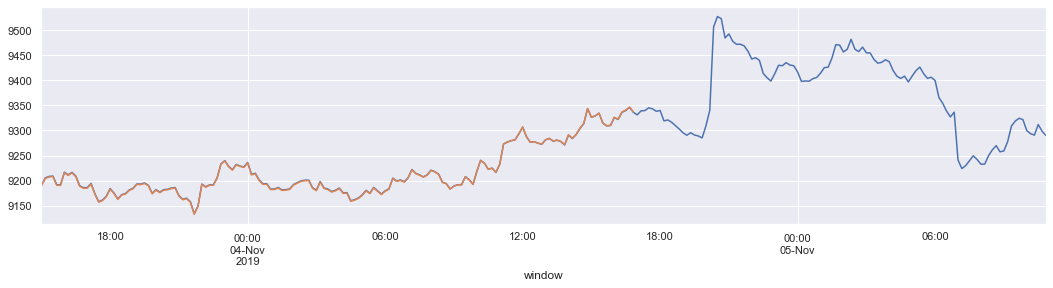

In [272]:
sns.set(style='darkgrid')
df['price'].plot()
df_pred['y_pred'].plot();